#**PROBLEM STATEMENT**

##**Context**

AllLife Bank intends to concentrate on its credit card customer base in the coming fiscal year. Their marketing research team informed them that market penetration should be improved.  Based on this information, the Marketing team advises launching personalised efforts to target new clients and upsell existing customers.  Another result from the market research was that customers had a negative perception of back support services.  Based on this, the Operations team intends to update the service delivery paradigm in order to answer consumer queries more quickly. The Head of Marketing and the Head of Delivery both decide to contact the Data Science team for assistance.

##**Objective**

Using clustering algorithms, determine various customer segments based on past interactions with the bank and spending patterns, and advise the bank on how to offer these consumers better marketing and customer care.

##**Data Description**


The data provided is of various bank customers and their financial attributes such as credit limit, total number of credit cards held by the customer, and the various channels through which customers have contacted the bank with any questions.


**Data Dictionary**:

* ***Sl_No:*** Primary key of the records
* ***Customer Key:*** Customer identification number
* ***Average Credit Limit:*** Average credit limit of each customer for all credit cards
* ***Total credit cards:*** Total number of credit cards possessed by the customer
* ***Total visits bank:*** Total number of visits that the customer made (yearly) personally to the bank
* ***Total visits online:*** Total number of visits or online logins made by the customer (yearly)
* ***Total calls made:*** Total number of calls made by the customer to the bank or its customer service department (yearly)

#**IMPORTING IMPORTANT LIBRARIES**

In [ ]:
#Importing libraries for reading and manipulating data
import numpy as np
import pandas as pd

#Libraries for data visualizations
import seaborn as sns
import matplotlib.pyplot as plt

#libraries to limit the number of displayed column
sns.set_theme(style='darkgrid')
#Removes the number of limits in displayed columns
pd.set_option('display.max_columns', None)
#Sets the number of limits of displayed rows
pd.set_option('display.max_rows', 200)

#Scaling the data using z-score
from sklearn.preprocessing import StandardScaler

#to compute distance
from scipy.spatial.distance import pdist, cdist

#To perform K-Means Clustering and Silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#To visualize elbo curve
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

#To perform Hierarchical clustering, compute cophenatic correlation and create dendograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

## to perform PCA
from sklearn.decomposition import PCA

# to suppress warnings
import warnings
warnings.filterwarnings("ignore")

#**UPLOADING & READING FILE**

**Uploading the file**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Credit Card Customer Data.xlsx to Credit Card Customer Data.xlsx


**Reading the file**

In [ ]:
# loading the dataset
data = pd.read_excel("Credit Card Customer Data.xlsx")

#**DATA OVERVIEW**

The objective of this step is to get an overview of our dataset by:

* Observing the first few rows of the dataset, to check whether the dataset has been loaded properly or not.
* Fetching information regarding the number of rows and columns in the dataset.
* Finding out the data types of the columns to ensure that data is stored in the preferred format and the value of each property is as expected.
* Checking the statistical summary of the dataset to get an overview of the numerical columns of the dataset.


**Display the Top 5 rows of dataset**

In [ ]:
data.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


**Display the Bottom 5 rows of dataset**

In [ ]:
data.tail()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
655,656,51108,99000,10,1,10,0
656,657,60732,84000,10,1,13,2
657,658,53834,145000,8,1,9,1
658,659,80655,172000,10,1,15,0
659,660,80150,167000,9,0,12,2


**Observations:**

 * We have successfully loaded the data set.
 * There are all numerical columns including Sl_No and Customer key, these two columns have unique values for each customer. thus, won't be helpful in clustering.
 * Therefore, we will drop these unique identified columns later.

**Shape of dataset**

In [ ]:
data.shape

(660, 7)

**Observations:**

* There are 660 rows and 7 columns in our dataset.

**Checking Data Types**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observations:**

* There are 7 columns of integer type in our dataset.
* They are all numerical variables.

**Dropping "Sl_No" & "Customer Key" columns**

* The "Sl_No" and "Customer Key" columns are unique to each customer.  
* They do not indicate any characteristics or behaviours that may be used to identify which consumers are similar.
* Including them in the clustering process would generate noise and would not assist to identify significant customer groupings.

In [ ]:
#copying the data to another variable to avoid any changes to original data
df = data.copy()
#drop columns
df.drop(["Sl_No", 'Customer Key'], axis=1, inplace=True)

In [ ]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


**Observations:**

* We can observe that "Sl_No", "Customer Key" have been dropped successfully from our dataset.

**Checking Statistical Summary**

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


**Observations:**

***Avg_Credit_Limit:***

* The average credit limit is about **34,574**.
 There is a large standard deviation (approximately **37,625**), indicating a wide range in credit limits across customers.
* The **minimal credit limit is 3,000, while the maximum is 200,000**, indicating a large variation.
* The **75th percentile (48,000)** is significantly higher than the **median (18,000)**, indicating that the distribution may be skewed towards higher credit limits.


***Total_Credit_Cards:***

* Customers, on **average, have 4.7** credit cards.
* The **standard deviation is approximately 2.17**, showing substantial variations in the number of credit cards.
* The **minimum is 1** card, while the **highest is 10** cards.
* The **median (5)** is close to the mean, indicating a somewhat symmetrical distribution.

***Total_visits_bank:***

* Customers visit the bank in person approximately **2.4 times per year on average**.
* The **standard deviation is approximately 1.63**, indicating a slight variation in bank visits.
* The **minimum and maximum number of visits are 0 and 5**, respectively.
* The **median (2)** is close to the mean, indicating a somewhat symmetrical distribution.

***Total_visits_online:***

* Customers visit online platforms around **2.6 times per year on average**.
* The **standard deviation is higher (approximately 2.94)** than for bank visits, indicating greater variability in online visit frequency.
* The **minimum is zero visits, and the maximum is 15 visits**, suggesting a broad range.
* The **median (2)** is slightly lower than the mean, indicating that some customers visit the website more frequently than others.

***Total_calls_made:***

* Customers make an **average of 3.6** calls to their bank or customer service per year.
* The **standard deviation is approximately 2.87**, indicating a significant variation in call frequency.
* The **minimum is zero calls, while the highest is 10 calls**.
* The **median (3)** is close to the mean, indicating a somewhat symmetrical distribution.


**Checking the unique values & count**

In [ ]:
unique_counts = df.nunique()
print("Unique values are:")
unique_counts

Unique values are:


,0
Avg_Credit_Limit,110
Total_Credit_Cards,10
Total_visits_bank,6
Total_visits_online,16
Total_calls_made,11


**Observations:**

***Avg_Credit_Limit:***

* There are **110 different possibilities for the average credit limit**.  
* This suggests a wide variation of credit limitations among consumers, as is typical for a financial attribute like this.

***Total_Credit_Cards:***

* There are **10 different possibilities for the total number of credit cards**.
* This suggests that clients in this dataset have anything from 1 to 10 credit cards (as shown in statistical summary result, the minimum is 1 and the maximum is 10).
* This is a limited number of distinct values, implying that the number of credit cards is a more distinctive attribute.

***Total_visits_bank:***

* There are 6 different possibilities for the total number of bank visits.  **Customers visit the bank between 0 and 5 times a year**, as confirmed by this and statistical summary output that displays a min of 0 and max of 5.
* This is also a distinct feature with a limited scope.


***Total_visits_online:***

* There are 16 different possibilities for the total number of online visits.  With a minimum of 0 and a maximum of 15, this suggests a wider range of online visit frequencies than bank visits.


***Total_calls_made:***

* There are 11 different counts for the total number of calls made.  
* The minimum is 0 and the maximum is 10, indicating the range of calls made.  
* This is another distinct feature with a limited set of options.



**Checking Missing Values**

In [ ]:
print("Missing values:")
df.isnull().sum()

Missing values:


,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0


**Observations:**

* There are **no missing values** in our dataset. This suggest our dataset do not require any imputing techniques. Thereby, preserving the data integrity.

**Checking for Duplicates**

In [ ]:
print("Number of duplicate:")
df.duplicated().sum()

Number of duplicate:


np.int64(11)

**Observations:**

* There are **11 duplicate rows** in our dataset.

In [ ]:
# Displaying the duplicate rows
duplicate_rows = df[df.duplicated()]
print("Duplicate Rows:")
display(duplicate_rows)

Duplicate Rows:


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
162,8000,2,0,3,4
175,6000,1,0,2,5
215,8000,4,0,4,7
295,10000,6,4,2,3
324,9000,4,5,0,4
361,18000,6,3,1,4
378,12000,6,5,2,1
385,8000,7,4,2,0
395,5000,4,5,0,1
455,47000,6,2,0,4


In [ ]:
# Calculate the percentage of duplicate rows
percentage_duplicates = (df.duplicated().sum() / df.shape[0]) * 100

print(f"Percentage of duplicate rows: {percentage_duplicates:.2f}%")

Percentage of duplicate rows: 1.67%


**Observations:**

* Duplicate rows account for only 1.67% of our dataset; deleting them will have no major impact on the overall size of our dataset while significantly improving the quality and reliability of our analysis.


**Deleting Duplicate Rows**

In [ ]:
# Copying the df data to df1 variable to avoid any changes to original data
df1 = df.copy()

# Drop duplicate rows from df1 and RESET THE INDEX
df1 = df1.drop_duplicates().reset_index(drop=True)

# Verify that duplicates have been removed
print("Number of duplicate rows in df1 after dropping:", df1.duplicated().sum())
print("Shape of df1 after dropping duplicates:", df1.shape)
print("Index range after reset:", df1.index.min(), "to", df1.index.max())  # Should be 0 to 648

Number of duplicate rows in df1 after dropping: 0
Shape of df1 after dropping duplicates: (649, 5)
Index range after reset: 0 to 648


**Observations:**

* After droping the duplicate rows, there are **no duplicates in our dataset**. This indicates data is fit to do further analysis.

* Now, we have **649 rows and 5 columns** (we dropped Sl_No and Customer Key columns).

* Index is reset perfectly

**Checking Statistical Summary again after removing the duplicates**

In [ ]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,649.0,34878.274268,37813.736638,3000.0,11000.0,18000.0,49000.0,200000.0
Total_Credit_Cards,649.0,4.708783,2.173763,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,649.0,2.397535,1.625148,0.0,1.0,2.0,4.0,5.0
Total_visits_online,649.0,2.624037,2.952888,0.0,1.0,2.0,4.0,15.0
Total_calls_made,649.0,3.590139,2.877911,0.0,1.0,3.0,5.0,10.0


**Observations of statistical summary after dropping the duplicates:**

***Count:***

* This is the most significant and predicted change, dropping from **660 to 649** and verifying the removal of duplicates.

* The **mean and standard deviation** of all variables (Avg_Credit_Limit, Total_Credit_Cards, Total_visits_bank, Total_visits_online, and Total_calls_made) were rather **stable**.  Some rose marginally, while **Total_visits_bank fell slightly**.


***Minimum and maximum:***

* The minimum and maximum values for each variable **remained constant**.


***Quartiles (25th, 50th, 75th):***

* The **median** (50th percentile) stayed **constant across all factors**.  
* The **25th and 75th percentiles witnessed very minor adjustments** (e.g., a **1000 rise in Avg_Credit_Limit**).


**Conclusion:**

* In essence, eliminating 1.67% of the duplicate rows had no significant effect on the central tendency, spread, or range of the data for any of the variables.
* The dataset's general statistical profile remains virtually unchanged following this cleaning process.

**Checking unqiue value counts again after removing the duplicates**

In [ ]:
unique_counts = df1.nunique()
print("Unique values are:")
unique_counts

Unique values are:


,0
Avg_Credit_Limit,110
Total_Credit_Cards,10
Total_visits_bank,6
Total_visits_online,16
Total_calls_made,11


In [ ]:
# Loop through numerical columns and display their unique values
num_cols = ['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online', 'Total_calls_made']

for col in num_cols:
    print(f"\nColumn: {col}")
    # Sort the unique values in ascending order and convert to a standard Python list of integers
    sorted_unique_values = sorted(df1[col].unique())
    print([int(value) for value in sorted_unique_values])


Column: Total_Credit_Cards
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

Column: Total_visits_bank
[0, 1, 2, 3, 4, 5]

Column: Total_visits_online
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Column: Total_calls_made
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


**Observations on unqiue counts after dropping duplicate values:**

* The number of unique values for each variables **remained same** after deleting the duplicate rows.
* This demonstrates that **the dropped rows were exact duplicates of existing data points and had no new or unique values** that were not already present in the dataset.
* This implies that the duplicate removal method was successful in removing redundant entries while maintaining the fundamental range or categories of values in each column.
* ***Total_Credit_Cards:*** The unique values for this range from **1 to 10**.
* ***Total_visits_bank:*** The unique values for this range from **0 to 5**.
* ***Total_visits_online:*** The unique values for this range from **0 to 15**.
* ***Total_calls_made:*** The unique values for this range from **0 to 10**.

#**EXPLORATORY DATA ANALYSIS**

##**EDA Functions**

* We will define functions below to carry out EDA.

In [ ]:
# Function for combined histogram and box plots.
def custplot_box_hist(
    df_copy,
    column_name,
    figure_size=(10,6),
    show_kde=False,
    num_bins=20,
    box_color=None,
    hist_color=None
):
    """
    Combined boxplot + histogram for a numeric column.

    Parameters
    ----------
    df_copy : pandas.DataFrame
        DataFrame to plot.
    column_name : str
        Column to visualise.
    figure_size : tuple, optional
        Overall figure size (default (10, 6)).
    show_kde : bool
        Overlay a KDE curve on the histogram.
    num_bins : int, optional
        Number of histogram bins (default 20).
    box_color : str or None
        Colour for the boxplot (name like 'violet', 'skyblue', etc).
    hist_color : str or None
        Colour for the histogram (name or palette color).
    """

    fig, (box_ax, hist_ax) = plt.subplots(
        nrows=2,
        sharex=True,
        figsize=figure_size,
        gridspec_kw={"height_ratios": [1, 3]}
    )

    # ── Boxplot ──
    sns.boxplot(
        x=df_copy[column_name],
        ax=box_ax,
        showmeans=True,
        color=box_color,
        meanprops={"marker": "o", "markerfacecolor": "gold"} # boxplot will be created and a "o" will indicate the mean value of the column
    )
    box_ax.set(title=f"Boxplot and Histogram of {column_name}", xlabel="")

    # ── Histogram ──
    sns.histplot(
        df_copy[column_name],
        ax=hist_ax,
        bins=num_bins,
        kde=show_kde,
        color=hist_color
    )

    # Mean and Median lines
    hist_ax.axvline(df_copy[column_name].mean(),   color="red", linestyle="--", label="Mean")
    hist_ax.axvline(df_copy[column_name].median(), color="black", linestyle="-",  label="Median")
    hist_ax.legend()

    plt.tight_layout()
    plt.show()
    plt.close(fig)

In [ ]:
# Function for stacked bar plot.
def stacked_barplot_custom(data, predictor, target, palette='Set2'):
    """
    Creates a normalized stacked bar plot for a categorical predictor and target variable.
    Displays the raw counts and the proportional distribution.

    Parameters:
    - data (pd.DataFrame): The input dataset
    - predictor (str): The categorical independent variable to group by (x-axis)
    - target (str): The categorical target variable (segments within each bar)
    - palette (str or list): Color palette name or list of hex codes (default: 'Set2')
    """

    # Determine the number of unique categories in predictor to size the figure dynamically
    category_count = data[predictor].nunique()

    # Generate a cross-tabulation (raw counts) of predictor vs target
    raw_counts = pd.crosstab(data[predictor], data[target], margins=True)
    print(raw_counts)
    print("-" * 100)

    # Normalize the crosstab row-wise to get proportions within each predictor category
    normalized_counts = pd.crosstab(data[predictor], data[target], normalize='index')

    # Identify the least frequent target class to sort categories by it (helps consistency)
    least_frequent_class = data[target].value_counts().index[-1]
    normalized_sorted = normalized_counts.sort_values(by=least_frequent_class, ascending=False)

    # Select a color palette based on the number of target classes
    num_classes = normalized_sorted.shape[1]
    colors = sns.color_palette(palette, n_colors=num_classes)

    # Plot the normalized stacked bar chart
    ax = normalized_sorted.plot(
        kind='bar',
        stacked=True,
        figsize=(category_count + 5, 5),
        color=colors
    )

    # Add labels and adjust layout
    plt.xlabel(predictor)
    plt.ylabel('Proportion')
    plt.title(f"Stacked Bar Plot: {predictor} vs {target}")
    plt.xticks(rotation=45)

    # Move legend outside the plot and format it
    plt.legend(title=target, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)

    # Ensure layout is not clipped
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Close the plot to prevent it from being duplicated in notebooks
    plt.close(ax.figure)

##**Univariate Analysis**

**Distribution of Average Credit Limit**

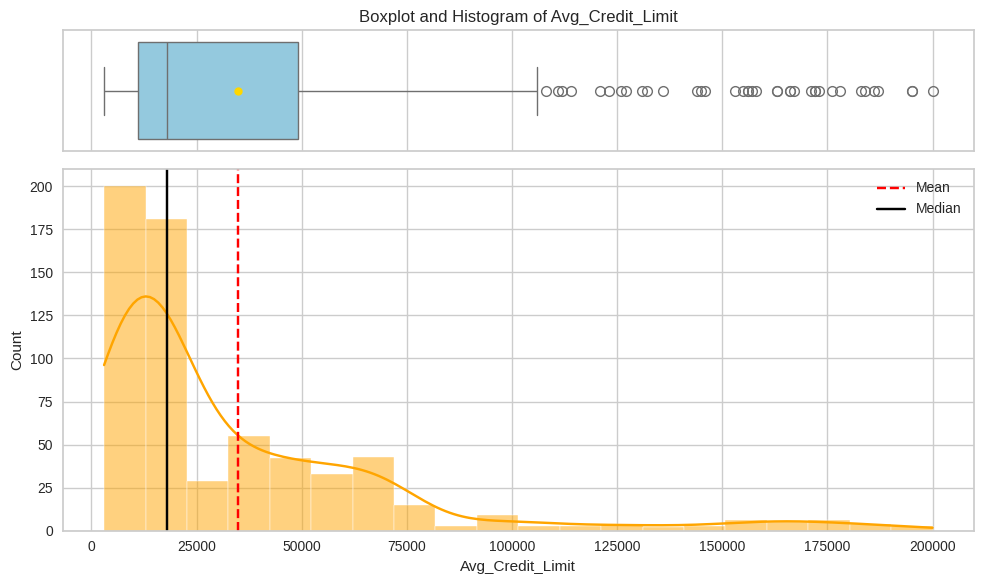

In [ ]:
custplot_box_hist(df1, "Avg_Credit_Limit", show_kde=True, box_color="skyblue", hist_color="orange")


**Observations:**

* The distribution of Avg_Credit_Limit is **heavily skewed to the right**. This is demonstrated by the long tail on the right side of the histogram and the median (black line) being far to the left of the mean (red dashed line).
* The **mean credit limit is significantly greater than the median i.e.~34878**, as expected in a right-skewed distribution.  This shows that some consumers have **extremely large credit limits**, which are dragging the mean upwards.
* The boxplot depicts a wide range of data, with a **large interquartile range**.  This demonstrates a large difference in typical credit limits among customers.
* The boxplot clearly reveals multiple data points outside the upper whisker, suggesting the **presence of outliers with abnormally high average credit limits i.e. ranging from greater than 10,0000 to 200,000**.
* A substantial **proportion of customers have lower average credit limits**, as indicated by the peak in the histogram on the left side.


**Distribution of Total Credit Cards**

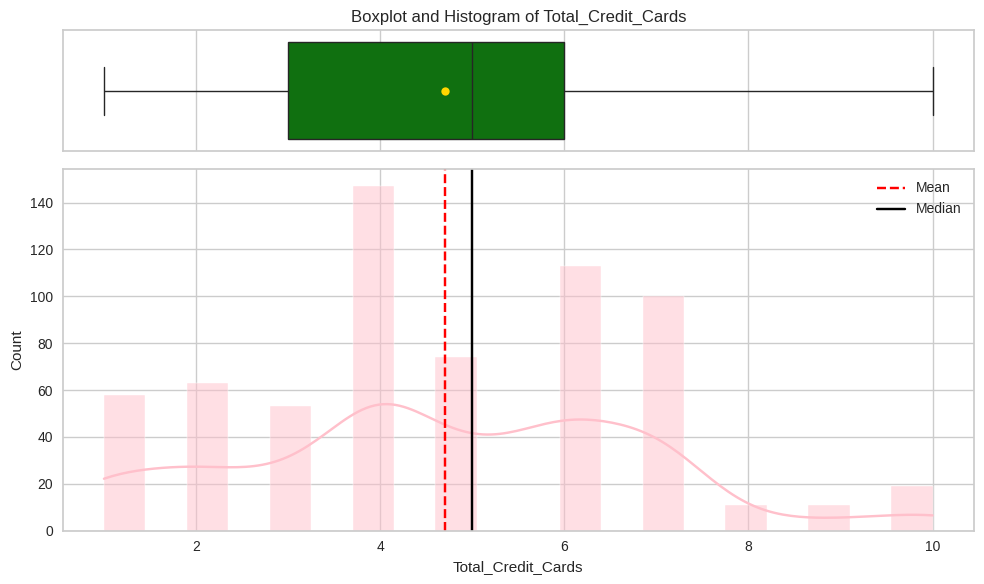

In [ ]:
custplot_box_hist(df1, "Total_Credit_Cards", show_kde=True, box_color="green", hist_color="pink")

**Observations:**

* The distribution of Total_Credit_Cards appears to be **nearly symmetrical**.  The mean and median are extremely close, indicating a fairly balanced distribution.
* The histogram reveals a **higher concentration of customers with 3 to 6 credit cards, with a peak at 4**. There are fewer customers with a small number (1 or 3) or a large number (8, 9, or 10) of credit cards.
* The **mean number of credit cards** owned by customers is about **4.7**.
* The most prevalent number of credit cards is 4, which is also the median.
* The boxplot illustrates that the majority of consumers have **3 to 6 credit cards (interquartile range)**.  The entire range is 1 to 10 credit cards.
* The boxplot for Total_Credit_Cards shows **no significant outliers**, indicating that the majority of consumers own credit cards within the acceptable range.


**Distribution of Total Visits Bank**

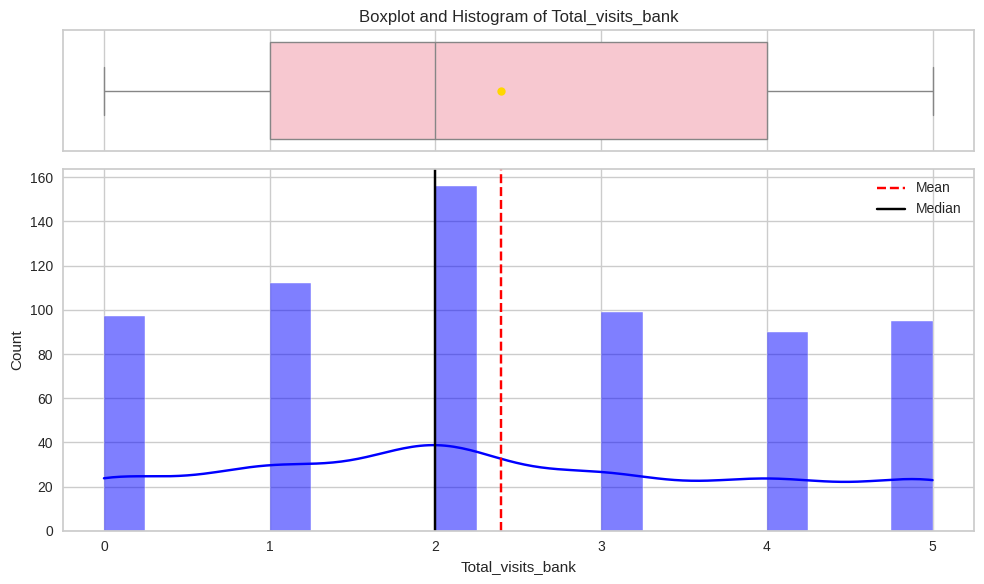

In [ ]:
custplot_box_hist(df1, "Total_visits_bank", show_kde=True, box_color="pink", hist_color="blue")

**Observations:**

* The distribution of Total_visits_bank appears to be almost symmetrical, with a peak around 2 visits. The mean and median are very close, further supporting this observation.
* Customers visit the bank in person around **~2.4 times per year on average**. The most frequent numbers of visits are **1, 2 and 3**, with **2** also being the median.
* The boxplot shows that the most of customers visit the bank between **1 and 4** times per year (interquartile range). The overall range is from **0 to 5** visits per year. The **customers who makes zero visits**, suggests they might visit bank via online platforms.
* There are **no significant outliers**, suggesting that most customers fall within a usual range of bank visits.
* The histogram shows a concentration of customers with **1 to 3** times bank visits per year. There are also a significant number of customers with **1 and 4** times visits.

**Distribution of Total Visits Online**

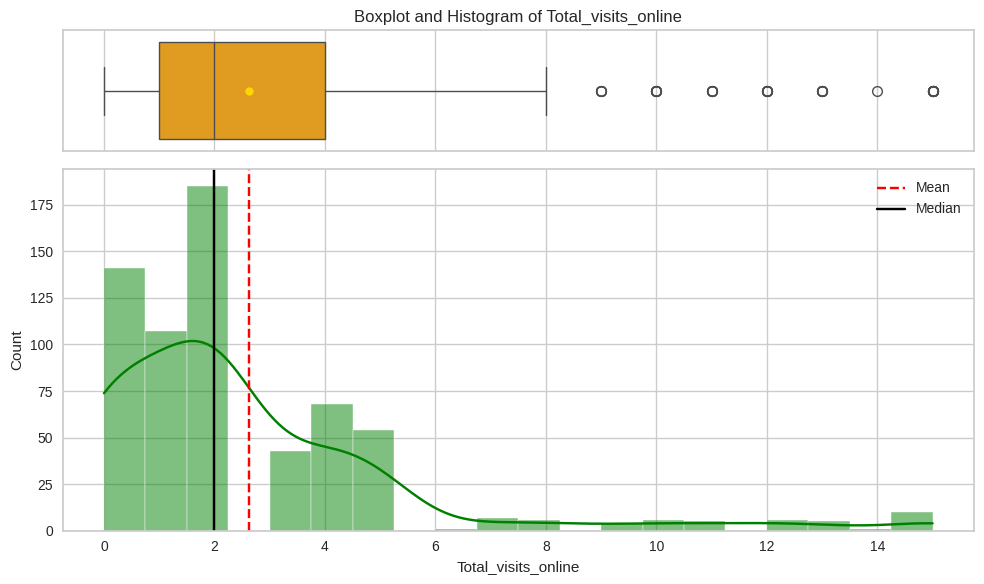

In [ ]:
custplot_box_hist(df1, "Total_visits_online", show_kde=True, box_color="orange", hist_color="green")

**Observations:**

* The distribution of Total_visits_online is **highly right skewed**, suggesting
The long tail on the right side of the histogram and the median being significantly to the left of the mean.
* Customers visit online platforms around **2.6 times per year on average** (mean). The median number of online visits is **2**.
* The boxplot shows a wide range of online visits by customers. The overall range is from **0 to 15** visits per year, indicating some customers never use online platform, while those who do highly engage online with bank 1-15 times a year.
* There are **few customers who makes zero online visits**, suggesting they might be visiting bank directly.
* The boxplot suggests the **presence of outliers** with a high number of online visits (9 to 15), suggesting few customers visits online platforms much more frequently than the majority.
* The histogram shows a concentration of customers with a less number of online visits, particularly around **0 to 5** visits. This indicates that a significant portion of customers do not visit online platforms frequently.

**Distribution of Total Calls Made**

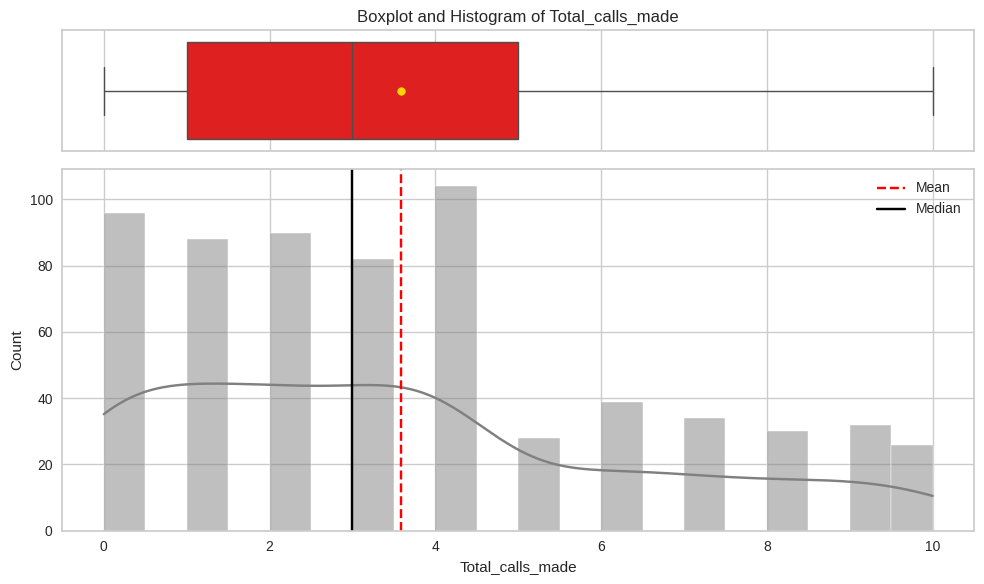

In [ ]:
custplot_box_hist(df1, "Total_calls_made", show_kde=True, box_color="red", hist_color="gray")

**Observations:**

* The distribution appears to be **slightly right skewed**, with a slight peak around 4 calls. The mean and median are very close, supporting this observation.
* The proximity of the mean and median suggests a slightly balanced distribution of the number of calls made by customers.
* Customers make an average of around **3.6** calls to the bank or customer service per year. The median number of calls is **3**.
  
* The overall range of calls made is from **0 to 10** calls per year, this highlights the diversity in how often customers contact the bank via phone calls. Few customers make **no calls** and this aligns with the bank's concern about poor service perception.
* There are **no significant outliers** visible in the boxplot, suggesting that most customers fall within a typical range of call frequency, indicating that there are no extreme values in the number of calls made.
* The histogram shows a concentration of customers making between **1 and 5** calls per year, with a significant peak around **4** calls. The higher bars in the histogram in this range indicate that a larger proportion of customers make this number of calls annually.

##**Bivariate Analysis**

**Heatmap Analysis on All Numerical Columns**

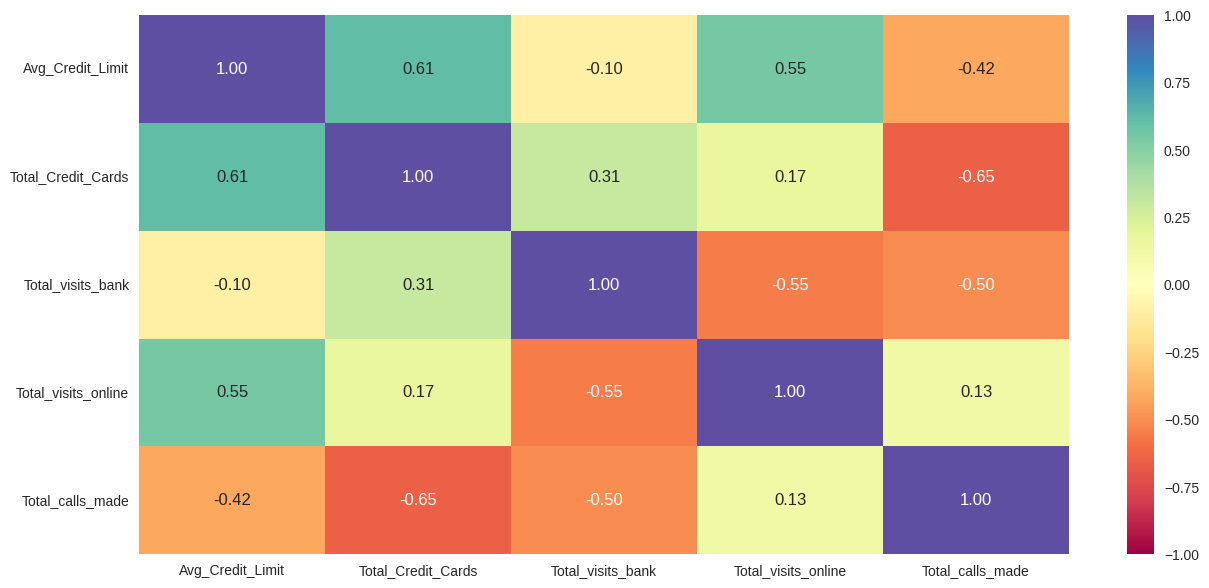

In [ ]:
# To create the heatmap, We'll create a list of only the numerical variables
corr = df1.select_dtypes(include=np.number).columns.tolist()

# Now let's plot the heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(
    df1[corr].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

**Observations from the Heatmap:**

* ***Avg_Credit_Limit & Total_Credit_Cards:*** There is a strong positive correlation (**r = 0.61**). This shows that as the average credit limit increases, the total number of credit cards a customer has also increases.
* ***Total_visits_online & Total_calls_made:*** There is a relatively weak positive correlation (**r = 0.13**). This indicates that customers who visits bank via online platforms may also tend to make more calls.
* ***Avg_Credit_Limit & Total_visits_online:*** There is a strong positive correlation (**r = 0.55**). Customers with higher average credit limits tend to have a higher number of bank website visits.
* ***Total_Credit_Cards & Total_visits_online:*** There is a weak positive correlation (**r = 0.17**). Customers with more credit cards tend to have a slightly more number of online visits.
* ***Avg_Credit_Limit & Total_visits_bank:*** There is a weak negative correlation (**r = -0.10**). Customers who high average credit limit may visit bank less frequently.
* ***Avg_Credit_Limit & Total_calls_made:*** There is a moderate negative correlation (**r = -0.42**). Customers who high average credit limit will make slightly less calls.
* ***Total_Credit_Cards & Total_visits_bank:*** There is a moderate positive correlation (**r = 0.31**). This means customers who have more credit cards also visits banks sometimes instead of online.
* ***Total_visits_bank & Total_visits_online:*** There is a moderate negative correlation (**r = -0.55**). Customers who visit the bank more frequently tend to visit online platforms less frequently.
* ***Total_visits_bank & Total_calls_made:*** There is a moderate negative correlation (**r = -0.50**). Customers who visit banks will make fewer calls.

* ***Total_Credit_Cards & Total_calls_made:*** There is a slightly strong negative correlation (r = -0.65). Customers who owns more credit cards will make fewer calls to the bank.


**Distribution of Avg_Credit_Limit vs Total_Credit_Cards**

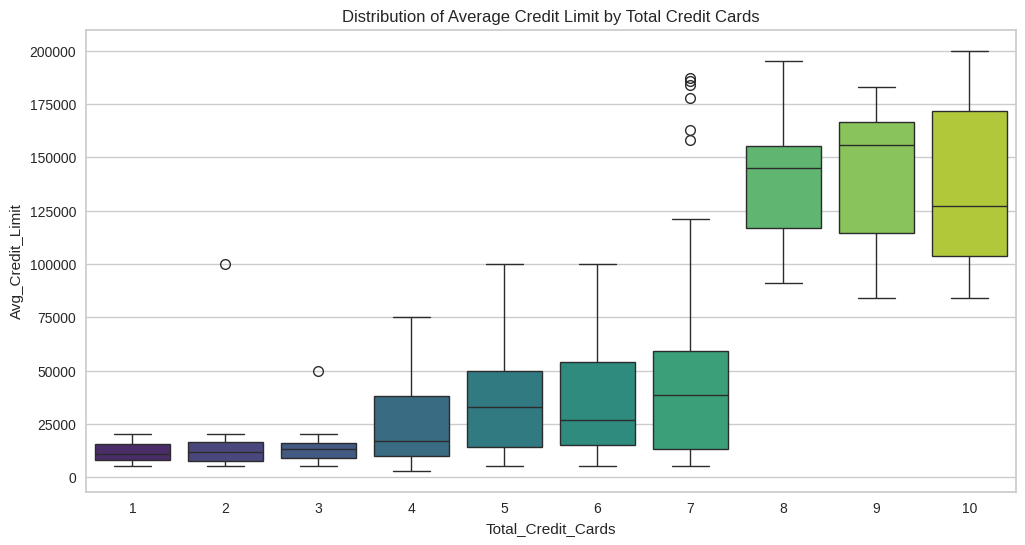

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Total_Credit_Cards', y='Avg_Credit_Limit', data=df1, palette='viridis')
plt.title('Distribution of Average Credit Limit by Total Credit Cards')
plt.xlabel('Total_Credit_Cards')
plt.ylabel('Avg_Credit_Limit')
plt.show()

**Observations on the Distribution of Average Credit Limit by Total Credit Cards:**

* There is **certainly a pattern to rise in Average Credit Limit as the number of Total Credit Cards increases**.  This is demonstrated by the rising median lines and the upward shift of the boxplots for larger numbers of credit cards.
* For customers with a small number of credit cards (e.g., **1 or 2**), the average credit limit is **low**, with the majority of values falling **below 20,000**.
* The median and interquartile range of the average credit limit rise in proportion to the number of credit cards.  Customers with 10 credit cards, for example, have much larger average credit limits than those with fewer cards, with a median of **approximately 125,000 and a range of up to 200,000.**
* The spread of the average credit limit also tends to grow with the number of credit cards, implying that **credit limits vary more widely** for customers with more cards.
* **Several outliers are present** for visit group **2 & 3**, especially for customers who have a greater number of credit cards (**7 credit cards**), suggesting that some members of those categories have abnormally high average credit limits.
* The boxplots illustrate that, even with a larger number of credit cards, there is still a range of average credit limits, but the distribution shifts to higher values.

**Distribution of Avg_Credit_Limit vs Total_visits_bank**

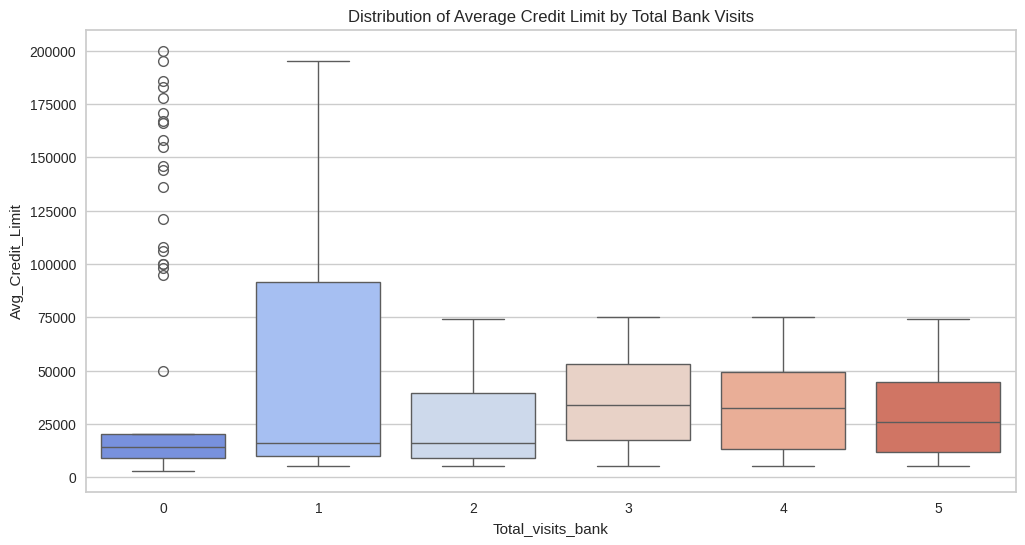

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Total_visits_bank', y='Avg_Credit_Limit', data=df1, palette='coolwarm')
plt.title('Distribution of Average Credit Limit by Total Bank Visits')
plt.xlabel('Total_visits_bank')
plt.ylabel('Avg_Credit_Limit')
plt.show()

**Observations on the Distribution of Average Credit Limit by Total Bank Visits:**

* There is a weak linear trend in the Average Credit Limit as the number of Total Bank Visits increases. The medians across the different bank visit counts are relatively close, especially for visit counts from **1 to 4**.
* For customers who make **0** bank visits, the average credit limit is similar to those who make **1 to 4** visits, although the spread is a least.
* Customer with **1** bank visit seems to have higher credit limit ranging from **5000 to 195,000 with widest spread among all groups.**
* Customers with **5** bank visits has a higher median for an average credit limit compared to those with **1 to 4** visits, with a moderate the interquartile range (IQR).
* The boxplots for most visit counts show a **significant number of outliers** for **0** visit with high average credit limits ranging from **50,000 to upto 20,0000**, indicating that within this group of bank visits, there are customers with exceptionally high credit limits.
* The variability (IQR) in average credit limits is not consistent across groups. It is  **most compact for customers with 0 visit**, suggesting these customers rely on online banking and Those with **widest IQR i.e., 2,3 and 4 visits**, shows that these group of customers seeking to resolve banking issues.
* The boxplot for **0** bank visits shows a particularly compact spread with several high outliers, suggesting a diverse group of customers who don't visit the bank physically.

**Distribution of Avg_Credit_Limit vs Total_visits_online**

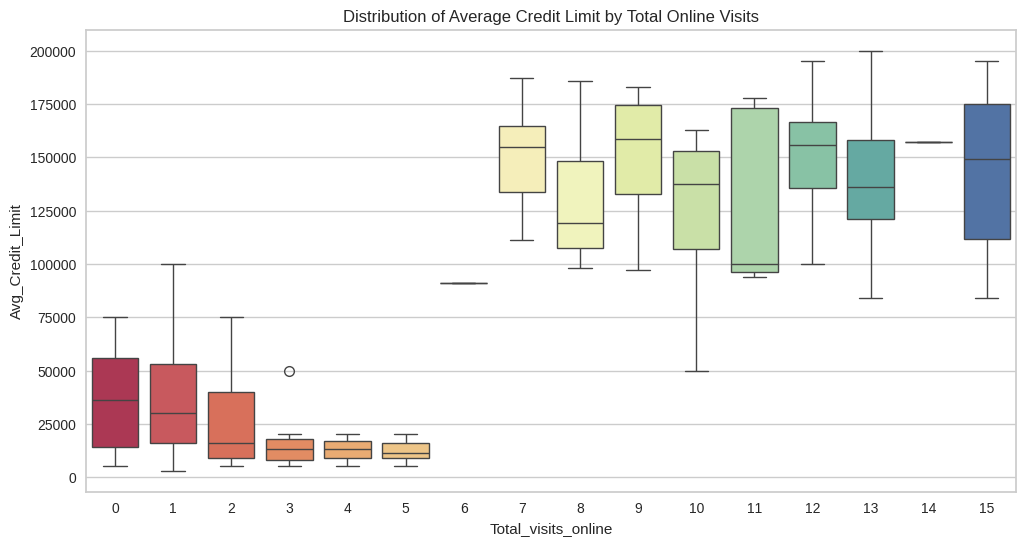

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Total_visits_online', y='Avg_Credit_Limit', data=df1, palette='Spectral')
plt.title('Distribution of Average Credit Limit by Total Online Visits')
plt.xlabel('Total_visits_online')
plt.ylabel('Avg_Credit_Limit')
plt.show()

**Observations on the Distribution of Average Credit Limit by Total Online Visits:**

* There appears to be a consistent pattern of increasing average credit limit as total online visits rise, particularly for lower visit counts.  The median average credit limit tends to climb with increased internet visit frequency.
* For clients with **0** online visits, the typical credit limit varies greatly, with a relatively higher median of approximately **35,000** as compared to visits 1 to 5.
* As the number of online visits increases from **1** to **10-12**, so does the median average credit limit.  Customers with **10 or 15** online visits, have a larger median credit limit, ranging from **130,0000 to 150,000**, than those with less visits.
* For higher numbers of online visits (e.g., **12-15**), the median average credit limit appears to be among the highest, potentially reaching **100,000 to 15,0000**.
* The spread of the average credit limit also seems to increase with higher numbers of online visits, suggesting greater variability in credit limits for customers who engage more online.
* The spread of **visit 6** is least as compared to others visit groups with median value of average credit limit ranging around **80,000**.
* One outliers for visit 3 with **50,000** average credit limits.
* The overall range of Average Credit Limit shown in this plot is from **3,000 to 200,000**, reflecting the spread across all levels of online visits.

* The relationship isn't completely linear across all visit groups.  The greatest increase in median credit limit occurs not between the lowest visit groups, but rather at the upper end.  

* The median increases significantly for the groups with the largest number of online visits (e.g., 12-15).  This suggests an extremely high digital involvement is a strong predictor of high creditworthiness.

**Distribution of Avg_Credit_Limit vs Total_calls_made**

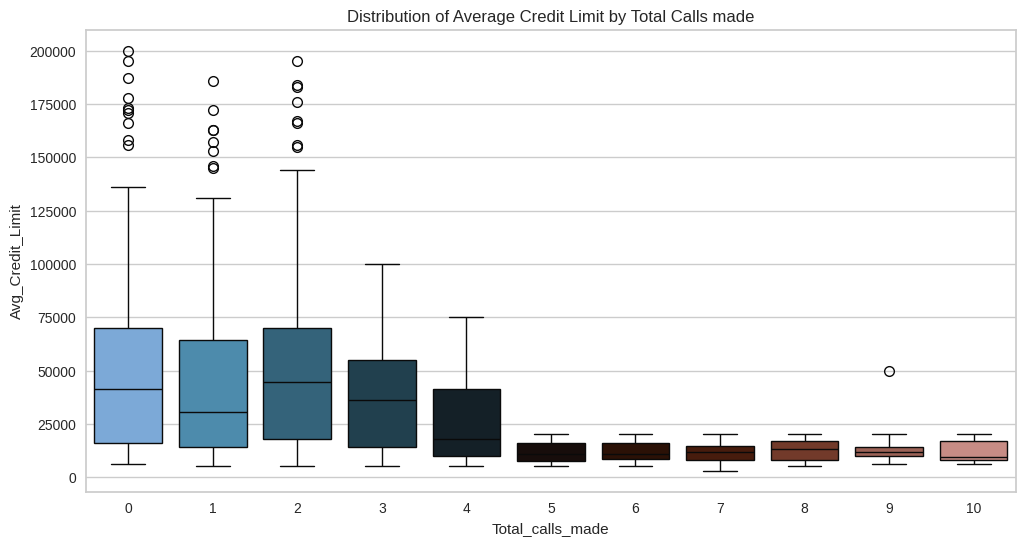

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Total_calls_made', y='Avg_Credit_Limit', data=df1, palette='berlin')
plt.title('Distribution of Average Credit Limit by Total Calls made')
plt.xlabel('Total_calls_made')
plt.ylabel('Avg_Credit_Limit')
plt.show()

**Observations on the Distribution of Average Credit Limit by Total Calls Made:**

* The plot shows the distribution of Average Credit Limit across different numbers of Total Calls Made (from 0 to 10).
* There appears to be a general pattern of the median average credit limit decreasing as the number of Total Calls Made increases.
* For customers who made **2** calls, the median credit limit appears to be among the highest, roughly around **45,000**, with a wide spread and several high outliers with average credit limit reaching up to **200,000**.
* Customers who made **0** call, the median average credit limit is lower than **2 calls**, roughly around **40,000**, with a wide spread and several high outliers with average credit limit exceeding **200,000**.
* For customers who made **1** call, the median average credit limit is, roughly around **30,000**, with a wide spread and several high outliers with average credit limit ranging from  **130,000 to 185,000**.
* As the number of calls made increases, the median average credit limit generally decreases. For example, the median for customers making **10** calls is significantly lower, around **10,000 to 20,000**.
* The spread of the average credit limit seems to be wider for lower numbers of calls made and tends to decrease as the number of calls increases.
* Outliers with very high average credit limits are present for lower numbers of calls made (e.g., 0, 1, 2 calls), and **one outlier for 9 calls at 50,000 average credit limit**.
* For higher numbers of calls made (e.g., 8, 9, 10 calls), the distribution of average credit limit is more concentrated at lower values with fewer or with 1 outlier.
* The overall range of Average Credit Limit across all call counts is from **3,000 to slightly above 200,000**.

**Distribution of Total_Credit_Cards vs Total_visits_bank**

Total_visits_bank    0    1    2   3   4   5  All
Total_Credit_Cards                               
1                   20   21   17   0   0   0   58
2                   24   19   20   0   0   0   63
3                   21   18   14   0   0   0   53
4                   12   22   34  26  27  26  147
5                    1    1   24  15  18  15   74
6                    1    0   23  33  23  33  113
7                    4    4   24  25  22  21  100
8                    4    7    0   0   0   0   11
9                    3    8    0   0   0   0   11
10                   7   12    0   0   0   0   19
All                 97  112  156  99  90  95  649
----------------------------------------------------------------------------------------------------


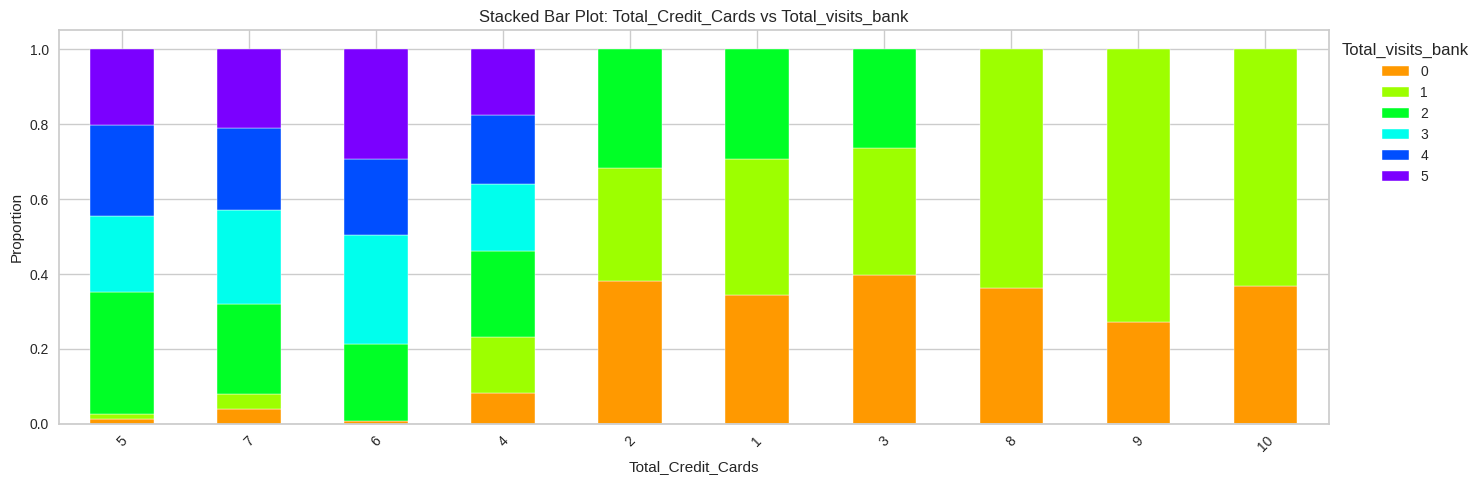

In [ ]:
stacked_barplot_custom(df1, "Total_Credit_Cards", "Total_visits_bank", palette='gist_rainbow')

**Observations on Distribution of Total Credit Cards by Total Bank Visits:**

* Customers with **1, 2, or 3 credit cards visit the bank only once or twice a year**.  None of these consumers went to the bank three, four, or five times.

* Customers with **4 credit cards have a more even distribution** of bank visits across all categories, ranging from 0 to 5 times per year.

* Customers with **5, 6, and 7 credit cards visit the bank in all visit categories (0 to 5 times)**, with a focus on 2, 3, 4, and 5 visits.

* Customers with **8, 9, or 10 credit cards visit the bank only once a year**.  Nobody comes back more than once.

* Overall, consumers with a modest number of cards **(4 to 7) are the most likely to visit** the bank in person (3 times or more per year).

* Customers with a large number of cards **(8 to 10) are less likely to visit** the bank in person, indicating a strong preference for online visits or calls.

**Distribution of Total_Credit_Cards vs Total_visits_online**

Total_Credit_Cards    1   2   3    4   5    6    7   8   9  10  All
Total_visits_online                                                
0                     0   0   0   42  22   34   43   0   0   0  141
1                     0   1   2   24  23   37   20   0   0   0  107
2                    17  14  12   44  28   41   29   0   0   0  185
3                     9  14   8   11   0    0    1   0   0   0   43
4                    17  18  14   19   0    0    0   0   0   0   68
5                    15  16  16    7   0    0    0   0   0   0   54
6                     0   0   0    0   0    0    0   1   0   0    1
7                     0   0   0    0   0    0    1   4   0   2    7
8                     0   0   0    0   0    0    1   2   1   2    6
9                     0   0   0    0   0    0    0   1   1   2    4
10                    0   0   1    0   0    0    1   0   2   2    6
11                    0   0   0    0   1    0    1   0   2   1    5
12                    0   0   0    0   0    1   

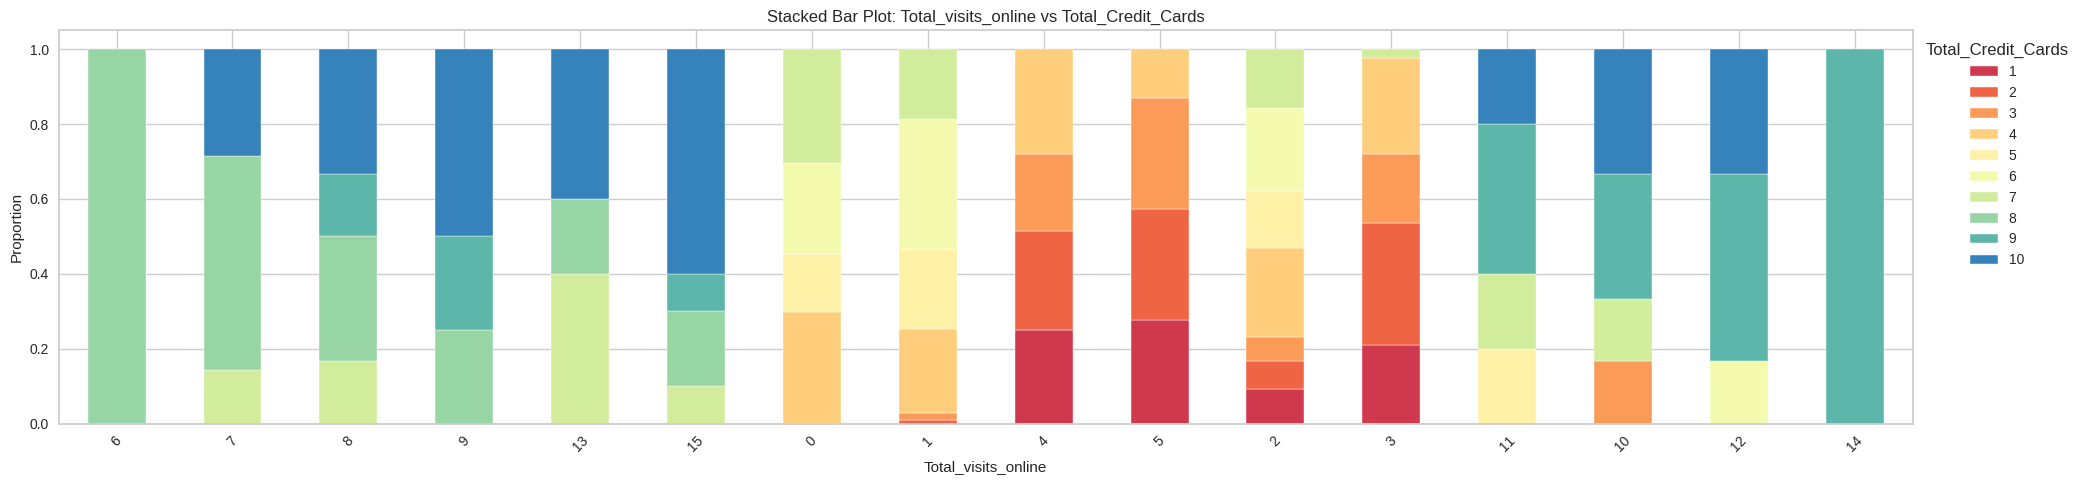

In [ ]:
stacked_barplot_custom(df1, "Total_visits_online", "Total_Credit_Cards", palette='Spectral')

**Observations on Distribution of Total Credit Cards by Total Online Visits:**

* Customers with **1, 2, or 3 credit cards make an average of two to five internet visits**.  A handful with three cards have ten or eleven visits, but none of these groupings go into the higher categories beyond that.

* Customers with **4 credit cards were split over 0-5 visits**, with a substantial proportion at 0, 1, and 2.  This group does not appear in any categories with more than five visits.

* Customers with **5 and 6 credit cards follow a similar pattern, clustering mainly around 0-2 visits**.  A few consumers with six cards appear as outliers at 11-12 visits, but their overall engagement is low.

* Customers with **7 credit cards** are more evenly distributed, with presence ranging from **zero to fifteen visits**.This is the first group to consistently perform in the double digit range.

* Customers with **8, 9, or 10 credit cards** stand out as the only ones with meaningful counts at very **high visit levels (8-15)**.  Customers with **10 cards**, for example, are represented in visits ranging from **7 to 15**.

* Overall, clients with fewer cards (1-6) are concentrated in the lower online visit range (0-5), whereas those with more cards (7-10) dominate the higher-visit categories (7 and up).

**Distribution of Total_Credit_Cards vs Total_calls_made**

Total_calls_made     0   1   2   3    4   5   6   7   8   9  10  All
Total_Credit_Cards                                                  
1                    0   0   0   0    6   7   7  12   7  10   9   58
2                    1   0   1   0   11   7  11   8  12   6   6   63
3                    0   1   0   0    7   8  13   6   4   9   5   53
4                   23  21  20  19   22   6   8   8   7   7   6  147
5                   13  14  15  14   18   0   0   0   0   0   0   74
6                   27  21  20  29   16   0   0   0   0   0   0  113
7                   19  18  19  20   24   0   0   0   0   0   0  100
8                    4   5   2   0    0   0   0   0   0   0   0   11
9                    3   2   6   0    0   0   0   0   0   0   0   11
10                   6   6   7   0    0   0   0   0   0   0   0   19
All                 96  88  90  82  104  28  39  34  30  32  26  649
----------------------------------------------------------------------------------------------------


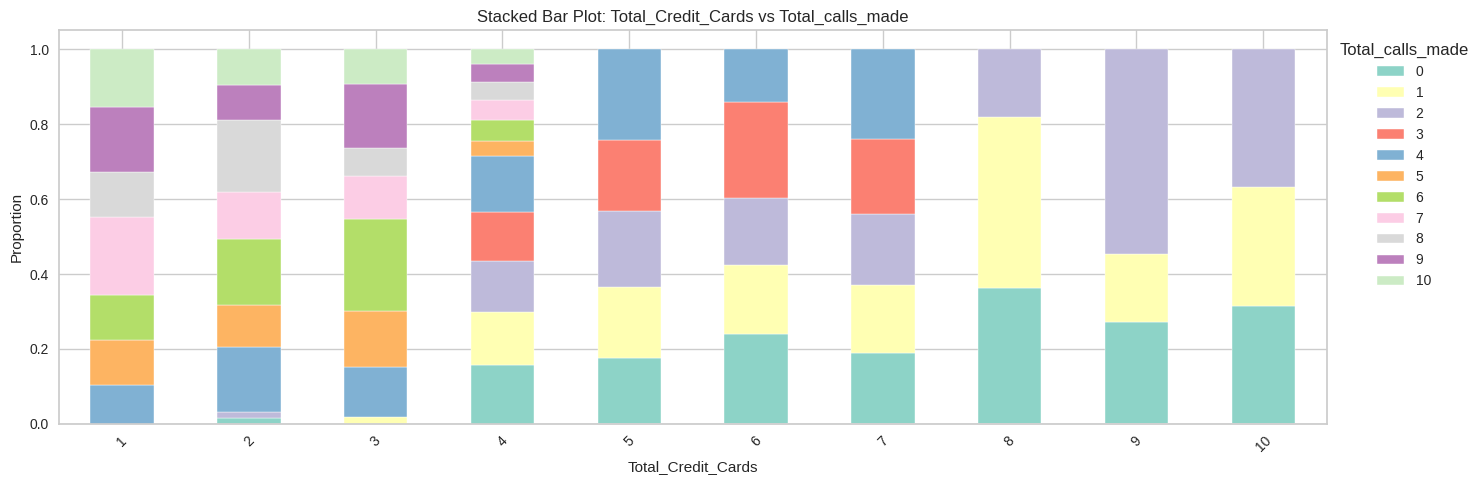

In [ ]:
stacked_barplot_custom(df1, "Total_Credit_Cards", "Total_calls_made", palette='Set3')

**Observations on Distribution of Total Credit Cards by Total Calls Made:**

* Customers with **1, 2, or 3 credit cards make between four and ten calls** every year. There are very few 0-3 calls.

* Customers with **4 credit cards** had a high proportion of calls in the lower range **(0 to 4 calls per year)**, with very **few making more than four calls**.

* Customers with **5, 6, or 7 credit cards make zero to four calls** every year.  Almost no one in these groups places more than four calls.

* Customers with **8, 9, or 10 credit cards** are highly concentrated in the lowest call range (**0 to two calls** per year).  None makes more than four calls.

* Overall, there is a clear trend: **as the number of credit cards grows, the number of bank calls declines** significantly.  The most active callers have the fewest cards (1-3).

* Customers with a large number of cards **(8-10) are the least likely to contact the bank via calls**, implying that they are either extremely self-sufficient or use other platforms for assistance.

**Distribution of Total_visits_bank vs Total_visits_online**

Total_visits_bank     0    1    2   3   4   5  All
Total_visits_online                               
0                     0    0   39  32  31  39  141
1                     3    2   26  32  23  21  107
2                    19   15   45  35  36  35  185
3                    16   11   16   0   0   0   43
4                    22   30   16   0   0   0   68
5                    16   24   14   0   0   0   54
6                     0    1    0   0   0   0    1
7                     2    5    0   0   0   0    7
8                     3    3    0   0   0   0    6
9                     1    3    0   0   0   0    4
10                    2    4    0   0   0   0    6
11                    2    3    0   0   0   0    5
12                    3    3    0   0   0   0    6
13                    4    1    0   0   0   0    5
14                    0    1    0   0   0   0    1
15                    4    6    0   0   0   0   10
All                  97  112  156  99  90  95  649
-------------------------------

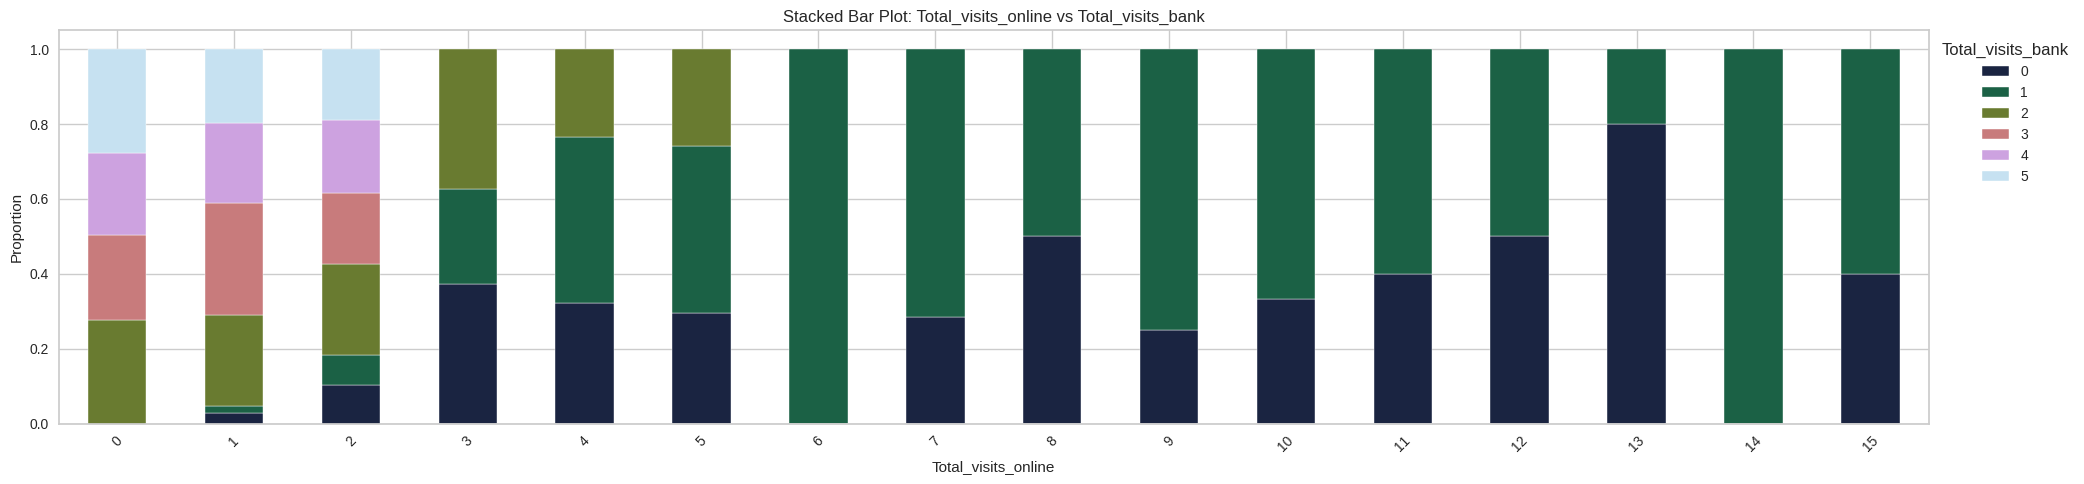

In [ ]:
stacked_barplot_custom(df1,"Total_visits_online","Total_visits_bank", palette='cubehelix')

**Observations on Distribution of Total_visits_bank vs Total_visits_online:**

* Clients with **0 online visits typically come to the bank two, three, four, or five times year**.  Few people with no online visits have made one or more bank visits.

* Customers with **one or two online visits have a distribution over all bank visit frequencies (0 to 5)**, with concentrations at two visits.

* Customers who make **three or more online visits (3 to 15) visit the bank only once or twice a year**.  None of these consumers went to the bank three, four, or five times.

* There is a clear inverse relationship: customers who spend a lot of time online (3+ visits) spend very little time in person at the bank (0-2 visits), and vice versa.

* This implies a strong platform preference: clients typically utilise either digital channels or in-person services, but not both.  The bank's customers are divided into two groups: digitally active and branch-active.

**Distribution of Total_visits_bank vs Total_calls_made**

Total_visits_bank   0    1    2   3   4   5  All
Total_calls_made                                
0                   7   10   19  21  20  19   96
1                   6   10   14  19  19  20   88
2                   8   11   20  18  18  15   90
3                   1    0   18  21  22  20   82
4                   9   15   28  20  11  21  104
5                   9   10    9   0   0   0   28
6                  10   14   15   0   0   0   39
7                  12   12   10   0   0   0   34
8                  11    9   10   0   0   0   30
9                  12   12    8   0   0   0   32
10                 12    9    5   0   0   0   26
All                97  112  156  99  90  95  649
----------------------------------------------------------------------------------------------------


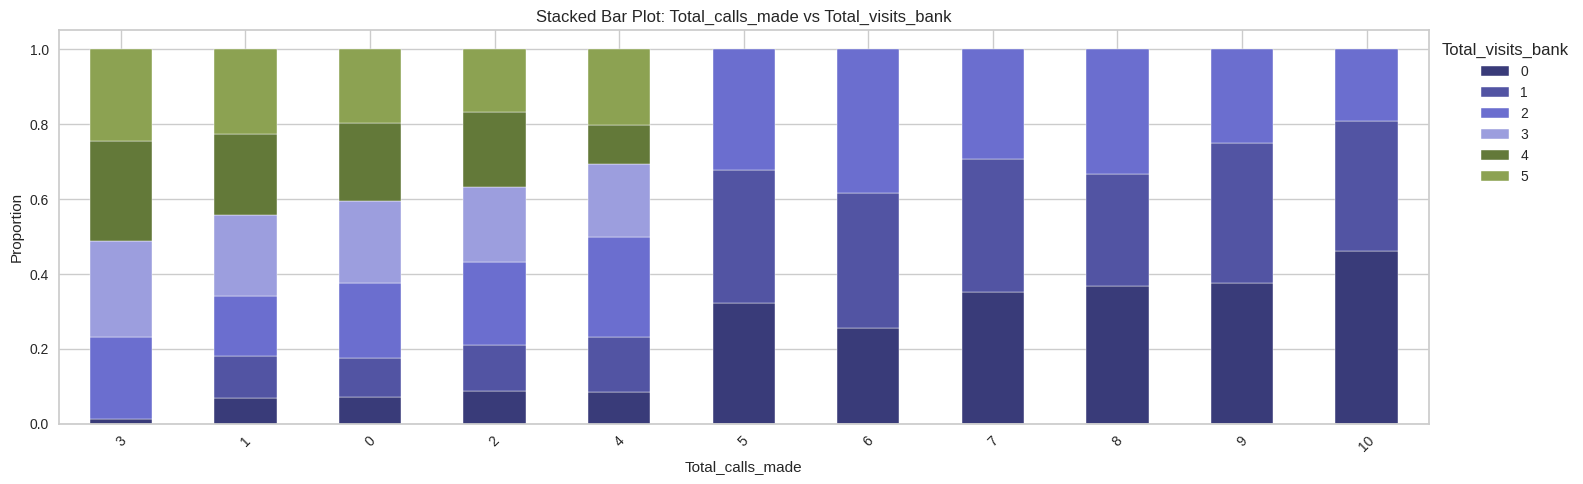

In [ ]:
stacked_barplot_custom(df1,"Total_calls_made","Total_visits_bank", palette='tab20b')

**Observations on Distribution of Total_visits_bank vs Total_calls_made:**

* Customers who **visit the bank three, four, or five times per year make relatively few phone calls (0 to 4)**.  Only a few make more than four calls.

* Customers who **visit the bank 0 to 2 times per year make calls of varying frequencies (0 to 10 calls)**.  This group includes all clients who make a large number of calls (5-10).

* There is a clear negative relationship: **customers who visit the bank frequently (3-5 times) have lower call centre activity**.

* Customers with **limited in-person bank engagement (0-2 visits) exhibit a wide range of call center activity**, including the highest levels.

* This suggests that customers who frequently visit branches do not need to contact the support centre, most likely because they fix issues in person.  On the contrary, people who infrequently visit branches are the primary users of call center, with call volumes ranging from low to very high.

**Distribution of Total_visits_online vs Total_calls_made**

Total_calls_made      0   1   2   3    4   5   6   7   8   9  10  All
Total_visits_online                                                  
0                    30  25  27  26   33   0   0   0   0   0   0  141
1                    30  16  18  18   23   0   0   1   1   0   0  107
2                    20  32  27  37   26   8   9   9   5   4   8  185
3                     0   0   0   0    6   5   7   9   5   3   8   43
4                     0   0   0   0   10   6  15   9  10  13   5   68
5                     0   0   0   0    6   9   8   6   9  11   5   54
6                     0   1   0   0    0   0   0   0   0   0   0    1
7                     3   2   2   0    0   0   0   0   0   0   0    7
8                     2   3   1   0    0   0   0   0   0   0   0    6
9                     0   2   2   0    0   0   0   0   0   0   0    4
10                    1   2   2   0    0   0   0   0   0   1   0    6
11                    3   0   2   0    0   0   0   0   0   0   0    5
12                  

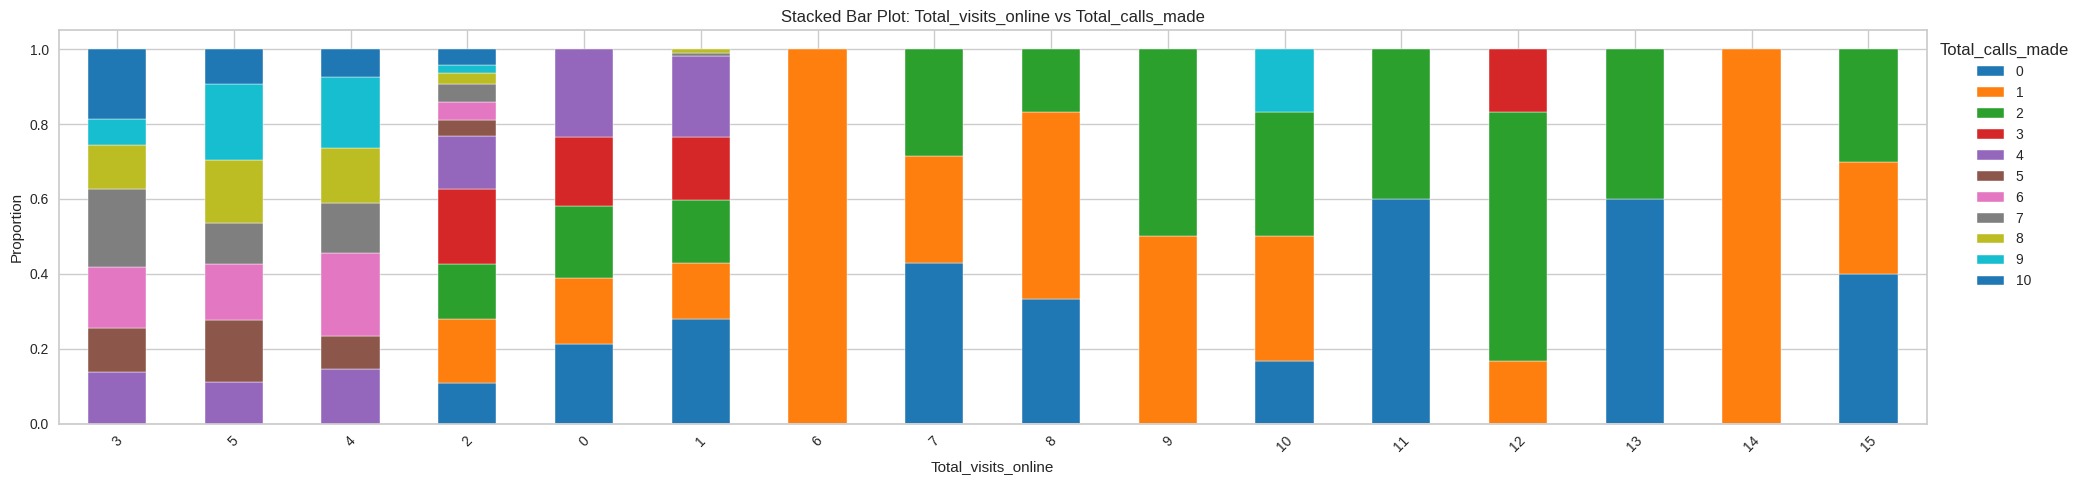

In [ ]:
stacked_barplot_custom(df1,"Total_visits_online","Total_calls_made", palette='tab10')

**Observations on Distribution of Total_visits_online vs Total_calls_made:**

* Customers that make **zero, one, or two online visits are concentrated in the low-to-moderate call range (0 to four calls)**.  According to the data, very few to none of the customers in these online visit groups made five or more calls.

* Customers that make **three, four, or five online visits are the most active callers**.  They are present across every category of **call volumes (0 to 10)**, and they account for **a majority of customers that make a large number of calls (5-10)**.

* Customers with 6 or more online visits **(6 to 15) exhibit a distinct pattern: they mainly make a small number of calls (0 to 4)**, which is similar to the low online visit group.

* This results in a curvilinear (inverted U) relationship: moderate online users (3-5 visits) are the most frequent callers, whereas low online users (0-2) and extremely high online users (6-15 visits) are light callers.

* The data suggests, there are two categories of customers that are digitally engaged: those who use online and phone channels frequently (three to five online visits) and those who skip call centres and are nearly entirely digital (6 to 15 online visits).

##**MULTIVARIATE ANALYSIS**

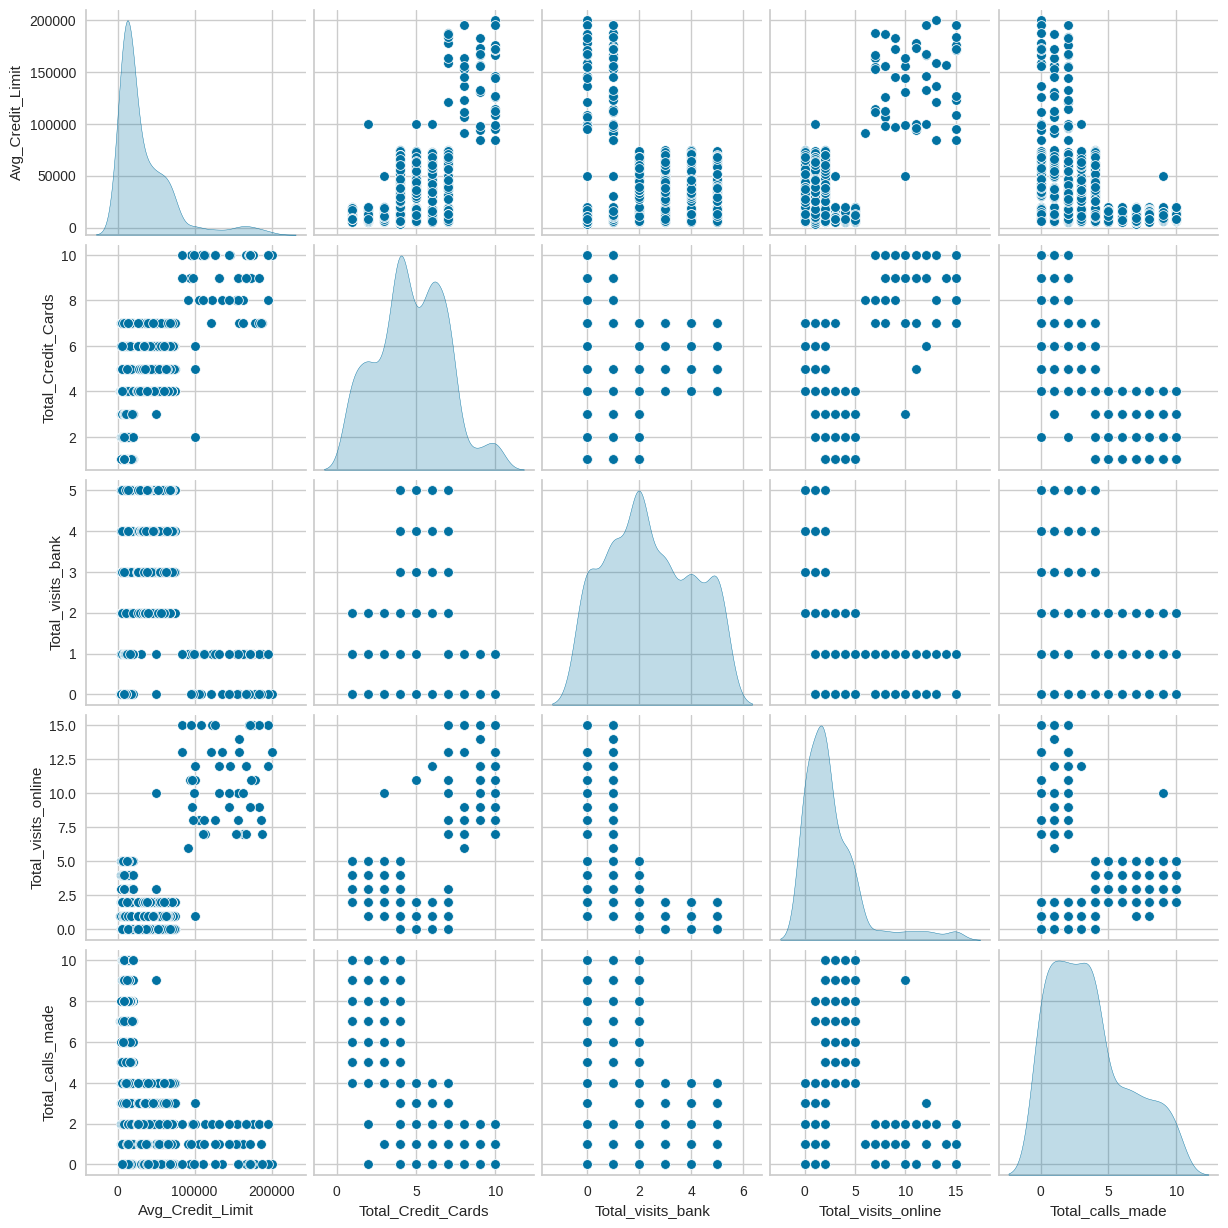

In [ ]:
# Select only numerical columns
num_cols = df1.select_dtypes(include='int64').columns

# Create pairplot with numerical columns
sns.pairplot(data=df1[num_cols], diag_kind='kde')
plt.show()

**Observations on pair plot:**

* ***Diagonal Plots (KDE)***
  * These illustrate the distribution of each individual variable.  We observe that ***Avg_Credit_Limit and Total_visits_online*** are **right-skewed**, whereas the others ***(Total_Credit_Cards, Total_visits_bank, and Total_calls_made)*** appear more symmetrical or slightly skewed.  This is consistent with the univariate study performed earlier.
*  **Off-Diagonal Plots (Scatter Plots)** These show the relationship between pairs of variables.
     * ***Avg_Credit_Limit*** appears to have a positive correlation with ***Total_Credit_Cards and Total_Visits_Online***, since the values increases as these variables increases.
     * ***Avg_Credit_Limit*** appears to have a negative correlation with ***Total_visits_bank and Total_calls_made***, with the points decreasing as these variables increases.
     * ***Total_visits_bank*** and ***Total_visits_online*** have an obvious negative correlation, generating two different clusters, showing that clients visit the bank in person or online but not both regularly. ***Total_calls_made*** has a negative correlation with ***Total_visits_bank*** and ***Total_Credit_Cards***.  The other relationships appear to be weaker or more scattered.


**Conclusion:**
* In general, the pairplot illustrates possible clusters or patterns in the data based on the credit attributes and different platforms customers use to communicate with the bank, as well as visually supports the correlations seen in the heatmap.
* Total_calls_made seems to be bimodal.
* Total_Credit_Cards seems to have 4 distinct peaks.
* Total_visits_bank also has multiple peaks.
* Avg_Credit_Limit and Total_visits_online have similar distributions.

##**Overall EDA Insights**

**Customer Segmentation by Engagement & Credit**

* Based on their preferred methods of communication, customers are clearly divided into groups; **some prefer to visit banks in person, while others primarily use digital channels** (phone calls and internet visits).
* A **few customers utilise both platforms** extensively at the same time.

**Distribution of the Credit Limit**

* The distribution of average credit limits skews to the right, with the majority of customers having limits between **10,000 and 50,000** and a tiny minority having limits as high as **200,000**.
* The typical credit limit is considerably raised by these **high-value outliers**.

**Credit Limit vs Credit Cards**

* The average credit limit and the number of credit cards are strongly positively correlated.
* **Customers who own more than seven cards typically have significantly larger credit limits**, which vary frequently but are always high.


**Platform Usage Patterns: Bank vs. Online Visits**

* A substantial **negative correlation** occurs, indicating two separate customer groups: **branch-focused and digitally** active.
* Customers with **more online visits typically have greater credit limits**.
 Heavy online users (10-15 visits per year) are the most reliable group.


**Calls vs Credit Limit**

* A **larger frequency of calls correlates to lower average credit limits**, implying that lower-credit customers rely more on call centres, whilst better-credit customers choose other channels or require less support.


**Outliers and use extremes**

* Outliers exist for both average credit limits **(100,000-200,000) and online visits (10-15 visits)**.
* A few customers make no visits (bank or online) but maintain large credit limits, indicating that they depend on alternate or digital support platforms.


**Cluster Tendencies**

* Customers with **1-3 credit cards are more likely to make frequent calls** and are less likely to be of high value.
* Customers with **7-10 cards have large credit limits, use online platforms**, and rarely call or visit the bank.
* Mid-range cardholders (4-6 cards) participate in the most balanced manner across all channels.

**Overall Behavioural Insights
 High-credit customers**

* More credit cards, increased online activity, less phone calls and bank visits.
* Low-credit customers:  Fewer credit cards, increased reliance on call centres, and more branch visits.
* The data show a distinct digital versus offline gap, with creditworthiness heavily favouring the digitally engaged customers.

#**DATA PREPROCESSING**

##**Missing Values & Treatment**

In the Data Overview section, we already checked the missing values and we concluded tha there are **no missing values in our dataset**. This suggest our dataset do not require any imputing techniques. Hence, preserving the data integrity.

##**Duplicate Values & Treatment**

In the Data Overview section, we already checked the duplicate values, and we found 11 duplicate values. **Duplicate rows accounted for only 1.67% of our dataset**; deleting them will have no major impact on the overall size of our dataset while significantly improving the quality and reliability of our analysis. Hence, we dropped the duplicate rows, therefore are **no duplicates in our dataset**. This indicates data is fit to do further analysis.

We also **dropped Sl_No and Customer Key columns** as they were unique identifiers.

##**Outlier Detection & Treatment**

###**Outlier Detection using Box plot**

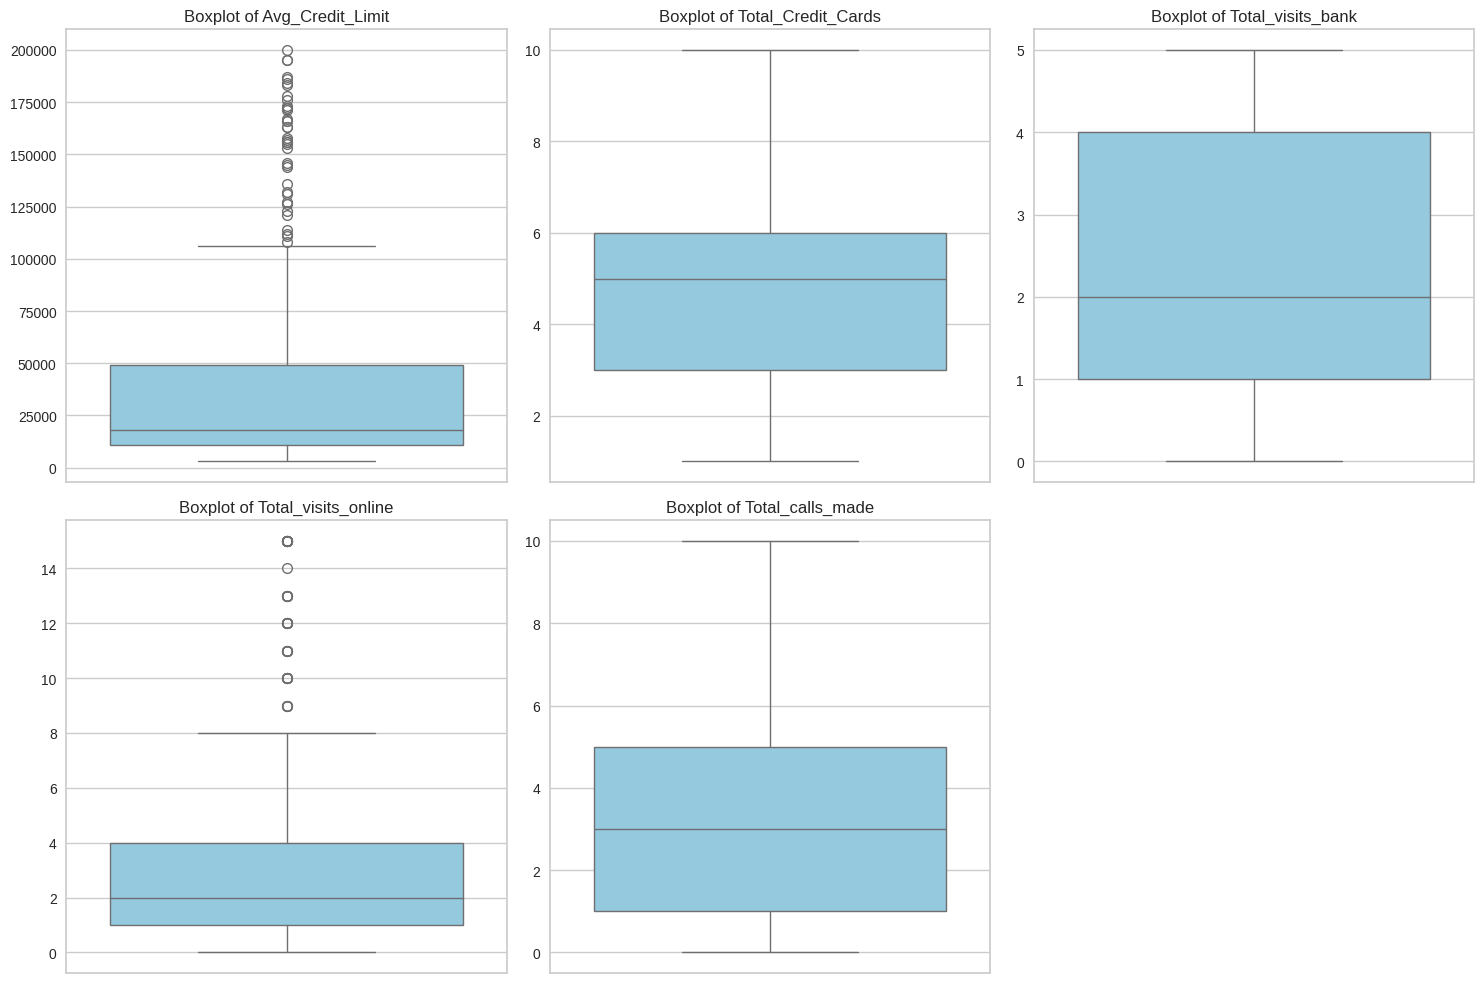

In [ ]:
# Create boxplots
plt.figure(figsize=(15, 10)) # figure size for two rows

for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i) # subplot layout to 2 rows and 3 columns
    sns.boxplot(y=df1[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

**Outlier Detection using IQR method**

In [ ]:
# Function to calculate IQR bounds
def find_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check each column
for col in num_cols:
    lower_bound, upper_bound = find_iqr_bounds(df[col])
    outlier_count = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    print(f"{col}:")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {outlier_count} ({(outlier_count/len(df))*100:.2f}%)\n")

Avg_Credit_Limit:
  Lower bound: -47000.00, Upper bound: 105000.00
  Number of outliers: 39 (5.91%)

Total_Credit_Cards:
  Lower bound: -1.50, Upper bound: 10.50
  Number of outliers: 0 (0.00%)

Total_visits_bank:
  Lower bound: -3.50, Upper bound: 8.50
  Number of outliers: 0 (0.00%)

Total_visits_online:
  Lower bound: -3.50, Upper bound: 8.50
  Number of outliers: 37 (5.61%)

Total_calls_made:
  Lower bound: -5.00, Upper bound: 11.00
  Number of outliers: 0 (0.00%)



**Obserrvations:**

* We can observe that there are **several outliers Avg_Credit_Limit (150000 to >20,0000)** accounting for **5.91%** of data and **Total_visits_online (9-15)** accounting for **5.61%** of the dataset.

* This Suggests that some customers have high credit limits, they might be high value customers and few customers make more online visits to bank than offline, they may be high-engagement users; good candidates for app-based or internet banking promotions.

* There are **no outliers for columns: Total_credit_cards, Total_calls_made** and Total_visits_bank, suggest most customers behave consistently.


###**Outlier Treatment**

**Average Credit Limit (5.91% outliers)**
* These outliers are customers with extremely high credit limits, which are useful in identifying high-value groups and sales chances.  
* Removing them could result in the loss of critical information on premium customers.

**Total visits online (5.61% outliers)**
* Outliers here indicate customers who have a high level of online involvement, which is going to be a crucial segment for digital marketing and service strategies.  
* Removing them would mean losing essential behavioural patterns.

* These extreme values in any feature disproportionately dominate these distance calculations, significantly distorting the resulting clusters.  This would allow the algorithm to create clusters based mostly on these outliers, concealing the underlying patterns found in the rest of the data.

* To maintain data integrity, removing these entries would result in the loss of critical information about a major consumer segment (~5%). Hence, **we will not remove these outliers but treat it as clustering technique is sensitive to outliers.**

* To reduce algorithmic sensitivity, **winsorization (capping data at the 95th percentile) will be performed**.  This approach mitigates the excessive impact of these outliers on distance calculations while keeping them in the dataset.  This enables the algorithm to identify these customers as a unique "premium" class without jeopardising the overall clustering algorithm.


In [ ]:
from scipy.stats.mstats import winsorize
# Cap 'Avg_Credit_Limit' and 'Total_visits_online'
# limits=[0.05, 0.05] replaces values below the 5th percentile with the 5th percentile value,
# and values above the 95th percentile with the 95th percentile value.
df1['Avg_Credit_Limit'] = winsorize(df1['Avg_Credit_Limit'], limits=[0.05, 0.05]).data
df1['Total_visits_online'] = winsorize(df1['Total_visits_online'], limits=[0.05, 0.05]).data

**Checking Duplicates and shape after winzorising**

In [ ]:
# Check for duplicate rows (all columns identical)
print("Number of duplicate rows after winsorization:", df1.duplicated().sum())

# Check shape
print("Shape after winsorization:", df1.shape)

# Check if any new rows were added by comparing indices
print("Index range:", df1.index.min(), "to", df1.index.max())

Number of duplicate rows after winsorization: 10
Shape after winsorization: (649, 5)
Index range: 0 to 648


**Observations:**

* We see 10 duplicates rows.
* Let's further investigate.



In [ ]:
# Checking duplicates
duplicates = df1[df1.duplicated(keep=False)]

print("Number of 'duplicate' rows:", len(duplicates))
print("Are these rows TRULY identical across ALL 5 features?")
print(duplicates.head(10))

# Check if any two rows are identical across ALL columns
true_duplicates = df1[df1.duplicated(subset=df1.columns, keep=False)]
print("Rows that are truly identical across ALL features:", len(true_duplicates))

Number of 'duplicate' rows: 19
Are these rows TRULY identical across ALL 5 features?
     Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
124              6000                   2                  2   
170              6000                   2                  2   
306              6000                   4                  5   
367              6000                   4                  5   
601            123000                   9                  1   
603            123000                   8                  1   
604            123000                   9                  1   
606            123000                   8                  0   
608            123000                   7                  0   
610            123000                   9                  1   

     Total_visits_online  Total_calls_made  
124                    3                 7  
170                    3                 7  
306                    0                 1  
367                    0      

**Observations:**

* We applied Winsorization previously to mitigate the disproportionate impact of extreme outliers on distance-based clustering techniques like as K-Means, which are sensitive to huge value differences. By capping high values, we tried to minimise their magnitude while keeping the data points in our analysis.

* However, **as a result of this capping, 10 duplicate rows emerged, involving a total of 19 rows in duplicate sets.**, in which numerous original data points are mapped to the same capped value and are identical across other features.

* While deleting these duplicates will reduce the actual count of unique original customers in the clustering input. but, **deleting those rows is necessary and an acceptable trade-off to ensure that each unique combination of processed feature values is represented only once**.

* This **prevents the clustering algorithm from being artificially skewed** by identical points in the feature space, resulting in more robust and reliable cluster formations based on the data's underlying patterns.

* Therefore, we will **delete these duplicates** again introduced by capping.

* **So, far in total, 4.6% i.e. 1.67% (initial dataset df) + 2.93% (from df1) of the original rows owing to initial duplication and winsorization, which is generally regarded acceptable for this type of analysis.**


In [ ]:
# Ensure df1 is cleaned before creating df2
if df1.duplicated().sum() > 0:
    print("Warning: Duplicates found in df1 before creating df2. Dropping duplicates in df1.")
    df1.drop_duplicates(inplace=True)
    print("Number of duplicate rows in df1 after re-dropping:", df1.duplicated().sum())


#creating a copy of df1 in df2 to avoid any accidental change while creating new feature
df2 = df1.copy()

# Verify that df2 is created from a clean df1
print("\nNumber of duplicate rows in df2 immediately after creation:")
print(df2.duplicated().sum())

Number of duplicate rows in df1 after re-dropping: 0

Number of duplicate rows in df2 immediately after creation:
0


In [ ]:
df2.shape

(639, 5)

**Observations:**

* There are **no duplicate rows** in our dataset after removing them.
* Our data is clean to be used for analysis.
* After removing duplicates rows we have **now 639 rows and 5 columns**.

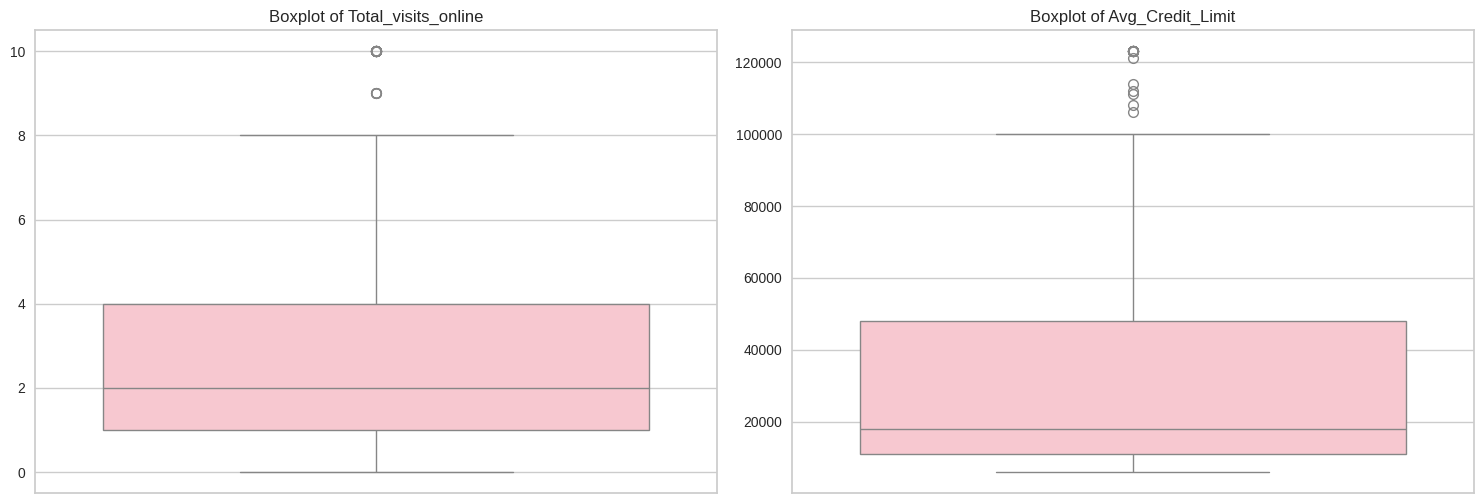

In [ ]:
# Create boxplots
plt.figure(figsize=(15, 10)) # Adjusted figure size for two rows
cols = ['Total_visits_online', 'Avg_Credit_Limit']
for j, col1 in enumerate(cols, 1):
    plt.subplot(2, 2, j) # Changed subplot layout to 2 rows and 3 columns
    sns.boxplot(y=df2[col1], color='pink')
    plt.title(f'Boxplot of {col1}')
    plt.ylabel('')

plt.tight_layout()
plt.show()


**Observations on Outliers Detections again after Winzorising:**

* We observe **few remaining outliers**.
* After Winsorization, certain points can still be detected as outliers using boxplots. This is **normal and acceptable**.
* The **goal was** not to eliminate all statistical outliers, but rather to **lower their magnitude to a level that allowed the clustering algorithm to function properly**.  
* The **remaining outliers will be accurately assigned to their respective high-value clusters during analysis**.

##**Feature Engineering**


###**New Features**

**1.New Feature - Credit_Per_Card**:

Our bivariate analysis reveals a significant correlation (r=0.61) between Avg_Credit_Limit and Total_Credit_Cards. Boxplots demonstrate increasing medians and spreads as card count rises (e.g., median ~125,000 for 10 cards vs. <20,000 for 1-2 cards). This shows that **'credit density' is a major segment driver**, for example: clients with high per-card limits may be premium (target for upsell campaigns), whereas those with low limits may be entry-level (acquisition targets).  It addresses the problem statement by assisting with segmentation based on "spending patterns".  So, we'll create the **Credit_Per_Card feature, which is obtained by dividing the average credit limit by the entire number of credit cards**.  It normalises the credit limit to a "per-card" basis, displaying how much credit the customer receives on average for each card held.

In [ ]:
#creating a copy of df2 in df3 to avoid any accidental change while creating new feature
df3 = df2.copy()

In [ ]:
# creating new feature Credit_Per_Card
df3['Credit_Per_Card'] = df3['Avg_Credit_Limit'] / df3['Total_Credit_Cards']

**2. New feature - Total_Interactions:**

Our EDA study shows a range of engagement levels.  We will develop a new feature called **'Total_Interactions' that will capture an overall "communication level," which is critical for operations** (e.g., high-engagement segments require faster query resolution to improve customer experience) and marketing (e.g., low-engagement segments may respond to low-touch digital campaigns). **We will develop this new feature by combining Total_visit_bank, Total_visit_online, and Total_calls_made.**

In [ ]:
# Create the combined feature
df3['Total_Interactions'] = (
    df3['Total_visits_bank'] +
    df3['Total_visits_online'] +
    df3['Total_calls_made'])

**3. New feature - Digital_Engagement_Ratio:**

Our heatmap in the **EDA section shows strong negative correlations between physical bank visits and digital channels**(e.g., bank vs. online r=-0.55; bank vs. calls r=-0.50), with clear inverse patterns (e.g., high online users rarely visit branches more than twice; moderate online users (3-5 visits) are frequent callers). **The new feature 'Digital_Engagement_Ratio' quantifies "channel preference" (0 = fully physical/branch-loyal; 1 = fully digital/phone-heavy)**, which directly addresses service model upgrades (e.g., prioritise digital support for high-ratio segments to reduce calls) and marketing (e.g., target low-ratio segments with in-branch promotions). This feature is **calculate by adding digital components (Total_visits_online + Total_calls_made) together and then divided by the Total_Interactions +1 (a minor constant is added to the denominator to gracefully manage low/zero total interactions)**. The +1 in the denominator avoids division by zero for customers with zero total interactions (e.g., self-sufficient users).

In [ ]:
# Create the ratio
digital_numerator = df3['Total_visits_online'] + df3['Total_calls_made']
df3['Digital_Engagement_Ratio'] = digital_numerator / (df3['Total_Interactions'] + 1)

# Clip to [0,1] if any edge cases - The Range: 0 to ~1 (e.g., all digital = 1; all physical = 0)
df3['Digital_Engagement_Ratio'] = np.clip(df3['Digital_Engagement_Ratio'], 0, 1)

###**Data overview after creating new features**

**Checking Top 5 rows**

In [ ]:
df3.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_Per_Card,Total_Interactions,Digital_Engagement_Ratio
0,100000,2,1,1,0,50000.000000,2,0.333333
1,50000,3,0,10,9,16666.666667,19,0.950000
2,50000,7,1,3,4,7142.857143,8,0.777778
3,30000,5,1,1,4,6000.000000,6,0.714286
4,100000,6,0,10,3,16666.666667,13,0.928571


**Observations:**

* We have successfully added new features (columns) in our dataset.

**Checking Shape**

In [ ]:
df3.shape

(639, 8)

Observations:

* We have now **639 rows** and **8 colmuns** ( previously we had 5 columns)

**Checking Data types**

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 639 entries, 0 to 648
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Avg_Credit_Limit          639 non-null    int64  
 1   Total_Credit_Cards        639 non-null    int64  
 2   Total_visits_bank         639 non-null    int64  
 3   Total_visits_online       639 non-null    int64  
 4   Total_calls_made          639 non-null    int64  
 5   Credit_Per_Card           639 non-null    float64
 6   Total_Interactions        639 non-null    int64  
 7   Digital_Engagement_Ratio  639 non-null    float64
dtypes: float64(2), int64(6)
memory usage: 44.9 KB


**Observations:**

* Our **new features are of integer data types**.

**Checking  null/ missing values**

In [ ]:
print("Missing/ null values are:")
df3.isnull().sum()

Missing/ null values are:


,0
Avg_Credit_Limit,0
Total_Credit_Cards,0
Total_visits_bank,0
Total_visits_online,0
Total_calls_made,0
Credit_Per_Card,0
Total_Interactions,0
Digital_Engagement_Ratio,0


**Observations:**

* There are **no missing values** in our new dataset.
* Our data is clean to be used for clustering.

**Checking Duplicates**

In [ ]:
print("Number of duplicate rows are:")
df3.duplicated().sum()

Number of duplicate rows are:


np.int64(0)

**Observations:**
* There are **no duplicate rows in our dataset**, our data is clean to be used for analysis.

**Checking Statistical Summary of New Features**

In [ ]:
eng_features = ['Credit_Per_Card', 'Total_Interactions', 'Digital_Engagement_Ratio']

print("Engineered features describe:")
print(df3[eng_features].describe())

# correlation check among new features (should be low; e.g., <0.7)
print("\nCorrelations among engineered features:")
print(df3[eng_features].corr())

Engineered features describe:
       Credit_Per_Card  Total_Interactions  Digital_Engagement_Ratio
count       639.000000          639.000000                639.000000
mean       6962.407780            8.442879                  0.565982
std        4941.083490            3.227931                  0.268823
min         857.142857            2.000000                  0.000000
25%        3000.000000            6.000000                  0.375000
50%        5857.142857            8.000000                  0.555556
75%        9816.666667           11.000000                  0.833333
max       50000.000000           19.000000                  0.950000

Correlations among engineered features:
                          Credit_Per_Card  Total_Interactions  \
Credit_Per_Card                  1.000000            0.036919   
Total_Interactions               0.036919            1.000000   
Digital_Engagement_Ratio         0.106973            0.787300   

                          Digital_Engagement_Ra

**Observations on the new features' statistical summary:**


*  **Credit_Per_Card**  (The average credit limit per card):  **The mean is 6,962 (standard deviation: 4,941), with a range of 857 to 50,000**.  The distribution is **right-skewed** (median = 5,857 < mean), showing a core of low-to-moderate credit users (**25th-75th percentile: 3,000-9,817**) and a tail of premium customers (high limit/few cards).  This successfully normalises credit density, preventing total limitations from dominating clustering.
  
*  **Total_Interactions** (sum of bank visits, online visits, and phone calls +1)  The **mean is 8.44 (standard deviation = 3.23)**, with a range of **2 to 19**.  The **near-symmetric distribution** (median = 8, IQR: 6-11) accurately depicts overall engagement levels.

* **Digital_Engagement_Ratio** (The share of digital channels in overall interactions):  **Mean = 0.566 (standard deviation = 0.269)**, limited between 0 and 0.95.  The moderate mean suggests a dataset **skewed towards physical-dominant customers** (e.g., 25th percentile = 0.375), but with significant variability (IQR: **0.375-0.833**), implying bimodal tendencies (physical vs. digital preferences).

###**EDA of New Features**

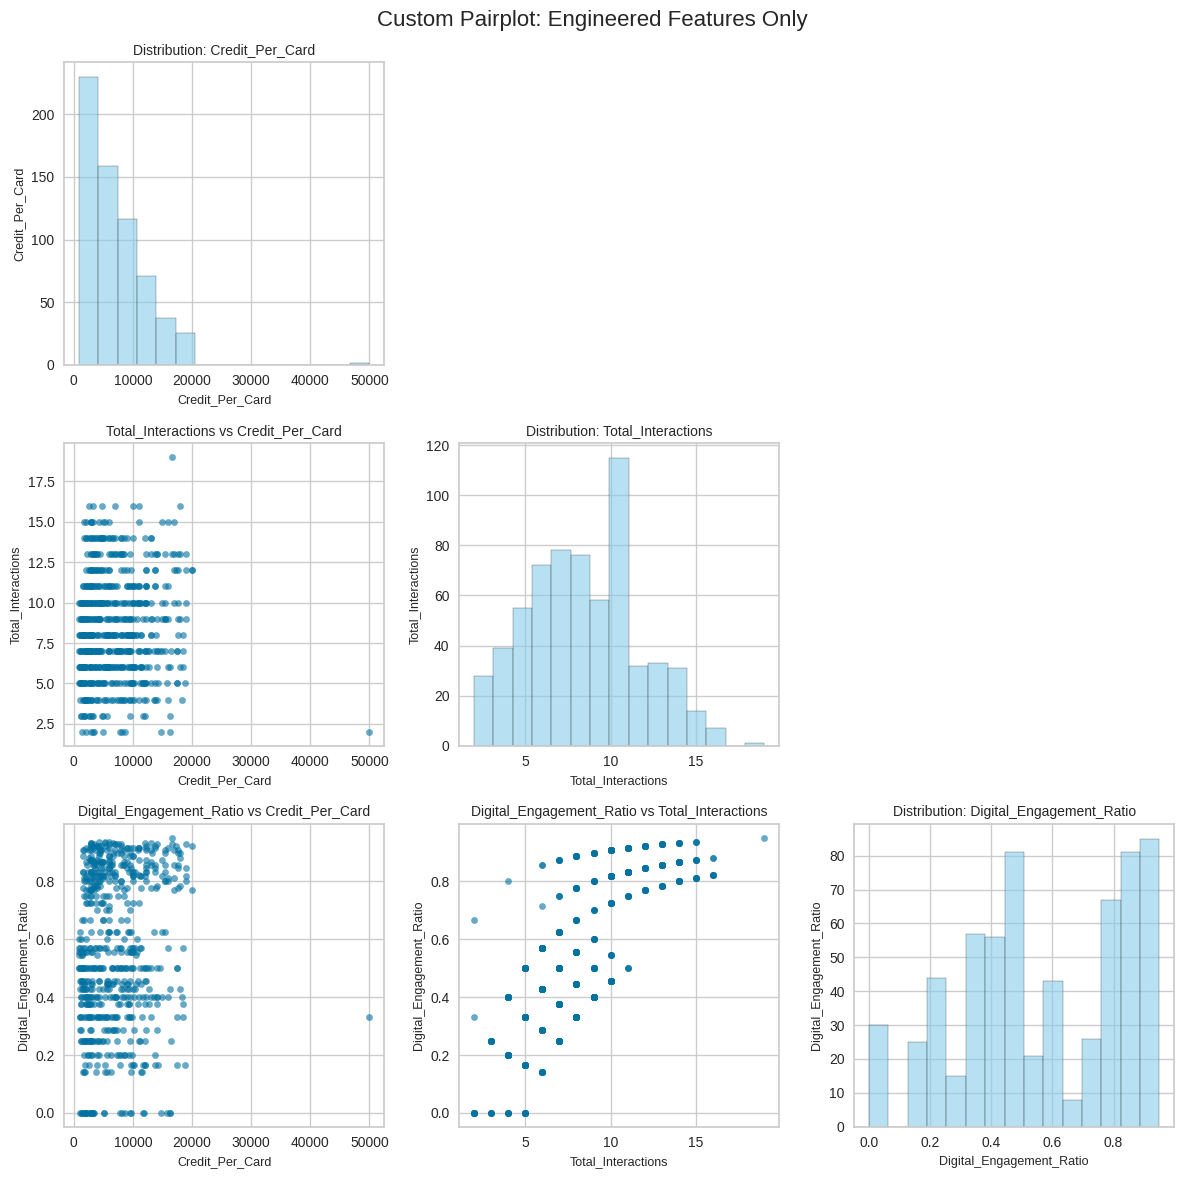

In [ ]:
n = len(eng_features)

# Create figure with subplots (3x3 grid, larger for labels)
fig, axes = plt.subplots(n, n, figsize=(12, 12))  # Square and spacious
fig.suptitle('Custom Pairplot: Engineered Features Only', fontsize=16, y=0.98)

# Flatten axes for easier looping
axes = axes.flatten()

# Loop to plot: Hist on diagonal, scatters below, blank above
for i in range(n):
    for j in range(n):
        if i == j:  # Diagonal: Histogram
            axes[i*n + j].hist(df3[eng_features[i]], bins=15, alpha=0.6, color='skyblue', edgecolor='black')
            axes[i*n + j].set_title(f'Distribution: {eng_features[i]}', fontsize=10)
            if i < n-1:  # No x-label on diag except bottom
                axes[i*n + j].set_xlabel(eng_features[i], fontsize=9)
            else:
                axes[i*n + j].set_xlabel(eng_features[i], fontsize=9)  # Bottom row gets x-label
            axes[i*n + j].set_ylabel(eng_features[i], fontsize=9)  # All diags get y-label

        elif i > j:  # Lower triangle: Scatterplot
            axes[i*n + j].scatter(df3[eng_features[j]], df3[eng_features[i]], alpha=0.6, s=20)
            axes[i*n + j].set_xlabel(eng_features[j], fontsize=9)
            axes[i*n + j].set_ylabel(eng_features[i], fontsize=9)
            axes[i*n + j].set_title(f'{eng_features[i]} vs {eng_features[j]}', fontsize=10)

        else:  # Upper triangle: Blank (corner effect)
            axes[i*n + j].axis('off')

# Adjust layout: Ample spacing for labels (left=0.15 for y-labels, etc.)
plt.subplots_adjust(left=0.15, right=0.95, top=0.92, bottom=0.08, wspace=0.25, hspace=0.25)
plt.tight_layout()  # Backup adjust

# Save and show
plt.savefig('eda_custom_pairplot.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()


**Observations:**

***Diagonal Plots (Histograms)***
 * ***Credit_Per_Card:***  The distribution is **heavily skewed to the right**, indicating that the majority of customers have a low credit limit per card, **below 10K per card**, with a large tail of customers who have significantly higher credit limits.  This is consistent with earlier findings.

* ***Total_Interactions:*** The distribution looks to be **broadly symmetrical**, with customers concentrated (**8-12**) in the middle of total interactions. Few customers cross **15** interactions.


* ***Digital_Engagement_Ratio:*** The **distribution is bimodal**, strong peaks near 0.0-0.2 and 0.6-0.9, with obvious peaks at both lower and higher digital engagement ratios, indicating a distinction between customers who prefer less and more digital involvement. There are very few customers are in-between (0.3-0.5).

***Off-Diagonal Plots (Scatter Plots)***

* ***Credit_Per_Card versus Total_Interactions:***  The plot reveals **no significant linear correlation**.  Customers with high or low credit-per-card use a variety of interactions. Outliers (extremely high credit per card) typically have low to moderate interactions, rather than very high.

* ***Credit_Per_Card vs Digital_Engagement Ratio:***  The scatter plot indicates **no significant relationship**. The digital engagement ratio is distributed over all credit-per-card values, implying that customers with both low and high credit-per-card values might be digital-first or branch-oriented.

* ***Total_Interactions vs. Digital_Engagement_Ratio:*** The plot demonstrate a strong positive association.  As the number of interactions increases, so does the digital engagement ratio. It is clustering around 0.6-0.9.  The spread of points illustrates that for a given level of overall engagement, there is still variations in the digital vs. non-digital split.

**Insights**

* The newly created features highlight several aspects of client behaviour, including credit intensity per card(Credit_Per_Card), overall activity (Total_Interactions), and channel preference (Digital_Engagement_Ratio).
* The bimodal character of Digital_Engagement_Ratio lends support to the idea of segmenting customers based on their choice for digital or physical channels.
* The relationships between these data, particularly the weaker correlations between Credit_Per_Card and the interaction features, indicate that these features can be used to classify various categories of customers based on a combination of creditworthiness and communication patterns/preferences.

###**Outlier Detection & Treatment for New features**

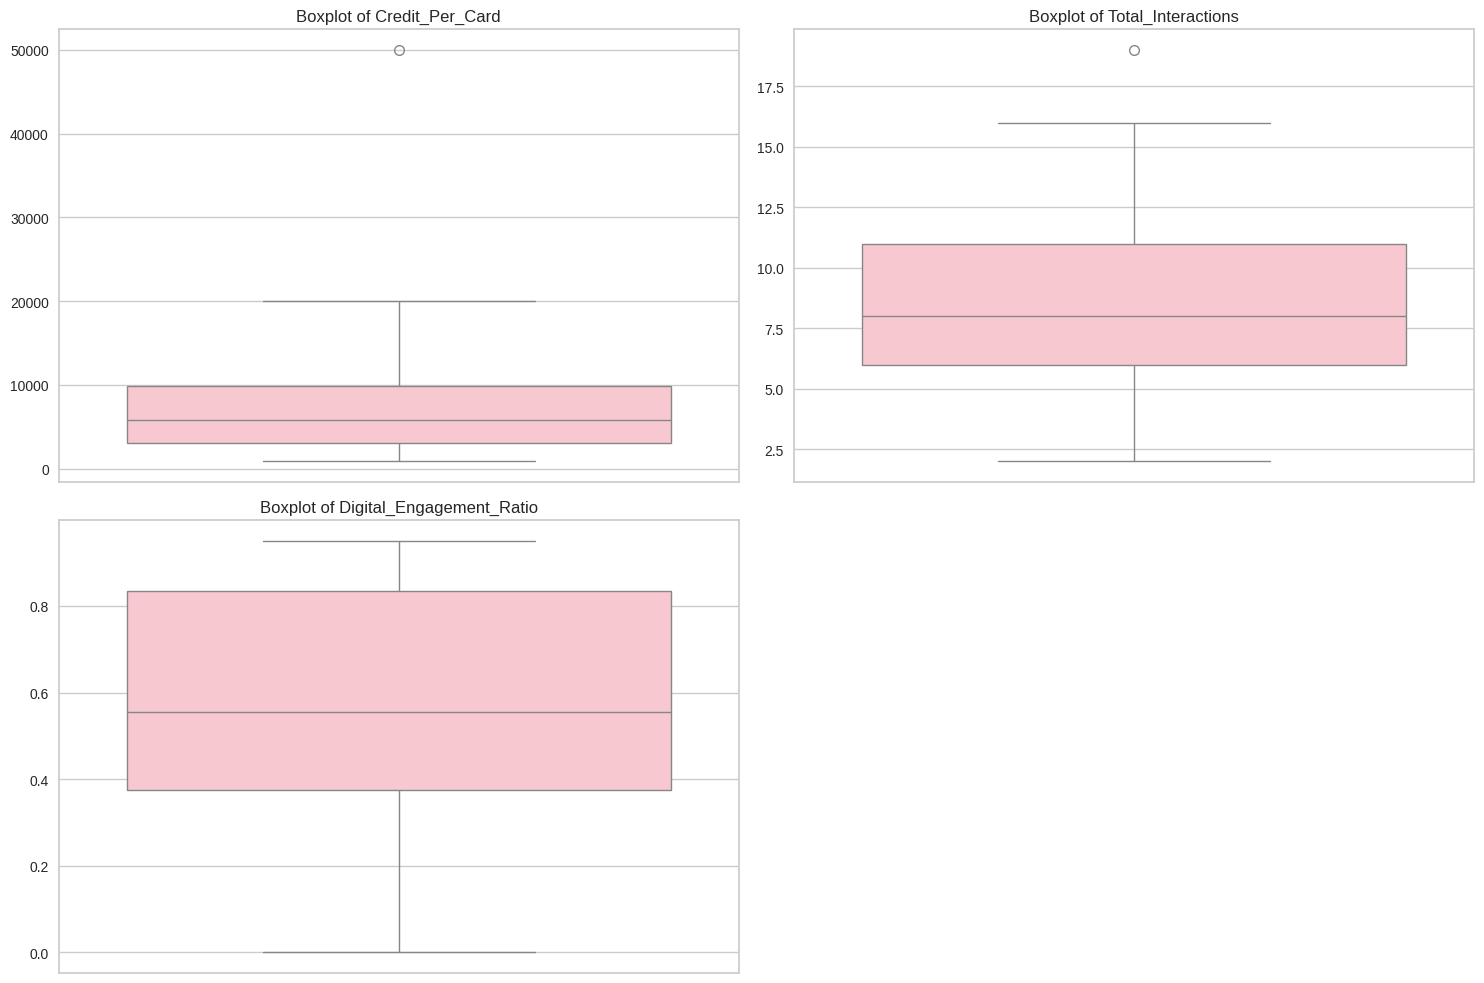

In [ ]:
# Create boxplots
plt.figure(figsize=(15, 10)) # Adjusted figure size for two rows
for j, col1 in enumerate(eng_features, 1):
    plt.subplot(2, 2, j) # Changed subplot layout to 2 rows and 3 columns
    sns.boxplot(y=df3[col1], color='pink')
    plt.title(f'Boxplot of {col1}')
    plt.ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Function to calculate IQR bounds
def find_iqr_bounds(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Check each column
for col in eng_features:
    lower_bound, upper_bound = find_iqr_bounds(df3[col])
    outlier_count = ((df3[col] < lower_bound) | (df3[col] > upper_bound)).sum()
    print(f"{col}:")
    print(f"  Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    print(f"  Number of outliers: {outlier_count} ({(outlier_count/len(df3))*100:.2f}%)\n") # Changed df to df3 for percentage calculation

Credit_Per_Card:
  Lower bound: -7225.00, Upper bound: 20041.67
  Number of outliers: 1 (0.16%)

Total_Interactions:
  Lower bound: -1.50, Upper bound: 18.50
  Number of outliers: 1 (0.16%)

Digital_Engagement_Ratio:
  Lower bound: -0.31, Upper bound: 1.52
  Number of outliers: 0 (0.00%)



**Observations:**

* We used a simple method (IQR) & box plot to detect outliers in the engineered features.

* ***Credit_Per_Card:*** 1 outlier **(0.16%)** above 20,042—most likely a high-end customer using premium cards.  There are no low outliers (values below -7,225 do not apply).  It displays VIP users, which is valuable.

* ***Total_Interactions:*** 1 outlier **(0.16%)** above 18.50—a highly engaged digital user (frequent online and phone calls).  There are no low outliers (values below -1.50 do not apply).  Helps to identify active customers.

* ***Digital_Engagement_Ratio:*** **0 outliers** (0.00%), a tidy range (-0.31 to 1.52).  There are no difficulties.

* **We will not treat these outliers**. Only two rows out of 639 (0.3%) are outliers, and **they are reasonable data of actual customers of bank**.  Keeping them offers useful details for grouping customers in K-means without negatively impacting the findings because the data is good and the modifications are minor.




###**Data Scaling**

**Let's scale our all numerical columns before proceeding for clustering.**

In [ ]:
# Scaling the data set using StandardScaler() before clustering
scaler = StandardScaler()
subset = df3.copy()  # creates a copy of the DataFrame df3
subset_scaled = scaler.fit_transform(subset) # Scaling all columns in df3

# Creating a dataframe from the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns) #converts the scaled NumPy array (subset_scaled) back into a pandas DataFrame.

# Display the first few rows of the scaled DataFrame
print("Scaled DataFrame Top 5 rows:")
subset_scaled_df.head()

Scaled DataFrame Top 5 rows:


,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_Per_Card,Total_Interactions,Digital_Engagement_Ratio
0,2.289672,-1.247140,-0.874171,-0.591742,-1.258789,8.716976,-1.997542,-0.866113
1,0.608720,-0.778913,-1.491404,3.197909,1.869687,1.965533,3.273116,1.429635
2,0.608720,1.093995,-0.874171,0.250403,0.131645,0.036549,-0.137310,0.788481
3,-0.063660,0.157541,-0.874171,-0.591742,0.131645,-0.194929,-0.757387,0.552110
4,2.289672,0.625768,-1.491404,3.197909,-0.215963,1.965533,1.412884,1.349860


#**MODEL BUILDING**

##**K-MEANS CLUSTERING**

###**Applying K-means & Elbow Plot**

K-Means Clustering is an unsupervised machine learning process that assigns data points to a predefined number of clusters (K) based on their similarity.  It is used for data segmentation and identifying patterns in unlabelled datasets, with applications ranging from customer segmentation to image compression and document classification. The algorithm iteratively allocates data points to the nearest cluster centroid, which is then moved to minimise the distance to its given points, thereby identifying inherent groupings within the data.

K-means Clustering Analysis
Number of Clusters: 2 	Average Distortion: 1.9819
Number of Clusters: 3 	Average Distortion: 1.6516
Number of Clusters: 4 	Average Distortion: 1.5719
Number of Clusters: 5 	Average Distortion: 1.4014
Number of Clusters: 6 	Average Distortion: 1.3305
Number of Clusters: 7 	Average Distortion: 1.2770
Number of Clusters: 8 	Average Distortion: 1.2246
Number of Clusters: 9 	Average Distortion: 1.1990
Number of Clusters: 10 	Average Distortion: 1.1508


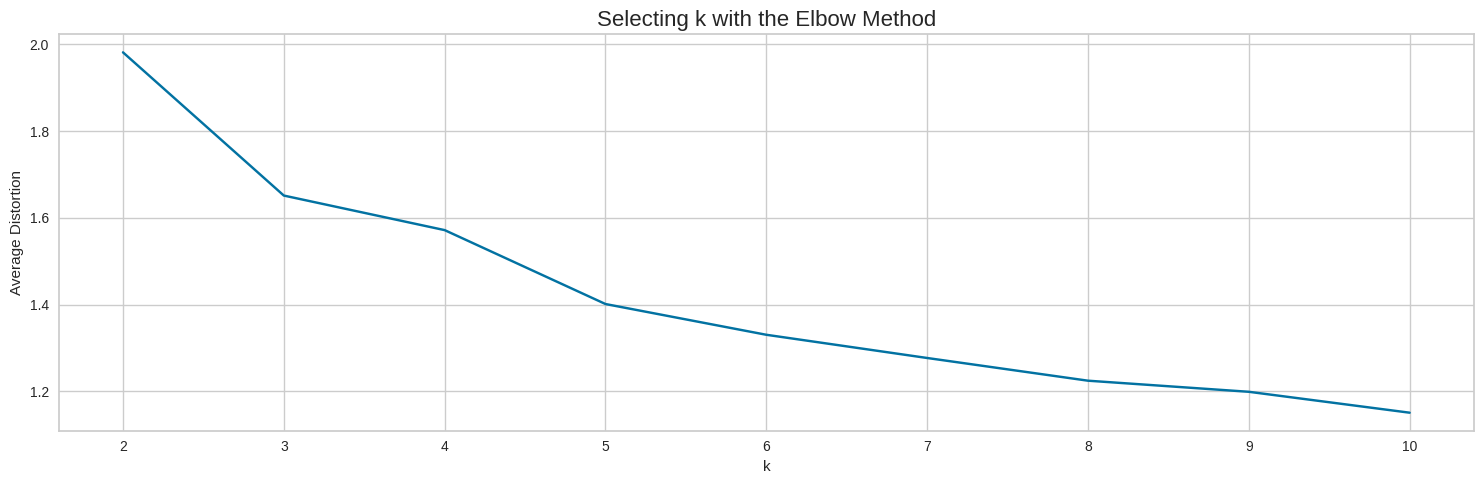

In [ ]:
# Applying k-means method
clusters = range(2, 11)
meanDistortions = []

print("K-means Clustering Analysis")
print("="*50)

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(subset_scaled_df)

    # Calculate distortion
    distortion = (
        sum(np.min(cdist(subset_scaled_df, model.cluster_centers_, "euclidean"), axis=1))
        / subset_scaled_df.shape[0]
    )
    meanDistortions.append(distortion)

    print(f"Number of Clusters: {k} \tAverage Distortion: {distortion:.4f}")

# Plot Elbow Curve
plt.figure(figsize=(15, 5))
# plot: Elbow Curve with Average Distortion
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=16)
plt.tight_layout()
plt.show()

**Let's do further analysis to determine the optimal value of k.**

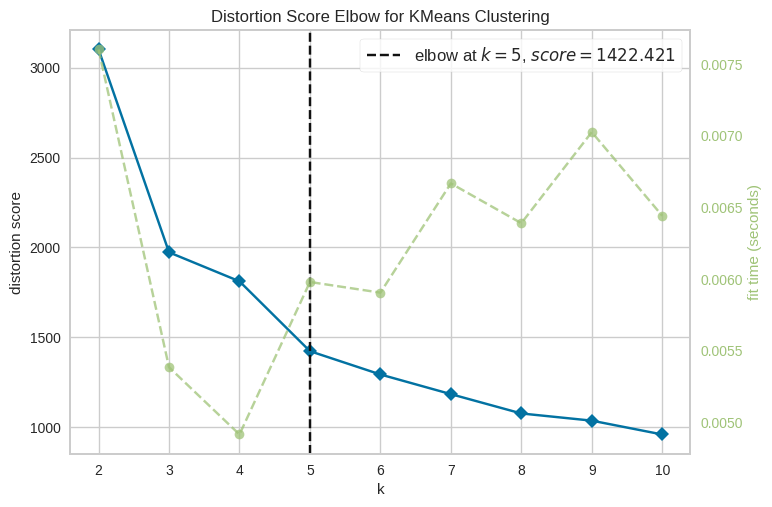

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(2, 11), timings=True)
visualizer.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer.show();  # finalize and render figure

**Observations:**
* The appropriate value of **k from the elbow curve seems to be 4 or 5**.
* The visualizer plot also confirmed the optimal value of **k = 5 with distortion score = 1422.421**


###**Checking Silhouette Scores**

**Silhouette Scores**

For n_clusters = 2, the silhouette score is 0.40658421129340794)
For n_clusters = 3, the silhouette score is 0.47448335027610444)
For n_clusters = 4, the silhouette score is 0.33625533712780775)
For n_clusters = 5, the silhouette score is 0.2908809672940428)
For n_clusters = 6, the silhouette score is 0.2559854054534955)
For n_clusters = 7, the silhouette score is 0.26256061276449694)
For n_clusters = 8, the silhouette score is 0.2552784927056393)
For n_clusters = 9, the silhouette score is 0.2426522655802093)
For n_clusters = 10, the silhouette score is 0.24120753515790863)


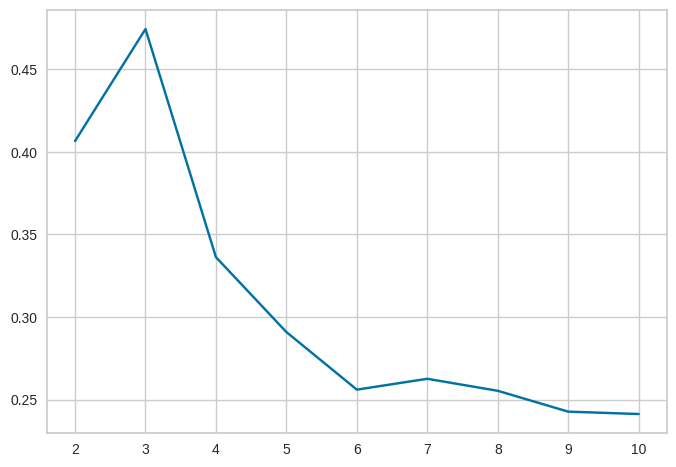

In [ ]:
sil_score = []
cluster_list = range(2, 11)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(subset_scaled_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {})".format(n_clusters, score))

plt.plot(cluster_list, sil_score)
plt.show()

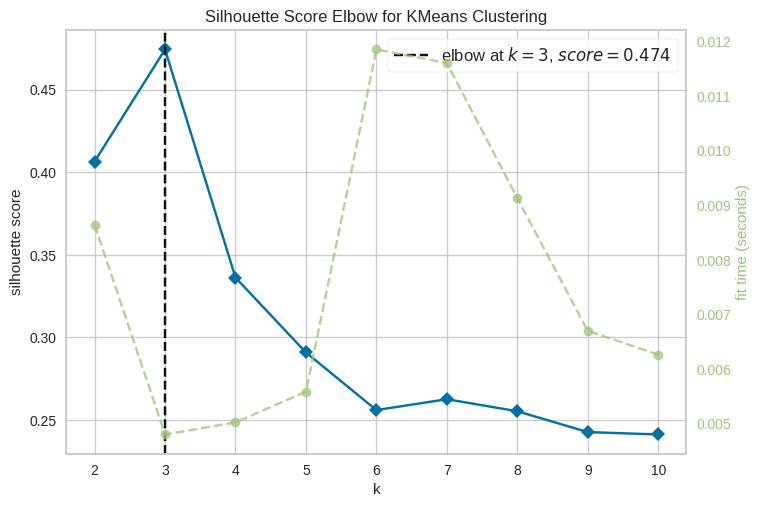

In [ ]:
model1 = KMeans(random_state=1)
visualizer1 = KElbowVisualizer(model1, k=(2, 11), metric="silhouette", timings=True)
visualizer1.fit(subset_scaled_df)  # fit the data to the visualizer
visualizer1.show();  # finalize and render figure

**Observations:**

* Among all k values, **k=3 has the highest silhouette score (0.4745)**

* Visualizer plot also showed **k=3** as **optimal value** with silhouette score = 0.474.

* This suggests the **strongest natural clustering** structure.

* **Beyond k=3**, the silhouette **scores drop dramatically**, indicating **over-clustering**.

###**Silhouette Plots**

**To evaluate our optimal k=3** (maximum silhouette score of 0.474 and elbow flattening), **we focus plots on a narrow range around it: k=3 (best), k=2 (simple baseline), k=4 (test minor increase), and k=5**(compare to visualizer's elbow plot). This targeted selection avoids clutter (e.g., **no k=6-10, as scores decrease dramatically**) while emphasising the trade-offs between under- and over-segmentation.

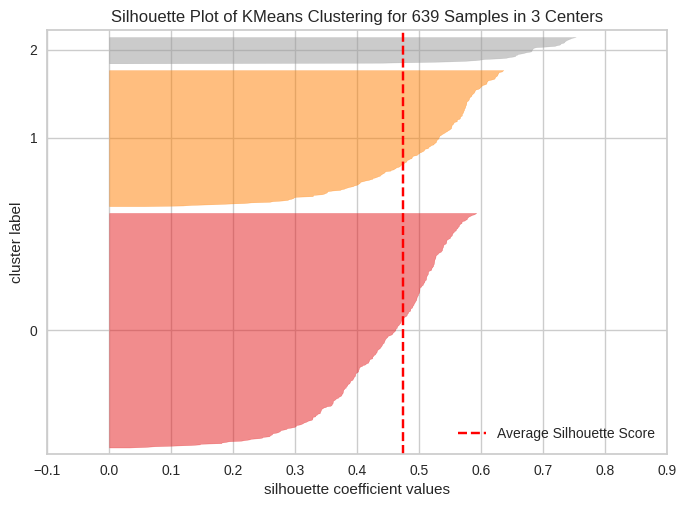

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients, k=3
visualizer2 = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer2.fit(subset_scaled_df)
visualizer2.show();

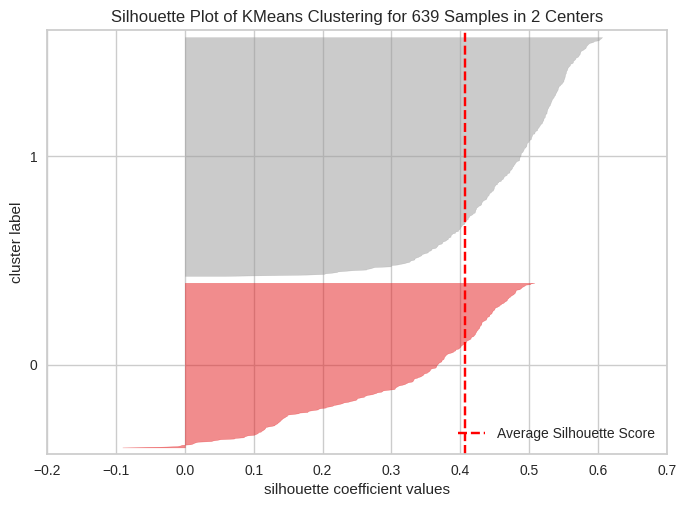

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients, k=2
visualizer3 = SilhouetteVisualizer(KMeans(2, random_state=1))
visualizer3.fit(subset_scaled_df)
visualizer3.show();

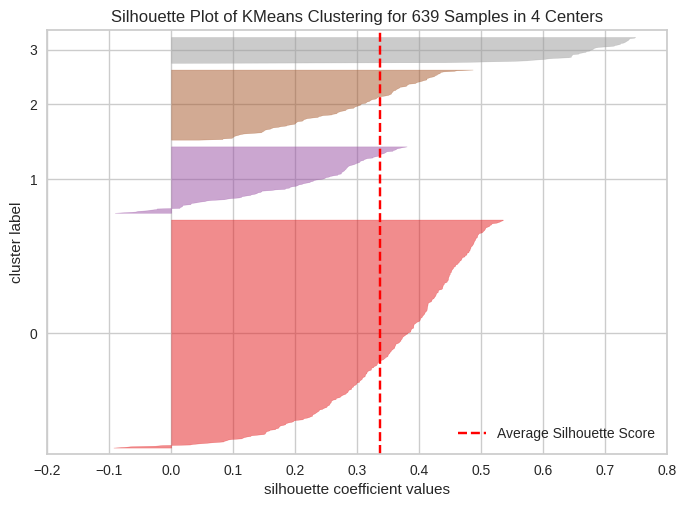

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients, k=4
visualizer4 = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer4.fit(subset_scaled_df)
visualizer4.show();

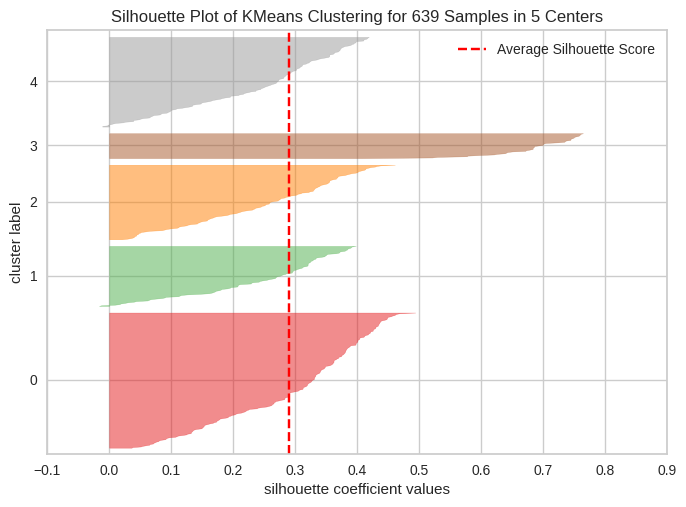

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients, k=5
visualizer4 = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer4.fit(subset_scaled_df)
visualizer4.show();

**Observations on Silhouette plots for k = 2,3,4 & 5:**

***For k=2***

* The **average silhouette score is roughly 0.41**.
* **Two clusters** are seen with considerable separation.
* Both clusters have reasonable **thickness** but **not optimum**.
* **Outliers** is present for **cluster 0**.
* **UNDER-SEGMENTATION:** Can combine different customer groupings.

***For K = 3***
* **Highest average silhouette score (0.47-0.50 range)**
* **Three distinct clusters** with good separation indicating **good separation**.
* Cluster sizes are relatively **balanced based on bar thickness**.
* **No outliers**.
* **Cluster arrangement is stable**.

***For K = 4***
* Further **degradation in  silhouette score (silhouette coefficient = ~0.32)**
* **Four visible clusters** with different score
* All coefficients are positive (no negative values)
* Some **clusters appear thinner than others**.
* Cluster quality has slightly decreased compared to k = 3.
* **Cluster 0 & 1  has outliers**.
* Possible **over-segmentation is starting to become apparent**.

***For K = 5***

* Further degradation in quality (**score ~0.29-0.31**)
* **Five clusters** exhibit further segmentation
* All coefficients stay positive
* Clusters are **much more thinner** and  fragmented as compared to other k values.
* **Cluster 1 & 4  has outliers**.
* **Over-clustering is evident**
* Decreased score and **worst cluster quality** among all.

###**Choosing the appropriate number of clusters**

* Based on visual evidence from plots:
 * All k values exhibit positive clustering (no misclassified points).
 * **k=3** gives an **optimal balance of segmentation quality**.
 * **K = 2 may under-segment** the client base.
 * **k=4 and k=5** demonstrate clear **over-clustering**.
* Therefore, **k=3 is the optimal number of clusters for the final K-means model, as it has the highest average silhouette score (~0.47)**.

###**Final K-mean Model**



**Creating final K-mean model**

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(subset_scaled_df)

KMeans(n_clusters=3, random_state=1)

###**Cluster Profiling: K-means**

**Cluster profiling means understanding and describing each cluster's characteristics to answer: "What kind of customers are in each segment?" It is an act of analysing and interpreting K-means clustering data to assign meaningful, business-relevant labels to each cluster**(for example, "Cluster 0: Traditional Low-Engagement Customers").  After fitting the model, profiling reveals what each cluster represents by looking for trends in the data given to it.  This converts abstract labels (0,1,2) into practical insights (for example, in customer segmentation, target "high-value digital users" with promotions).

**Step1: Add Cluster Labels to the original data**

In [ ]:
# creating a copy of the original data
km_df = df3.copy()

# adding kmeans cluster labels to the original dataframe
km_df["KM_segments"] = kmeans.labels_

**Step 2: Calculate Cluster Sizes and Percentages**

* **It counts customers per cluster**.

CLUSTER SIZES (From Original Data):
KM_segments
0    377
1    219
2     43
Name: count, dtype: int64

PERCENTAGES:
KM_segments
0    59.0%
1    34.3%
2     6.7%
Name: count, dtype: object


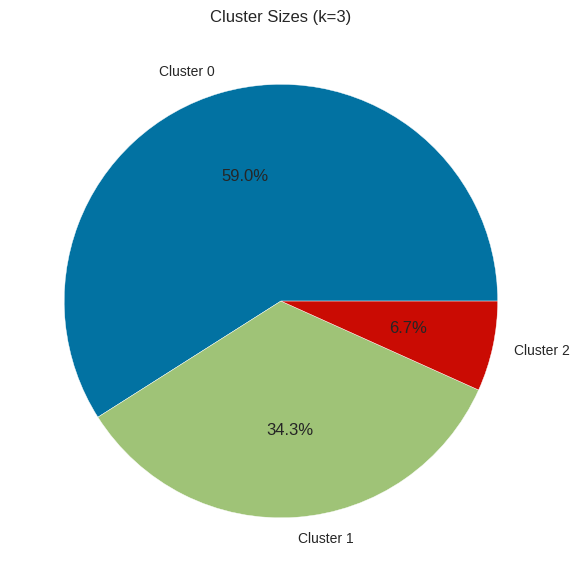

In [ ]:
# Cluster sizes: From original km_df (unscaled, with labels)
sizes = km_df["KM_segments"].value_counts().sort_index()

# Percentages: Proportion of total
size_pcts = sizes / len(km_df) * 100

print("CLUSTER SIZES (From Original Data):")
print(sizes)
print("\nPERCENTAGES:")
print(size_pcts.round(1).astype(str) + '%')

# Optional: Quick pie chart for sizes
plt.figure(figsize=(6, 6))
sizes.plot(kind='pie', autopct='%1.1f%%', labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('Cluster Sizes (k=3)')
plt.ylabel('')  # No y-label for pie
plt.tight_layout()
plt.savefig('cluster_sizes_pie_k3.png', dpi=300, bbox_inches='tight')
plt.show()

**Observations:**

* Clusters are **not balanced**,It is data-driven imbalance and acceptable in real world clustering tasks.
* ***Cluster 0:*** 377 customers (**59.0%**), largest group.
* ***Cluster 1:*** 219 customers (**34.3%**), medium group.  
* ***Cluster 2:*** 43 customers (**6.7%**), smallest group.


**Step3: Calculate Cluster Averages**

* Groups the data by cluster number and calculates the mean for each feature.

In [ ]:
#groups the data by cluster number and calculates the mean for each feature
cluster_means = km_df.groupby('KM_segments').mean()

print("Average values for each cluster:")
print(cluster_means)

Average values for each cluster:
             Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
KM_segments                                                            
0                33938.992042            5.525199           3.477454   
1                12328.767123            2.410959           0.945205   
2               113604.651163            8.581395           0.604651   

             Total_visits_online  Total_calls_made  Credit_Per_Card  \
KM_segments                                                           
0                       0.984085          1.997347      6401.553619   
1                       3.575342          6.917808      6496.955860   
2                       8.906977          1.069767     14250.221484   

             Total_Interactions  Digital_Engagement_Ratio  
KM_segments                                                
0                      6.458886                  0.374027  
1                     11.438356                  0.840600  
2         

**Step4: Display cluster profiles.**

In [ ]:
#display cluster profiles
cluster_means.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_Per_Card,Total_Interactions,Digital_Engagement_Ratio
KM_segments,,,,,,,,
0,33938.992042,5.525199,3.477454,0.984085,1.997347,6401.553619,6.458886,0.374027
1,12328.767123,2.410959,0.945205,3.575342,6.917808,6496.955860,11.438356,0.840600
2,113604.651163,8.581395,0.604651,8.906977,1.069767,14250.221484,10.581395,0.850296


**Observations:**

***Cluster 0: Traditional Customers (59%)***
* Highest bank visits (3.48).  - High preference for in-person banking.

* Lowest digital engagement (0.37) indicates minimal online activity.

* **Moderate credit profile** (33,939 average limit, 5.5 cards)

* **Prefers physical channels**, with only 0.98 online visits versus 3.48 branch visits.

***Cluster 1: Digital Support Seekers (34%)***

* **Highest number of support calls** (6.92).Significant service demands.

* High digital engagement (0.84), preferring online approaches (3.58 online visits).

* **Lowest credit limit (12,329)**.   Potential for credit expansion

* **Avoids branche visists**, with only 0.95 visits despite high interaction needs.

***Cluster 2: Premium Elite (7%)***

* **Highest credit limits (113,605)** are 3.4 times greater than Cluster 1.

* Maximum digital engagement (0.85) - Highest online activity (8.91 visits).

* **Lowest support requirements:** Only 1.07 calls made.

* **Most valuable segment:** highest cards (8.58) and credit per card (14,250).



**Insights:**

***Marketing Opportunities***

  * ***Cluster 2:*** Premium retention techniques (7% generate disproportionate value).
  * ***Cluster 1:*** Credit limit increase campaigns (lower limits, but digitally engaged).
  * ***Cluster 0:*** Digital migration incentives (59% remain branch-dependent)

***Service Improvements***

  * Cluster 1: prioritises urgent service quality improvements, with the highest call volume of 6.92.
  * Cluster 0: Branch Service Optimisation (3.48 Visits Per Customer)
  * Cluster 2: Maintain current service standards (already met)

**Conclusion:**

* The segmentation indicates a clear value-service paradox: Cluster 1 (34% of customers) needs the most support but has the lowest credit value, whereas Cluster 2 (7% of consumers) offers the most value with the fewest service demands.

**Step5: Cluster visualisation for each numerical variable.**

* **We will visualise via Box plot.**

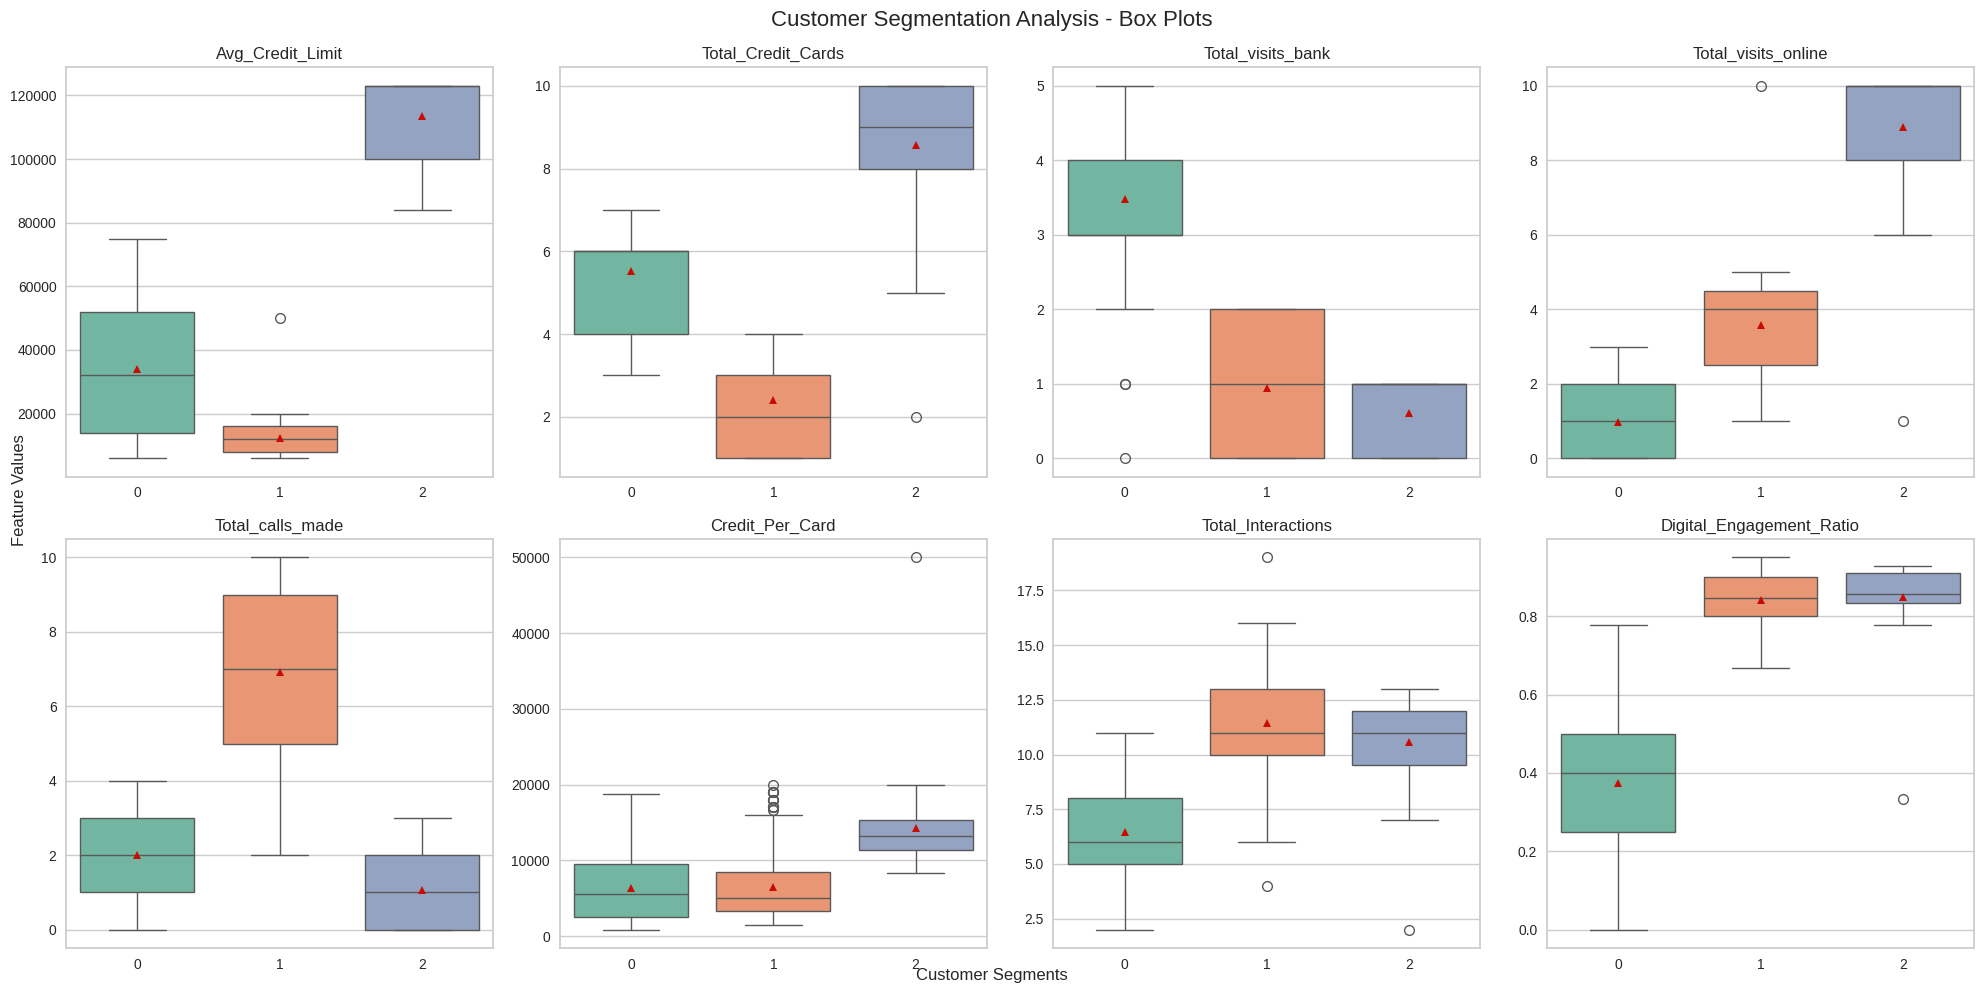

In [ ]:
# List all numerical features
features = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
           'Total_visits_online', 'Total_calls_made', 'Credit_Per_Card',
           'Total_Interactions', 'Digital_Engagement_Ratio']


# good color differentiation
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Customer Segmentation Analysis - Box Plots", fontsize=16)
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.boxplot(ax=axes[i], y=km_df[feature], x=km_df["KM_segments"],
                palette='Set2', showmeans=True)  # Set2 gives distinct colors
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Adding common labels
fig.text(0.5, 0.01, 'Customer Segments', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Feature Values', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()

**Observations on K-means Clustered - Box Plot:**

***Credit Features (Credit_Per_Card, Avg_Credit_Limit)***

* ***Cluster 2*** demonstrates much **larger credit limits** with a broad distribution.

* ***Cluster 0*** features **moderate credit limitations** and some outliers.

* ***Cluster 1*** has the **lowest and most stable credit limit**.

* Credit_Per_Card follows a similar premium pattern as Cluster 2.


***Interaction Features (Total_visits_bank, Total_visits_online, Total_calls_made, Total_Interactions)***

* ***Cluster 1*** has the **most interactions and support calls** overall.

* ***Cluster 0*** has the **largest branch visits** but the **lowest online** activity.

* ***Cluster 2*** maintains balanced interactions, with a **high online preference**.

* Clear channel specialisation across segments.

***Digital Engagement (Digital_Engagement_Ratio)***

* ***Clusters 1 and 2*** demonstrate **high digital engagement** (0.84-0.85).

* ***Cluster 0*** shows much **lower digital engagement** (0.37).

* Minimal within-cluster variability suggests uniform behaviour.

* A clear digital divide exists between the traditional and digital parts.




**Note: We will create bar plots separately for some features because of scale differences, as it is making bars of specific feature invisible.**

<Figure size 1000x600 with 0 Axes>

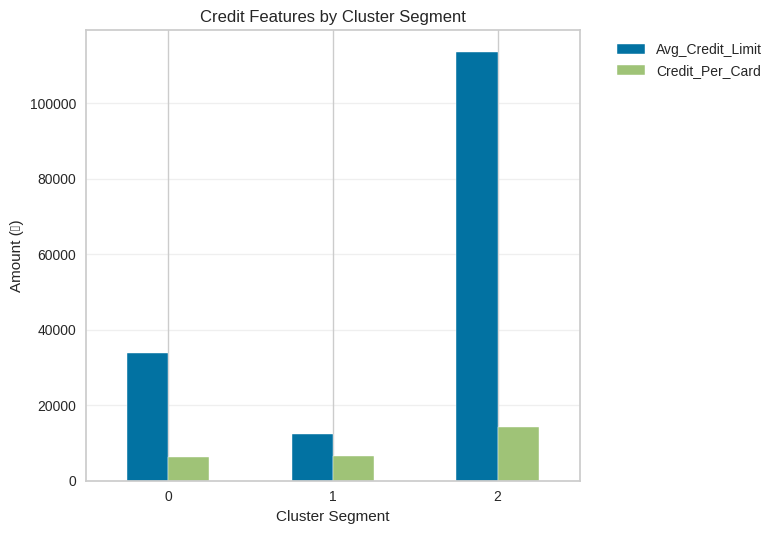

<Figure size 1200x600 with 0 Axes>

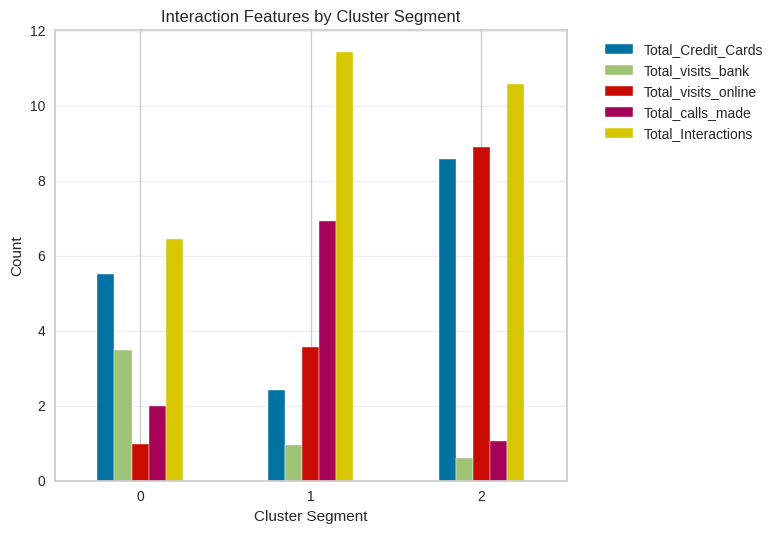

<Figure size 800x600 with 0 Axes>

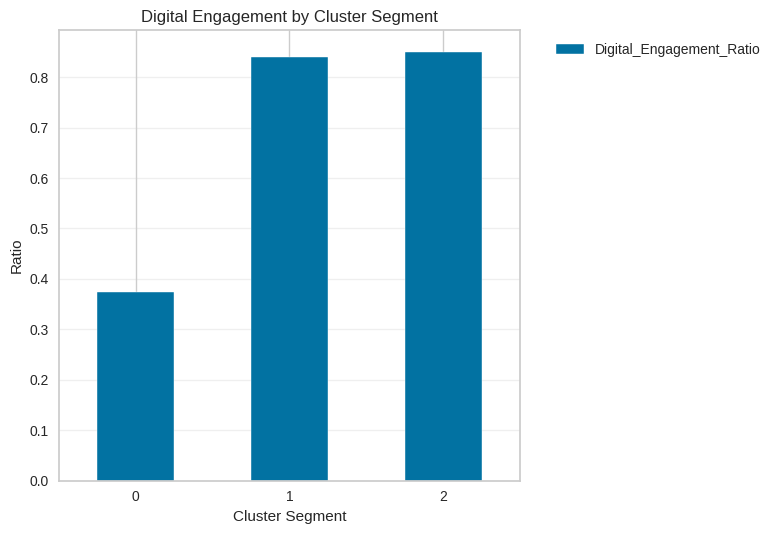

In [ ]:
# Since scale differences make some bars invisible, create separate plots
features = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
           'Total_visits_online', 'Total_calls_made', 'Credit_Per_Card',
           'Total_Interactions', 'Digital_Engagement_Ratio']

# Group features by their typical scale
large_scale = ['Avg_Credit_Limit', 'Credit_Per_Card']
medium_scale = ['Total_Credit_Cards', 'Total_visits_bank', 'Total_visits_online',
                'Total_calls_made', 'Total_Interactions']
small_scale = ['Digital_Engagement_Ratio']

# Plot 1: Large scale features
plt.figure(figsize=(10, 6))
cluster_means[large_scale].plot.bar()
plt.title("Credit Features by Cluster Segment")
plt.xlabel("Cluster Segment")
plt.ylabel("Amount (₹)")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

# Plot 2: Medium scale features
plt.figure(figsize=(12, 6))
cluster_means[medium_scale].plot.bar()
plt.title("Interaction Features by Cluster Segment")
plt.xlabel("Cluster Segment")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

# Plot 3: Small scale features
plt.figure(figsize=(8, 6))
cluster_means[small_scale].plot.bar()
plt.title("Digital Engagement by Cluster Segment")
plt.xlabel("Cluster Segment")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show();

**Overall Observations on K-mean clustering - Bar plots:**

***Credit Features (Credit_Per_Card and Average_Credit_Limit)***

* Cluster 2 has **three times** the credit limits of Cluster 1.

* Cluster 0 holds the middle position with **~34K average limits**.

* A clear value hierarchy was established across segments.

***Interaction Features (Total_visits_bank, Total_visits_online, Total_calls_made, Total_Interactions)***

* Cluster 1 had the **most interactions** (11.4) and calls made (6.9).

* Cluster 0 **leads in branch visits** (3.5) but **lags behind in online** activity (1.0).

* Cluster 2 has significant **online preference** (8.9 visits) and balanced overall involvement.

***Digital Engagement (Digital Engagement Ratio)***

* **Digital engagement** is roughly **comparable** between Clusters 1 and 2.

* Cluster 0 is severely lagging, with **125% lower digital engagement**.




###**Overall Insights from K-mean Clustering**

**Cluster 0**

* Traditional **Branch Dependent** Customers (59% of the base)
* ***Size:*** 377 customers. The **largest segment**.
* ***Credit profile:*** **Moderate** credit limits (34K) with 5.5 cards per customer.
* ***Digital Engagement:*** The **lowest** digital adoption (0.37 ratio)
* ***Channel Preference:*** **Strong branch** preference (3.5 visits) with low online engagement (1.0 visits).
* ***Support Requirements:*** **Low call** volume (2.0 calls); self-sufficient within branches.
* ***Key Characteristic:*** Prefer conventional **in-person banking** services.

**Cluster 1**

* **Digital support**-intensive customers (34% of the base)
* ***Size:*** 219 clients, Medium segment.

* ***Credit Profile:*** **Lowest credit** limit (12K) and fewest cards (2.4 per customer).

* ***Digital Engagement:*** **High digital** adoption (0.84 ratio) and robust online presence (3.6 visits).

* ***Channel Preference:*** Avoids branches** (0.9 visits) and instead **uses digital and phone channels**.

* ***Support Needs:*** The **highest support demand** (6.9 calls per client).

* ***Key Characteristic:*** **Digitally engaged** but needs extensive customer support.


**Cluster 2**

* Premium, **High-Value Customers** (7% of base)
* ***Size:*** 43 consumers. The **smallest** but **most valuable segment**.

* ***Credit Profile:*** **Maximum credit** limit (114K) and **most cards** (8.6 per customer).

* ***Digital Engagement:*** Maximum digital adoption (0.85 ratio); **high online activity** (8.9 visits)

* ***Channel Preference:*** A digital-first approach with **low branch visits** (0.6 visits)

* ***Support Needs:*** The **lowest support** requirements (1.1 calls per client).

* ***Key Features:*** **High-value**, digitally sophisticated, **low maintenance**.


**Conclusion:**

* The **K-means algorithm effectively identified three different customer segments** that serve as useful groupings for targeted business campaigns.

##**PCA - Dimentionality Reduction**

We **will not perform PCA** because:

* **Feature Count is 8 (Low)**. So, no need for PCA.
* **Cluster Quality:** 0.474 silhouette score, means **good separation**.
* **Interpretability:** Clear segments and **3 distinct customer groups (k=3)**.
* **Correlation matrix value < 0.9**, ours is moderate. So, no severe multicollinearity detected.
* **Dataset size:** **Size of our dataset is too small**, the resulting principal components would be unstable and not representative of the true underlying structure, potentially leading to poor results.

##**HIERARCHICAL CLUSTERING**

###**Computing Cophenetic Correlation**

**Let's apply hierarchical clustering with different linkage methods.**

In [ ]:
from scipy.cluster.hierarchy import linkage, cophenet
from scipy.spatial.distance import pdist

# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(subset_scaled_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

print("\nHighest cophenetic correlation is {}, achieved with {} distance and {} linkage.".format(
    high_cophenet_corr, high_dm_lm[0], high_dm_lm[1]))

Cophenetic correlation for Euclidean distance and single linkage is 0.6089822453540668.
Cophenetic correlation for Euclidean distance and complete linkage is 0.7613224916701379.
Cophenetic correlation for Euclidean distance and average linkage is 0.854853637476029.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8315703075552483.
Cophenetic correlation for Chebyshev distance and single linkage is 0.547060484323829.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.7165037205428171.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8286266242799913.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8450933318059591.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.5514399013261537.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.4378072235960447.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.6876241808777573.
Cophenetic corr

**Observations:**

* We got **highest cophenetic correlation is 0.85485**, achieved with **euclidean distance and average linkage**.

**Let's explore different linkage methods with Euclidean distance only.**

In [ ]:
# list of linkage methods (including centroid and ward this time)
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(subset_scaled_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(subset_scaled_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

print("\nHighest cophenetic correlation is {}, achieved with {} distance and {} linkage.".format(
    high_cophenet_corr, high_dm_lm[0], high_dm_lm[1]))

Cophenetic correlation for single linkage is 0.6089822453540668.
Cophenetic correlation for complete linkage is 0.7613224916701379.
Cophenetic correlation for average linkage is 0.854853637476029.
Cophenetic correlation for centroid linkage is 0.8525960959264648.
Cophenetic correlation for ward linkage is 0.7317038249088857.
Cophenetic correlation for weighted linkage is 0.8315703075552483.

Highest cophenetic correlation is 0.854853637476029, achieved with euclidean distance and average linkage.


**Observations:**

* ***Average linkage*** remains the preferred choice **(0.8549)**.

* ***Centroid linkage*** works extremely similarly **(0.8526)**, almost identical.

* ***Ward linkage*** exhibits moderate performance **(0.7317)**.

* ***Single linkage*** is the weakest performer **(0.6090)**.

* Even with additional linking methods (centroid and ward), **the Euclidean distance with Average linkage still has the highest cophenetic correlation (0.8549)**.


**Conclusion:**

* The consistency of both analysis suggests that the **most reliable combination for our hierarchical clustering is Euclidean distance with Average linkage**, which best preserves the original data structure.

###**Dendrograms Plots**

**Let's view the dendrograms for the different linkage methods.**

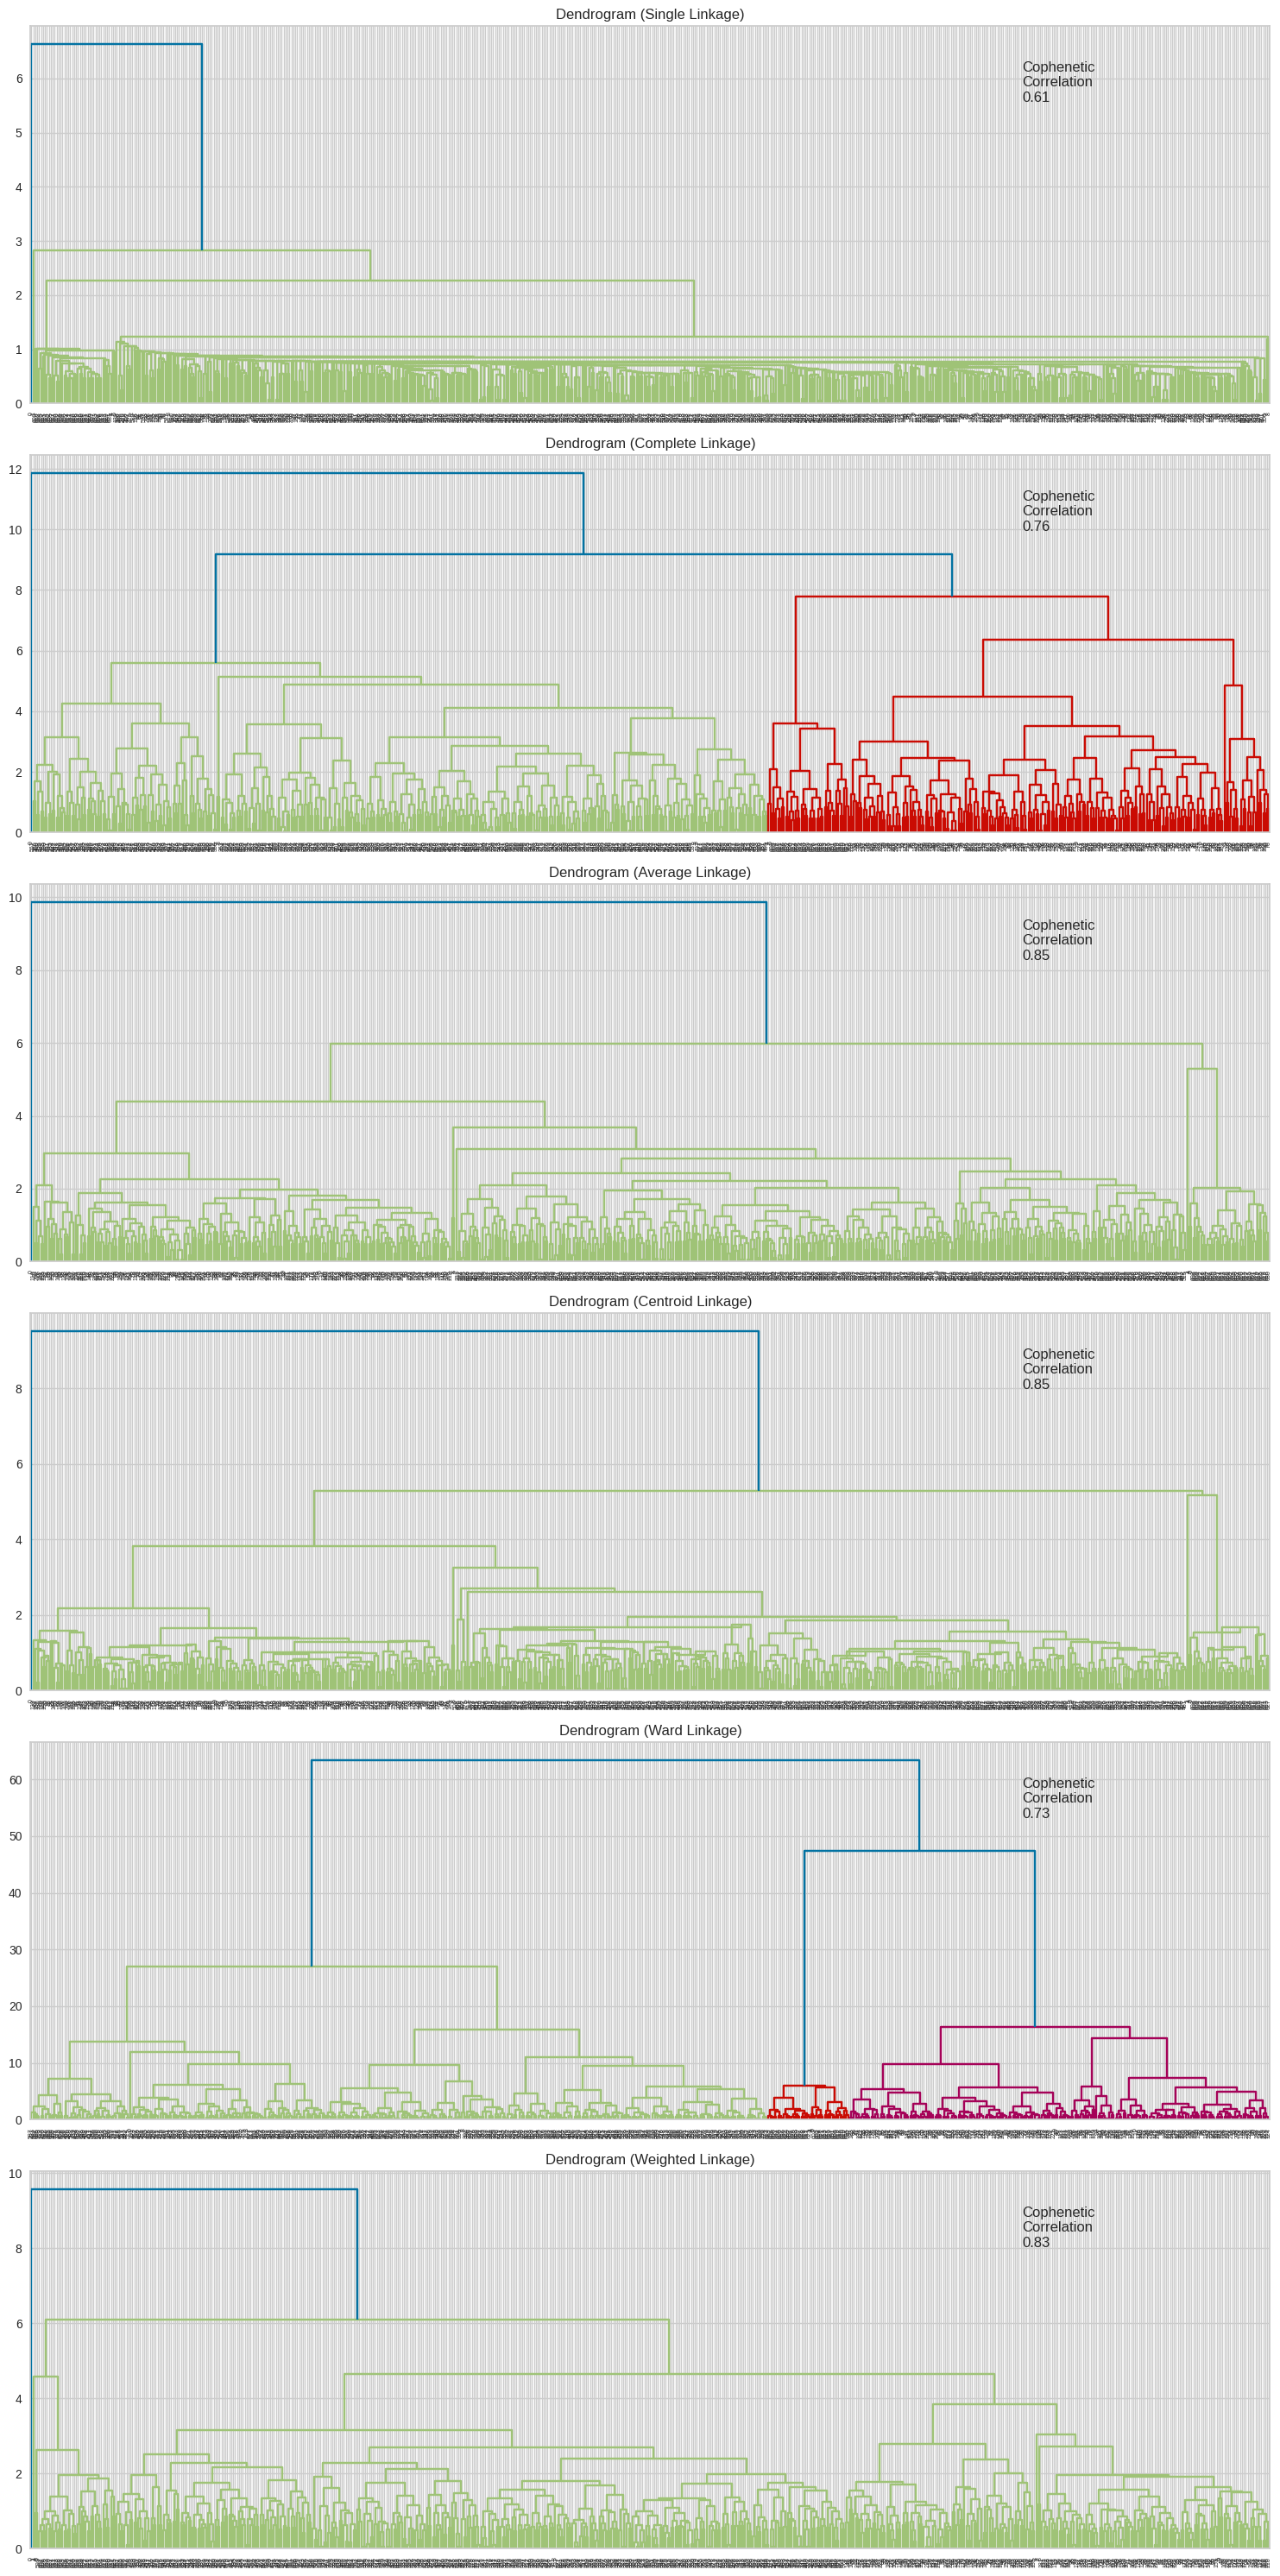

In [ ]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare = []

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(subset_scaled_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(subset_scaled_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    compare.append([method, coph_corr])

plt.tight_layout()
plt.show()

**Observations on dendrogram plot:**

***Single linkage (cophenetic ≈ 0.61)***

* Displays a **strong chaining effect** (long, thin merges).

* **Low cophenetic correlation** leads to a dendrogram that does not accurately preserve the original distance.


***Complete link (cophenetic ≈ 0.76)***

* Produced more **compact clusters and more distinct block separations**.

* **Better than single linkage** for tight clusters; a **moderate cophenetic score** indicates reasonable consistency.


***Average linkage (cophenetic ≈ 0.85)***

* Merges have a **high cophenetic correlation** and are visually balanced.

* The dendrogram demonstrates a **distinct mid-level cluster structure** without excessive linking.

* It maintains pairwise distances well and **produced interpretable clusters**.


***Centroid Linkage (cophenetic coefficient = 0.85)***

* This behaviour is quite similar to average linkage (also high cophenetic).

* Produced **consistent cluster splits** with accurate representation of initial distances.

***Ward Linkage (cophenetic ≈ 0.73)***

* Reduced within-cluster variance results in **more balanced clusters**.

* Displays **large merge heights** for top-level joins (clear major groups).


***Weighted linkage (cophenetic ≈ 0.83)***

* Behaviour ranges between average linkage to complete, with a **rather high cophenetic correlation**.

* Produced **stable merges and reasonable grouping**.

###**Check cophenetic correlation for each linkage method**

**Let's check cophenetic correlation for each linkage method and compare.**

In [ ]:
# Create comparison DataFrame
compare_df = pd.DataFrame(compare, columns=compare_cols)
compare_df = compare_df.sort_values(by='Cophenetic Coefficient', ascending=False)
print(compare_df)

    Linkage  Cophenetic Coefficient
2   average                0.854854
3  centroid                0.852596
5  weighted                0.831570
1  complete                0.761322
4      ward                0.731704
0    single                0.608982


**Observations:**

* **Average Linkage (0.855) is the best choice** because it has the highest cophenetic coefficient.
* **Centroid (0.853) and Weighted (0.832)** are also excellent alternatives and **near to average linkage**.
* **Complete (0.761) and Ward (0.732)** are decent, but **not as reliable** as the top three methods.
* **Single Linkage (0.609) is extremely poor** and should be avoided for this customer segmentation.
* **We will utilise Average Linkage for the final clustering** because it best represents actual customer patterns.

###**Finding the appropriate number of clusters**

**Let's figure out the appropriate number of clusters from dendrogram above and also using silhouette score.**

Clusters: 2, Silhouette Score: 0.6253
Clusters: 3, Silhouette Score: 0.4601
Clusters: 4, Silhouette Score: 0.3916
Clusters: 5, Silhouette Score: 0.4561
Clusters: 6, Silhouette Score: 0.3524
Clusters: 7, Silhouette Score: 0.2343

Optimal number of clusters: 2


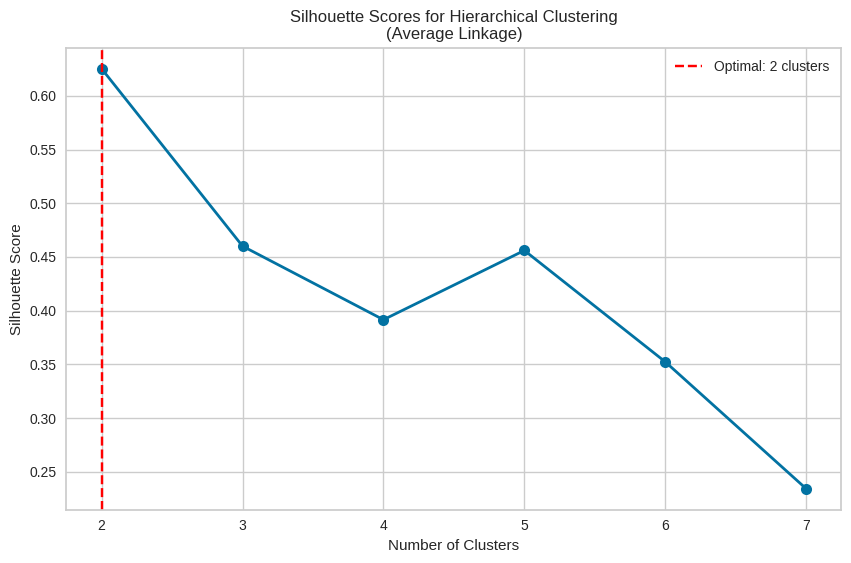

In [ ]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
import numpy as np

# Get the linkage matrix for average linkage (our best method)
Z = linkage(subset_scaled_df, metric='euclidean', method='average')

# Test different numbers of clusters
cluster_range = range(2, 8)
silhouette_scores = []

for n_clusters in cluster_range:
    # Get cluster labels by cutting the dendrogram
    cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')

    # Calculate silhouette score
    silhouette_avg = silhouette_score(subset_scaled_df, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

# Find optimal number of clusters
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_clusters}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Hierarchical Clustering\n(Average Linkage)')
plt.grid(True)
plt.axvline(x=optimal_clusters, color='red', linestyle='--', label=f'Optimal: {optimal_clusters} clusters')
plt.legend()
plt.show()

**Observations:**

***Silhouette Score Analysis***

* Silhouette Score shows peak at **k=2 (0.6253)**, highest score with excellent separation.
* There is a decline for k>2: **k=3 (0.4601) decent (above 0.4 for good quality)**; k=4+ drops (e.g., k=7: 0.2343), indicating over-segmentation.

***Dendrogram Insights***

* The dendrogram supports **3 distinct branches at a moderate cut (between 4-5)**, showing natural sub-groups (e.g., traditional, mid-engaged, digital premium) aligned with criteria like credit/engagement.


**Conclusions:**
* Therefore, **3 appears to be the appropriate number of clusters** from the dendrogram for average linkage.
* Despite k=2's higher Silhouette Score, **we chose 3 as the optimal number of clusters since it provides balanced quality**, aligning with effective business segmentation strategies.

###**Creating Final HC Model using sklearn**

In [ ]:
HCmodel = AgglomerativeClustering(n_clusters=3, metric="euclidean", linkage="average")
HC_labels = HCmodel.fit_predict(subset_scaled_df)

###**Cluster Profiling: Hierarchical Clustering**

**Let's do cluster profiling for hierarchical clustering.**

**Step1: Add Cluster Labels to the original data**

In [ ]:
# Create a NEW dataframe for hierarchical clustering
hc_df = df3.copy()  # copy from original data df3

# Add hierarchical clustering labels to the NEW dataframe
hc_df['HC_segments'] = HC_labels

**Step2: Calculate Cluster Sizes and Percentages**

CLUSTER SIZES (From Original Data):
HC_segments
0     43
1      1
2    595
Name: count, dtype: int64

PERCENTAGES:
HC_segments
0     6.7%
1     0.2%
2    93.1%
Name: count, dtype: object


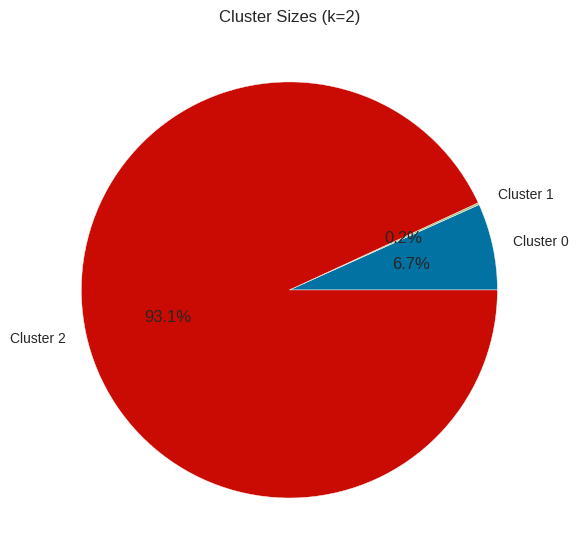

In [ ]:
# Cluster sizes: From original hc_df (unscaled, with labels)
sizes1 = hc_df['HC_segments'].value_counts().sort_index()

# Percentages: Proportion of total
size_pcts1 = sizes1 / len(hc_df) * 100

print("CLUSTER SIZES (From Original Data):")
print(sizes1)
print("\nPERCENTAGES:")
print(size_pcts1.round(1).astype(str) + '%')

# Optional: Quick pie chart for sizes
plt.figure(figsize=(6, 6))
sizes1.plot(kind='pie', autopct='%1.1f%%', labels=['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.title('Cluster Sizes (k=2)')
plt.ylabel('')  # No y-label for pie
plt.tight_layout()
plt.savefig('cluster_sizes_pie_k3.png', dpi=300, bbox_inches='tight')
plt.show()

**Observations:**

* Clusters are **highly imbalanced**,It is data-driven imbalance and acceptable in real world clustering tasks.
* **Cluster 0:** 43 customers (**6.7%**), medium group.
* **Cluster 1:** only 1 customer (**0.2%**), smallest group.

* **Cluster 2**: 595 customers (**93.1%**), largest group.


**Step3: Calculate Cluster Averages**

* **This step groups the data by cluster number and calculates the mean for each feature.**

In [ ]:
#groups the data by cluster number and calculates the mean for each feature
hc_cluster_profile = hc_df.groupby('HC_segments').mean()
print("\nHierarchical Clustering - Cluster Means:")
print(hc_cluster_profile.round(2))


Hierarchical Clustering - Cluster Means:
             Avg_Credit_Limit  Total_Credit_Cards  Total_visits_bank  \
HC_segments                                                            
0                   112441.86                8.60               0.58   
1                   100000.00                2.00               1.00   
2                    25957.98                4.38               2.55   

             Total_visits_online  Total_calls_made  Credit_Per_Card  \
HC_segments                                                           
0                           9.12              1.28         13475.03   
1                           1.00              0.00         50000.00   
2                           1.92              3.80          6419.42   

             Total_Interactions  Digital_Engagement_Ratio  
HC_segments                                                
0                         10.98                      0.86  
1                          2.00                      0.33  
2

**Step4: Display cluster profiles.**

In [ ]:
#display cluster profiles
hc_cluster_profile.style.highlight_max(color="lightgreen", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,Credit_Per_Card,Total_Interactions,Digital_Engagement_Ratio
HC_segments,,,,,,,,
0,112441.860465,8.604651,0.581395,9.116279,1.279070,13475.027685,10.976744,0.864637
1,100000.000000,2.000000,1.000000,1.000000,0.000000,50000.000000,2.000000,0.333333
2,25957.983193,4.383193,2.551261,1.922689,3.796639,6419.415766,8.270588,0.544790


**Observations:**
***Cluster 0: Premium Digital Customers (6.7% of the base)***

* ***High Credit Profile:*** Highest credit limit (**112,442**) with most cards (**8.6**).

* ***Digital dominance:*** most website visitors (**9.1**) and digital engagement (**0.86**).

* ***Low Maintenance:*** Fewer branch visits (**0.6**) and calls made (**1.3**).

* Characteristics: **high value, digitally savvy, self-sufficient**.


***Cluster 1: A single outlier customer (0.2%)***

* ***Unique Profile:*** **High credit per card (50,000)**, but only **2 cards**.

* ***Low Interaction***: **Minimal interaction across all platforms**.


***Cluster 2: Traditional Branch Dependent Majority (93.1%)***

* ***Moderate Credit:*** **Lower credit limits (25,958)** and average **cards (4.4)**

* ***Branch Reliant:*** Most branch visits (2.6) and call centre usage (3.8).

* ***Low Digital:*** Minimal online interaction (1.9 visits; 0.54 ratio)

* Characteristics: **Traditional banking preference, greater support needed**.


**Step5: Cluster visualisation for each numerical variable.**

* **We will visualise via Box plot.**

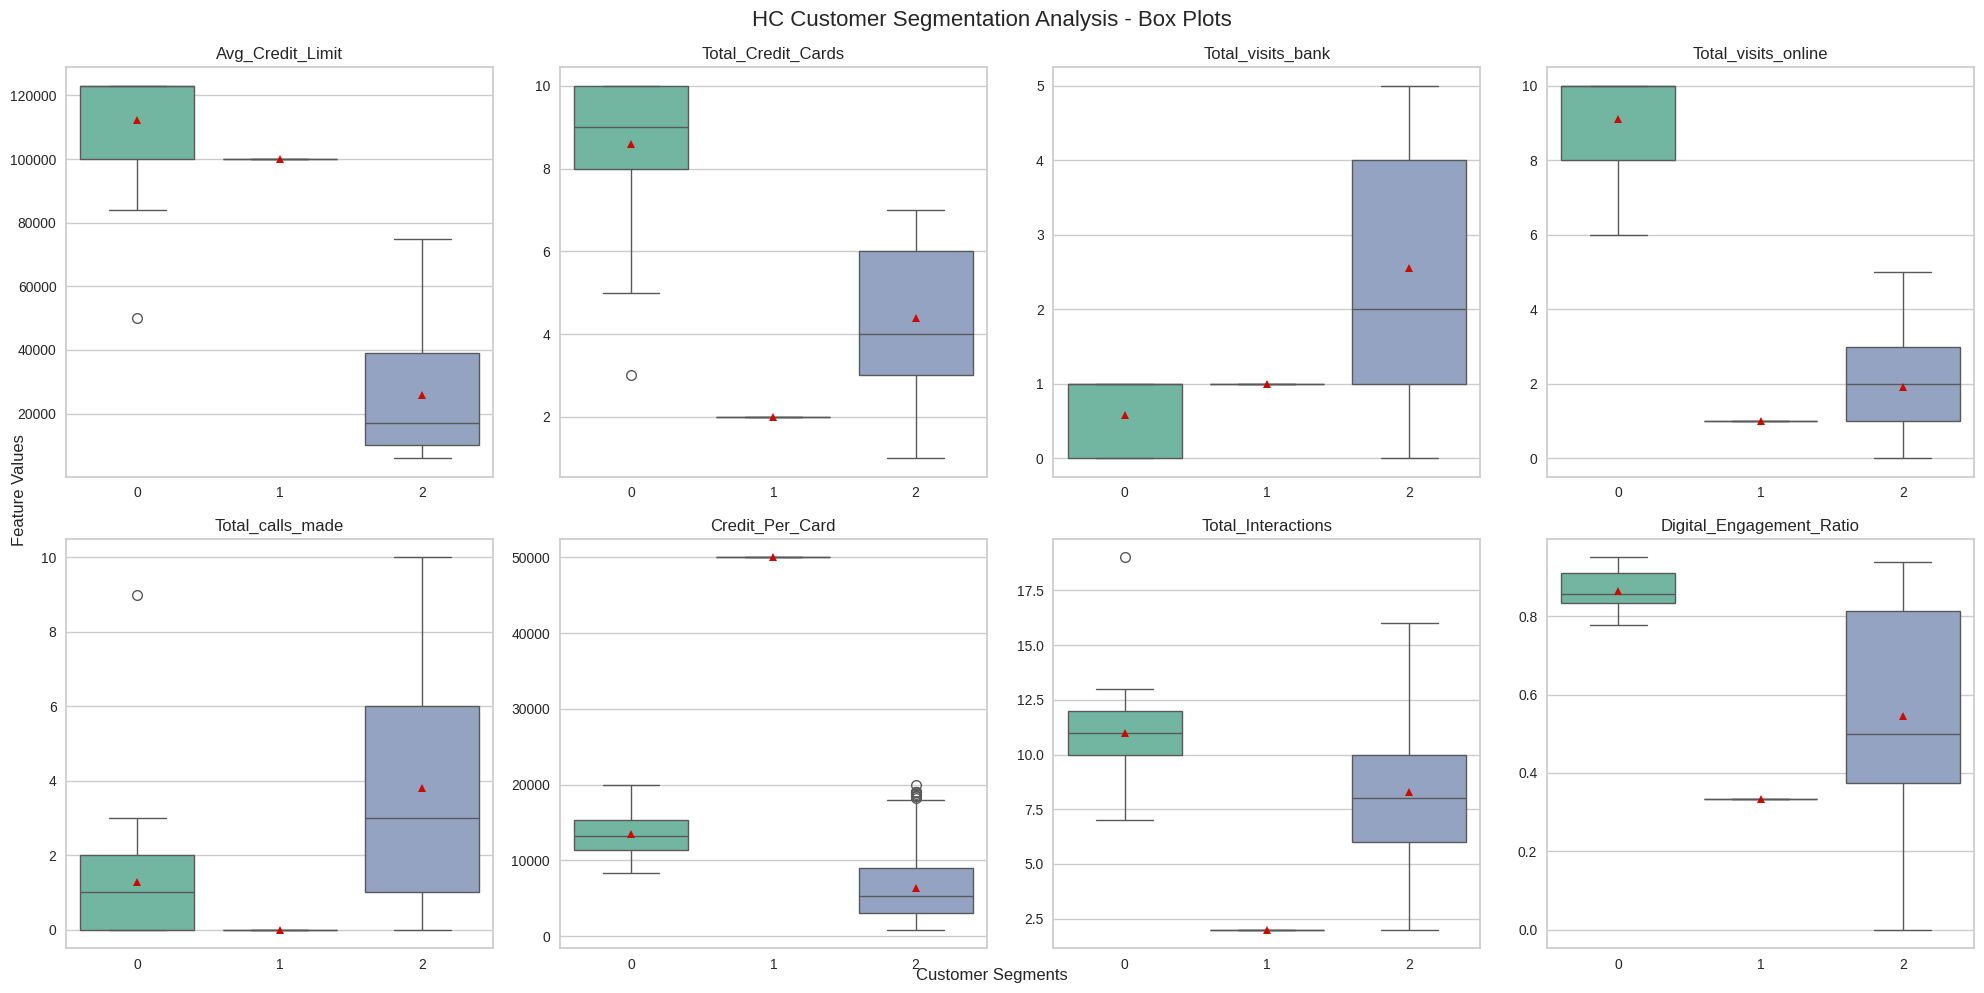

In [ ]:
# List all numerical features
features = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
           'Total_visits_online', 'Total_calls_made', 'Credit_Per_Card',
           'Total_Interactions', 'Digital_Engagement_Ratio']


# good color differentiation
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("HC Customer Segmentation Analysis - Box Plots", fontsize=16)
axes = axes.ravel()

for i, feature in enumerate(features):
    sns.boxplot(ax=axes[i], y=hc_df[feature], x=hc_df["HC_segments"],
                palette='Set2', showmeans=True)  # Set2 gives distinct colors
    axes[i].set_title(feature)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Adding common labels
fig.text(0.5, 0.01, 'Customer Segments', ha='center', fontsize=12)
fig.text(0.01, 0.5, 'Feature Values', va='center', rotation='vertical', fontsize=12)

plt.tight_layout()
plt.show()

**Observations from Box Plots (Hierarchical Clustering):**

***Avg_Credit_Limit***

* ***Cluster 0:*** **High average credit limits (about 100,000 to 120,000)**, steady, and little variation.

* ***Cluster 1:*** **Mid-range (~100k)** with little spread, indicating consistency.
* ***Cluster 2:*** Higher variability and the lowest average credit (~15k - 20k).
* This verifies the separation of premium (Clusters 0 and 1) and mass-market (Cluster 2).


***Total_Credit_Cards***

* ***Cluster 0:*** More credit cards (median ~9).
* ***Cluster 1:*** Only **two cards** (very limited range).
* ***Cluster 2:*** Moderate (**~4 cards**), but with wider variability
* This shows that Cluster 0 uses credit cards frequently, Cluster 1 uses them sparingly, and Cluster 2 uses them moderately.

***Total_visits_bank***
* ***Cluster 0:*** **Rare bank visits** (median **~1**).
* ***Cluster 1:*** Very few, **hardly any bank visits**.
* ***Cluster 2:*** **Most frequent bank visits (~2-5)**, with extreme variations. In contrast to 0 and 1, suggesting Cluster 2 may **relies on physical banking**.

***Total_visits_online***

* ***Cluster 0:*** Highly engaged online, with a large volume of visits (~8-10).
* ***Cluster 1:*** The least amount of digital use (median ~1).
* ***Cluster 2:*** Less consistent, but moderate (~2).
* This implies that Cluster 0 is most digitally engaged, Cluster 1 is the least engaged, and Cluster 2 is balanced.

***Total_calls_made***

* ***Cluster 0:*** Very few calls (**median ~1-2**).
* ***Cluster 1:*** Nearly **no calls**.
* ***Cluster 2:*** The **most calls (~3-6)**, which suggests a **high need for support**.
* As a result, **Cluster 2 is significantly reliant on call-based services**, while Cluster 1 is less so.

***Credit_Per_Card***

* ***Cluster 0:*** Moderate (**each card ~12k-15k**).
* ***Cluster 1:*** Extremely high (**~50,000 per card**).
* ***Cluster 2:*** **Lowest (~5k)** with significant variation.
* This demonstrates that **Cluster 1 customers hold fewer cards**, but each has **extremely high limits**, as opposed to Cluster 2.


***Total_Interactions (the sum of calls and visits)***

* ***Cluster 0:*** Mostly online, **high interaction rate (~10-12)**.
* ***Cluster 1:*** Minimal engagement, **very low (~2)**.
* ***Cluster 2:*** Widespread but **moderate (~8-10)**.
* This indicates that **Cluster 0 represents more digital** engagement, **Cluster 2 represents more bank and call** engagement, and **Cluster 1 represents low interaction**.


***Digital_Engagement_Ratio***

* ***Cluster 0:*** Definitely **digitally driven**, very high (**~0.9**).
* ***Cluster 1:*** **Lowest** usage of digital platforms (**~0.3**).
* ***Cluster 2:*** Mixed digital and physical, moderate (~0.5).
* This validates **Clusters 0 as digital users, **Clusters 1 as traditional, and Cluster 2 hybrid**, respectively.


**Insights:**

* ***Cluster 0:*** High credit, minimal physical dependence, and premium users who are actively involved online.
* ***Cluster 1:*** Low-engagement, high-value clients with very high credit per card and low interactions.
* ***Cluster 2:*** Traditional mass-market customers with low credit and strong need for support through phone calls and bank visits.



**Now, We will visualise via Bar plot based on each feature category.**

<Figure size 1000x600 with 0 Axes>

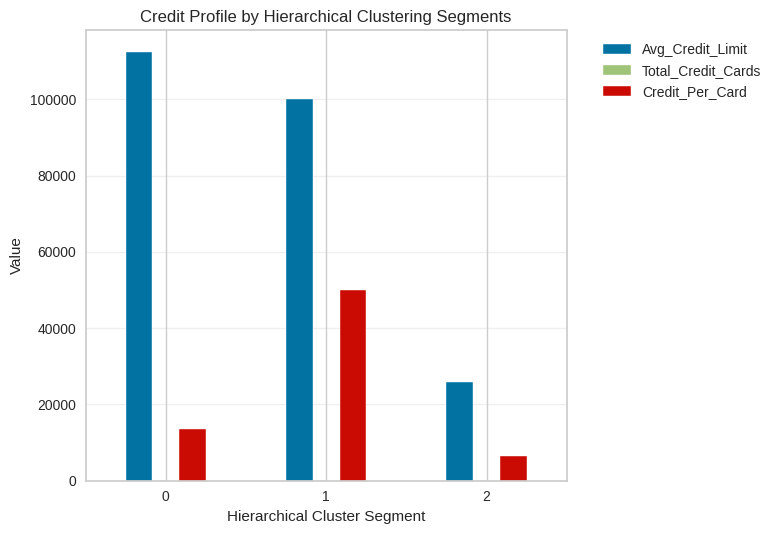

<Figure size 1200x600 with 0 Axes>

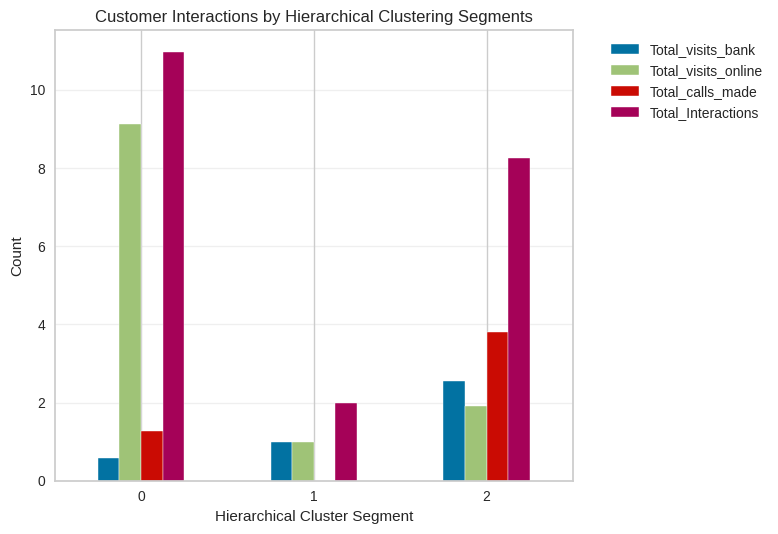

<Figure size 800x600 with 0 Axes>

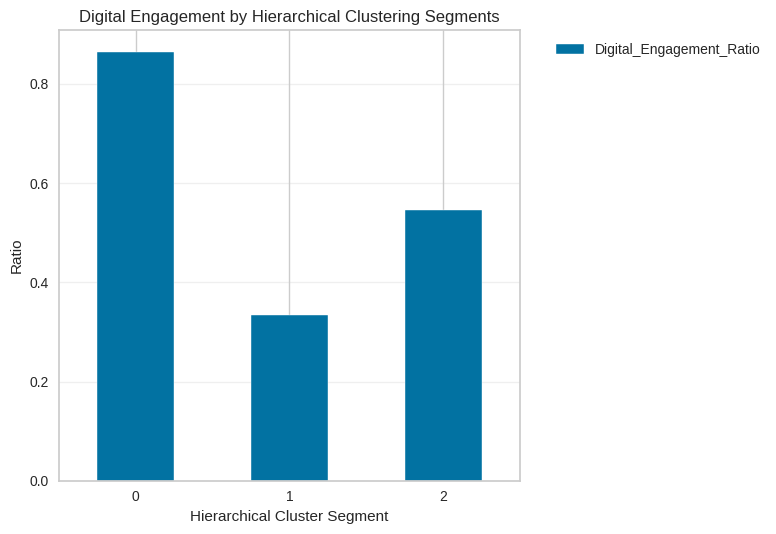

In [ ]:
# Split features into logical groups
credit_features = ['Avg_Credit_Limit', 'Total_Credit_Cards', 'Credit_Per_Card']
interaction_features = ['Total_visits_bank', 'Total_visits_online', 'Total_calls_made', 'Total_Interactions']
digital_features = ['Digital_Engagement_Ratio']

# Plot 1: Credit Features
plt.figure(figsize=(10, 6))
hc_cluster_profile[credit_features].plot.bar()
plt.title("Credit Profile by Hierarchical Clustering Segments")
plt.xlabel("Hierarchical Cluster Segment")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show();

# Plot 2: Interaction Features
plt.figure(figsize=(12, 6))
hc_cluster_profile[interaction_features].plot.bar()
plt.title("Customer Interactions by Hierarchical Clustering Segments")
plt.xlabel("Hierarchical Cluster Segment")
plt.ylabel("Count")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show();

# Plot 3: Digital Engagement
plt.figure(figsize=(8, 6))
hc_cluster_profile[digital_features].plot.bar()
plt.title("Digital Engagement by Hierarchical Clustering Segments")
plt.xlabel("Hierarchical Cluster Segment")
plt.ylabel("Ratio")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show();

**Overall Observations on hierarchical clustering - Bar plots:**

***Credit Features (Credit_Per_Card and Average_Credit_Limit)***
* ***Cluster 0*** has the **highest average credit (~112k Avg_Credit_Limit)**.  **Credit per card is moderate (~14k)**.  **Total credit cards appear to be higher** than the other groups.
* ***Cluster 1*** has a **high credit_per_card (~50k)**, however the **average credit limit is slightly lower** than Cluster 0 (**~100k**).  This suggests fewer cards with a larger maximum per card.
* ***Cluster 2*** has the **lowest average credit limit** (**~26k**) and **credit per card (~6k)**, while having only a few cards.
* So, Clusters 0 and 1 are both **high-value**, however their structures differ.  Cluster 2 represents the lower-value segment.

***Interaction Features (Total_visits_bank, Total_visits_online, Total_calls_made, Total_Interactions)***

***Cluster 0:***
* **Total_visits_online** is **~9.0**.
* **Total_Interactions ≈ 11.0**, suggests the **highest total interactions**.
* **Total_calls_made ≈ 1.3 (low)**.
* **Total_bank_visits** are **~0.6**, indicating a very few bank visits. Customers **engage highly online**, driving the majority of overall activity; with **limited reliance on phone calls and branch visits**.

***Cluster 1***
* **Total_Interactions is around 2(extremely low)**.
* **Total_bank_visits** and **Total_online_visits** are around **1**.
* If the **Total_calls_made** is **close to zero**, it indicates that  Low-interaction segment has less involvement across platforms (**low maintenance** but low capture opportunity).


***Cluster 2***

* **Total_Interactions**: about **8.2** (moderately high)
* **Total_bank_visits** is around **2.5**, whereas **Total_online_visits** is around **2**.
* **Hybrid/support-intensive**, **customers use both channels** but prioritise calls and branch visits (total_calls_made = 3.8).

* Therefore, **Cluster 0 is the most online-active**; Cluster 2 is the most support/branch-oriented (calls + bank visits); and Cluster 1 has low engagement overall.

***Digital Engagement (Digital Engagement Ratio)***

* ***Cluster 0:*** **~0.90** indicates **high digital engagement** (digital-first).

* ***Cluster 1:*** **~0.30** indicates **low digital adoption** (traditional/low-digital).

* ***Cluster 2:*** ~0.57 suggests **moderate/mixed digital usage** (hybrid).

* Therefore, **Cluster 0 has digital influenced customers, Cluster 2 has mixed digital users, and Cluster 1 has the customers who engage least digitally**.




###**Overall Insights from Hierarchical Clustering**

**Cluster 0**

* It consists of 43 premium digital-only customers, representing 6.7% of the base.

* ***Credit Profile:*** **Highest credit limits (112,000)**; moderate **credit per card (14,000)**.

* ***Digital Engagement:*** High digital usage (0.90 ratio) and significant online activity (9.0 visits)

* ***Channel Preference:*** A digital-first approach with low branch visits (0.6) and calls (1.3).

* ***Support Needs:*** Lowest support needed; very self-reliant.

* ***Key Characteristic:*** Customers are **high-value**, **digital savvy**, and **require little support services**.

**Cluster 1**
* It has Single unique customer.

* ***size:*** **1 customer** i.e. 0.2% of the base (possible outlier).

* ***Credit profile:*** High credit concentration (**50,000 per card**), **moderate** overall credit limits (**100,000**).

* ***Digital Engagement:*** The **lowest digital use** (**0.30**), with negligible online presence

* ***Channel Preference:*** Very **little contact** across all platforms (**2 total interactions**).

* ***Support Needs:*** **Minimal support demands**, but minimal engagement.

* ***Key Characteristic:*** **Unique client profile that requires individual analysis**.

**Cluster 2**

* This cluster seems have **mass market traditional Customers**.

* ***Size:*** 595 customers (93.1% of base)

* ***Credit Profile:*** **Lowest credit limits (26,000)**, minimum **credit per card (6,000)**.

* ***Digital Engagement:*** It is **moderate (0.57)**, with a balanced platform preference.

* ***Channel Preference:*** Customers in this segment have **high calls made (3.8) and branch visits (2.5)**.

* ***Support Needs:*** The **highest support requirements across all platforms**.

* ***Key Characteristic:*** Traditional, **highly-engaged customers** representing the majority.

**Conclusion:**
* The **hierarchical clustering technique, which was optimised via cophenetic score evaluation, divided customers into three significant groups**.  
* Despite size disparities, each cluster has statistically different attributes.  
* Cluster 0 indicates high-value digital natives, Cluster 1 identifies an extreme behavioural pattern that requires further individual analysis, and Cluster 2 captures the mainstream consumer profile.  
* This **segmentation offers a complementary perspective to partition-based approaches by identifying natural customer groupings in the dataset**.

#**K-means vs Hierarchical Clustering**

**We performed the following steps to compare K-Means and Hierarchical Clustering's (HC) clustering performance:**

* ***Silhouette Scores:*** For Checking the clustering quality; a higher score indicates better separation.

* ***Cluster Sizes:*** The balance of clusters was compared.

* ***Cross-tab:*** Checked for customer overlap across both techniques.

* ***Validation Metrics:***

  * ***Adjusted Rand Index (ARI):*** Determines the similarity of two clustering results (1 = identical, 0 = random).

  * ***Normalised Mutual Information (NMI):*** Measures the amount of information shared between results (1 = perfect agreement, 0 = none).

* ***Visuals Comparison Analysis:*** Scatter plots for evaluating the quality of separation.

KMeans Silhouette Score: 0.47448335027610444
HC Silhouette Score: 0.46009802923960064

Cluster Sizes (KMeans):
KM_segments
0    377
1    219
2     43
Name: count, dtype: int64

Cluster Sizes (HC):
HC_segments
2    595
0     43
1      1
Name: count, dtype: int64

Cross-tab (KMeans vs HC):
HC_segments   0  1    2
KM_segments            
0             0  0  377
1             1  0  218
2            42  1    0

Adjusted Rand Index (KMeans vs HC): 0.2260292479478202
Normalized Mutual Information (KMeans vs HC): 0.43059620611955307


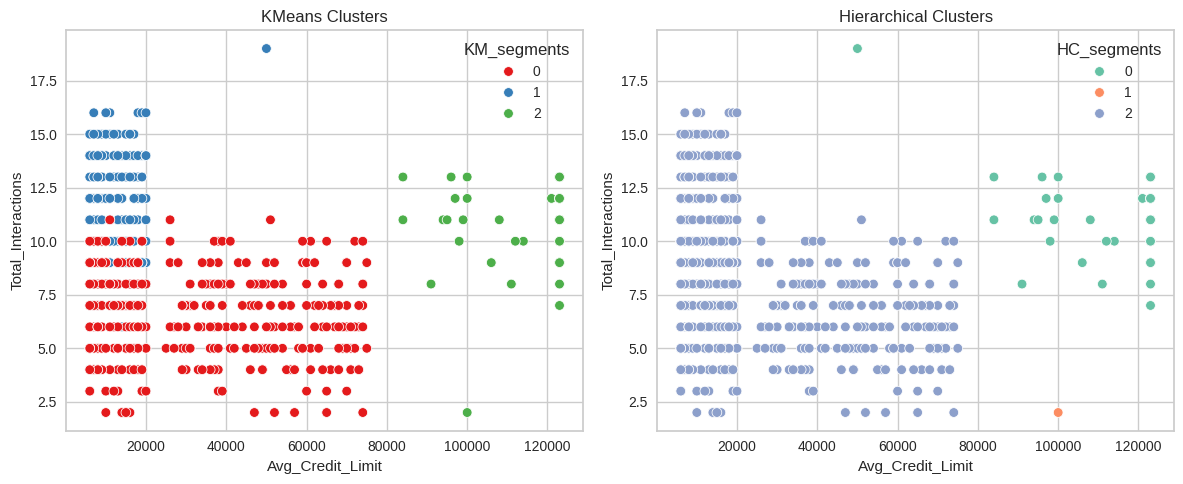

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score


# Compare Silhouette Scores

print("KMeans Silhouette Score:",
      silhouette_score(subset_scaled_df, km_df["KM_segments"]))
print("HC Silhouette Score:",
      silhouette_score(subset_scaled_df, hc_df["HC_segments"]))


# Compare Cluster Sizes

print("\nCluster Sizes (KMeans):")
print(km_df["KM_segments"].value_counts())

print("\nCluster Sizes (HC):")
print(hc_df["HC_segments"].value_counts())


#Cross-tab between HC & KMeans

comparison_table = pd.crosstab(km_df["KM_segments"], hc_df["HC_segments"])
print("\nCross-tab (KMeans vs HC):")
print(comparison_table)


#External Validation Metrics

ari = adjusted_rand_score(km_df["KM_segments"], hc_df["HC_segments"])
nmi = normalized_mutual_info_score(km_df["KM_segments"], hc_df["HC_segments"])
print("\nAdjusted Rand Index (KMeans vs HC):", ari)
print("Normalized Mutual Information (KMeans vs HC):", nmi)


#Visualization: Cluster Comparison

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.scatterplot(x="Avg_Credit_Limit", y="Total_Interactions",
                hue=km_df["KM_segments"], palette="Set1", data=km_df, ax=axes[0])
axes[0].set_title("KMeans Clusters")

sns.scatterplot(x="Avg_Credit_Limit", y="Total_Interactions",
                hue=hc_df["HC_segments"], palette="Set2", data=hc_df, ax=axes[1])
axes[1].set_title("Hierarchical Clusters")

plt.tight_layout()
plt.show()


**Overall Observations on K-Means vs Hierarchical Clustering:**

***Cluster Quality (Silhouette Score)***

* **K-Means achieved a silhouette score of 0.47**, while **Hierarchical scored 0.46**.
* Both methods provide moderate separation, but the scores are very close.


***Cluster Distribution***

* **K-Means formed three balanced clusters: 59%, 34%, and 7%** of customers. This shows **clear segmentation** of low-value frequent callers, mid-value mixed users, and premium digital-first customers.

* **Hierarchical formed one dominant cluster (93%) and two very small clusters (7% and less than 1%)**. While it identified outlier high-credit customers, the overall **segmentation is imbalanced** and less useful.



***Cluster-by-Cluster Comparison***

**K-Means Clusters (More Business-Friendly):**  
* ***Cluster 0 (59%):*** Traditional branch users. These customers have moderate credit, make high bank visits, and show low digital engagement.
* ***Cluster 1 (34%):*** High-support needs. These customers have lower credit, high call volume, and mixed channel usage.
* ***Cluster 2 (7%):*** Premium digital customers. They have high credit, high online engagement, and low branch dependency.

***Hierarchical Clusters (Less Practical):***
* ***Cluster 0 (6.7%):*** High-value digital segment, similar to K-means Cluster 2.
* ***Cluster 1 (0.2%):*** Extreme outlier with only 1 customer. This is not a viable segment.
* ***Cluster 2 (93.1%):*** An overly broad segment that mixes various customer types.


***Cluster Profiling Comparison***

* **Both algorithms identified a premium high-credit, digitally engaged group and a traditional, support-heavy group**.
* **However, K-Means provided a three, stable middle cluster with mid-credit and moderate interactions**.
* This is useful for targeted marketing. Hierarchical tended to merge most customers together and lost granularity.


***Agreement Between Techniques***

* The Adjusted Rand Index - **ARI(0.23) and NMI (0.43)** show **low similarity between the two clusterings**.
* This means K-Means and Hierarchical Cluster Methods **classify customers differently**, with **K-Means showing clearer business segments**.


***Visual Insights (Avg_Credit_Limit vs Total_Interactions)***

* In the **K-Means plot**, there is **balanced separation across three clusters**, showing a progression from low to high credit with distinct interaction patterns.
* In the **Hierarchical plot**, **one large cluster dominates**, while a few points are isolated as outliers, limiting business usefulness.


**Conclusion:**

* Both K-Means and Hierarchical Clustering provided useful insights.

*  Hierarchical Clustering can help us **find outliers** and comprehend the density pattern of our data.

* K-Means Clustering generates **balanced, well-defined, and business-actionable clusters** that divide customers into distinct groups (traditional users, digitally savvy mid-tier, and premium customers).



##**Final Algorithm Choice**


* While **both clustering techniques identified customer segments**, **K-means** clustering offers the best base for AllLife Bank's strategic initiatives. **The resulting groups are statistically sound, business-relevant**, and easily applicable to both marketing campaigns and service delivery improvements.

* Therefore, **K-Means is the chosen as final algorithm** because it **provides practical and balanced customer segments** that the **bank can immediately employ for marketing and service plans**. It also has **faster execution time** as compared to hierarchical clustering. Thus, **K-means will save computational time & resources** for the bank, as  it is **computationally less expensive**, especially with larger datasets.

* Despite its technical soundness, the **hierarchical clustering** approach generates segments that are **not commercially viable** due to **excessive imbalance** and **limited variation within the dominant customer group**.



#**ACTIONABLE INSIGHTS & BUSINESS RECOMMENDATIONS**

**The overall analysis addressed the AllLife Bank's two goals: improving credit card market penetration through targeted marketing and improving service delivery operations**. We identified different customer segments based on their spending patterns and behaviors. This allows us to suggest practical strategies for personalizing customer engagement and optimizing service delivery.

**ACTIONABLE INSIGHTS**

**Digital Engagement Divide**  

* **59%** of customers prefer **traditional branch banking** with minimal digital interaction.  * **7% are fully digital, high-value customers** who need premium services.  
* **34%** use **multiple platforms** but **need significant support**, showing **service gaps**.  

**Credit-Service Relationship**

* Higher credit limits link to lower support needs and more digital self-service.  
* Customers with **lower credit limits** make **3 times more calls** and interactions.  
* **Premium customers** (7%) provide the **highest value** with the **lowest service costs**.  

**Platform Preferences**

* There is a clear **inverse relationship** between **branch visits and online engagement**.  
* **Phone support** is crucial **for mid-value customers** despite the availability of digital options.  
* No groups uses all channels equally; each group has distinct preference patterns.  

**Revenue vs Service Cost**

* The **most profitable** customers (**those with high credit**) **cost the least to service**.  
* The **highest service costs** come from **moderate-value customers**.  
* **Traditional customers** make up the **largest segment** but show **moderate profitability**.  



**BUSINESS RECOMMENDATIONS**  

**Segment 1: Traditional Branch Users**  

***Marketing Strategies:***  
* Launch **"Digital Discovery" workshops** in branches with staff incentives.  
* Offer **relationship-based pricing** for customers using multiple bank products.  
* Introduce **gradual digital migration** with branch-supported onboarding.  

***Service Improvements:***  
* **Enhance the branch experience** with dedicated customer service desks.  
* Develop **video tutorials at branch** kiosks **for basic digital transactions**.  
* Create **hybrid service models**, starting in branch and continuing online.  

**Segment 2: High-Support Needs Customers**  

***Marketing Strategies:***
* Offer **financial education programs** to boost creditworthiness and confidence in self-service.  
* Target them with **secured credit card upgrade** campaigns as credit profiles improve.  
* Introduce **budgeting tools** and financial wellness resources.  

***Service Improvements:***  
* Implement **AI-powered call** routing to cut wait time by 30%.  
* Create proactive **service alerts** for typical banking issues.  
* Design **simplified digital self-service** options for frequent questions.  

**Segment 3: Premium Digital Customers**

***Marketing Strategies:***  
* Introduce **premium subscription services**, such as enhanced fraud protection and concierge services.  
* Cross-sell **investment and wealth management** products.  
* Offer **personalized rewards** based on spending habits.  

***Service Improvements:***  
* Assign **dedicated digital relationship managers** for premium support.  
* Implement priority **digital service channels** with quicker response times.  
* Provide **early access** to new digital features and banking innovations.  

**Conclusions**  
By implementing segment-specific strategies, AllLife Bank will be able to see significant improvements in customer acquisition and service delivery:

* **Marketing effectiveness** will improve through **personalized campaigns** tailored to each segment's preferences and behaviors.  
* **Service delivery costs** will **decrease by optimizing channel** usage and cutting unnecessary interactions.  
* **Customer satisfaction** will **rise as services match individual preferences** and needs.  
* **Revenue growth** will **speed up through targeted upselling** and **improved retention rates**.